In [1]:
%matplotlib inline

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import datetime
from collections import Counter
import math
import copy

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to airbnb database
connection = sqlite3.connect('airbnb.db')

In [4]:
# Query the listings table in airbnb.db and convert the listings table to dataframe
vwListings = pd.read_sql('SELECT * FROM most_recent_listings', connection)
vwListings1 = pd.read_sql('SELECT * FROM most_recent_listings', connection)
vwListings.head()

,id,MAX(last_scraped),source_name,scrape_id,source,name,description,neighborhood_overview,host_id,host_name,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,3571,2022-09-14,listings_9_2022,20220914194735,city scrape,River Place,<b>The space</b><br />Penthouse apartment with...,,4517,Don,...,4.83,4.67,,f,1,1,0,0,0.06,$200.00
1,3686,2023-03-19,listings_3_2023,20230319041206,city scrape,Vita's Hideaway,IMPORTANT NOTES<br />* Carefully read and be s...,We love that our neighborhood is up and coming...,4645,Vita,...,3.86,4.62,,f,1,0,1,0,0.54,$67.00
2,3943,2023-03-19,listings_3_2023,20230319041206,city scrape,Historic Rowhouse Near Monuments,You will be staying in high ceiling bedroom w...,This rowhouse is centrally located in the hear...,5059,Vasa,...,4.57,4.74,Hosted License: 5007242201001033,f,5,0,5,0,2.7,$85.00
3,4197,2023-03-19,listings_3_2023,20230319041206,city scrape,Capitol Hill Bedroom walk to Metro,This is the middle bedroom upstairs in a resto...,"Our area, the Eastern Market neighborhood of C...",5061,Sandra,...,4.96,4.94,Hosted License: 5007242201000749,f,1,0,1,0,0.31,$90.00
4,4373,2022-09-14,listings_9_2022,20220914194735,city scrape,"1,2 bdrm sitrm bath nr AIRP kitchen",You will have as much privacy as you wish. Th...,"Our neighborhood is quiet, safe, and friendly....",5623,Nancy And Don,...,4.81,4.71,,f,2,0,2,0,0.14,$40.00


Originally, $listings$ table has 75 columns. When we loaded 4 listings files in the last 4 quarters into our database, we created one more column named `source_name` to keep track the data source of each record. Hence, $listings$ table has 76 columns. Let's take a look on the overview of listings table.

In [5]:
vwListings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8628 entries, 0 to 8627
Data columns (total 69 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            8628 non-null   int64  
 1   MAX(last_scraped)                             8628 non-null   object 
 2   source_name                                   8628 non-null   object 
 3   scrape_id                                     8628 non-null   int64  
 4   source                                        8628 non-null   object 
 5   name                                          8628 non-null   object 
 6   description                                   8628 non-null   object 
 7   neighborhood_overview                         8628 non-null   object 
 8   host_id                                       8628 non-null   int64  
 9   host_name                                     8628 non-null   o

Because we loaded the data of listings file in the last 4 quarters, the majority of the listing properties are duplicated. Our goal in this project is to suggest the fair listing price for a property based on other similar properties in the market. Therefore, we created a view named most_recent_listings to obtain all the distinct listing properties with the most recent `last scraped` date. In addition, in the $listings$ table, there are some variables which do not carry any meanings to the model. They are `listing_url`,  `picture_url`, `host_id`, `host_url`,  `host_thumbnail_url`, `host_picture_url`, `calendar_updated`. Hence, we excluded those columns in the view most_recent_listings. Besides, the purpose of `source_name` is to keep track the data source of each record, we will not perform EDA on `source_name`.

most_recent_listings table has 69 columns and 8,628 records. The data types of columns are object, integer or float. Although the information of most_recent_listings table indicates that there are no columns having null value, in fact, a part of `source` column may be null (marked as NA). We knew that because during loading the listings data of each quarter to our database, we found out that listings file in June 2022 does not have "source: column. However, listings files of 3 other quarters have "source" column.

Some other variables in the view most_recent_listings such as `scrape_id`, `name`, `description`, `neighborhood_overview`, `host_name`, `host_about`, `neighbourhood_group_cleansed` do not contribute any meanings to the model. Hence, we will not perform an EDA on those columns. `latitude` and `longitude` are good variable. They are meaningful when we compare the distance from an airbnb property to certain tourist attraction. Hence, we will not perform EDA directly on `latitude` and `longitude`. Instead, we will compute the distance of each airbnb to different attraction. From there, we will perform an EDA.

## Listings - single variable EDA

### Price

`price` is the main variable of interest. It indicates the unit price (price per night) of an Airbnb property. We would expect this variable may fit Gaussian distribution. We will need to convert this variable to numeric before performing an EDA.

In [6]:
vwListings['price'] = vwListings['price'].str.lstrip('$')
vwListings['price'] = vwListings['price'].str.replace(",", "")
vwListings['price'] = pd.to_numeric(vwListings['price'])

In [7]:
vwListings.price.describe()

count    8628.000000
mean      181.288711
std       224.678136
min         0.000000
25%        85.000000
50%       131.000000
75%       207.000000
max      7500.000000
Name: price, dtype: float64

The mean price per night is 181 dollars per night. The minimum and the maximum unit price are 0 dollars and 7,500 dollars per night respectively. The 1st, 2nd and 3rd quartile are 85 dollars, 131 dollars and 207 dollars respectively. Because the mean price is higher than the median price, we would expect to have a right skewed distribution.

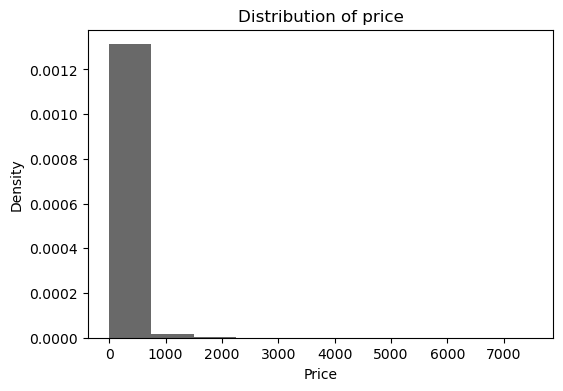

In [8]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.price, density = True, color="dimgray")
axes.set_title("Distribution of price")
axes.set_xlabel("Price")
axes.set_ylabel("Density")

plt.show()
plt.close()

In [9]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  11


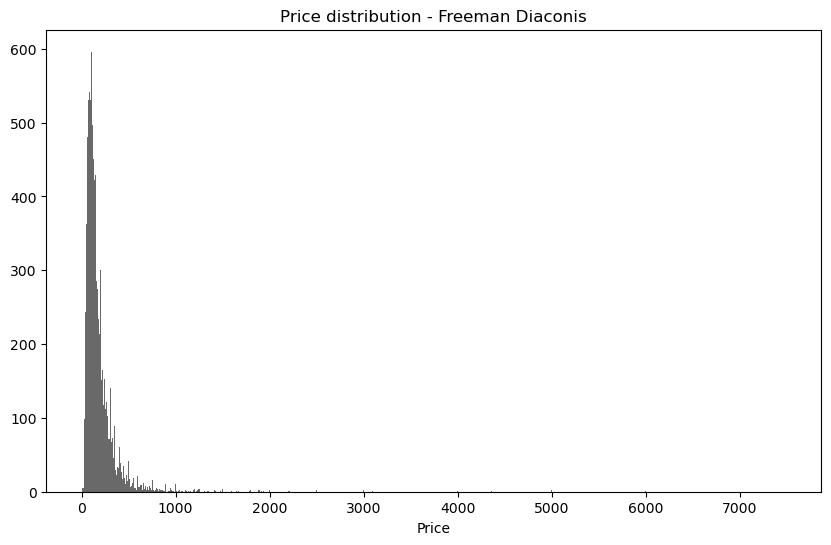

In [10]:
h = freeman_diaconis(vwListings.price)
print("Freeman Diaconis: ", h)
mn = int(vwListings.price.min())
mx = int(vwListings.price.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.price,bins=bins, color="DimGray")
axes.set_title("Price distribution - Freeman Diaconis")
axes.set_xlabel("Price")

plt.show()
plt.close()

As we expected, the distribution is positively skewed. This variable may fit Gaussian distribution. The majority of the price is under 500 dollars per night. It is so rare to have the price over 1,000 dollars per night. 

### Last scraped

`last_scraped` is the variable representing the date. As we can see, `last_scraped` is the object as this moment. We will need to convert it to date time before performing EDA.

In [11]:
for i in range(len(vwListings['MAX(last_scraped)'])):
    datetime_object = datetime.datetime.strptime(vwListings['MAX(last_scraped)'][i], "%Y-%m-%d")
    conversion = datetime_object.strftime("%Y-%m-%d")
    vwListings['MAX(last_scraped)'][i] = conversion

In [12]:
vwListings['MAX(last_scraped)']

0       2022-09-14
1       2023-03-19
2       2023-03-19
3       2023-03-19
4       2022-09-14
           ...    
8623    2023-03-19
8624    2023-03-19
8625    2023-03-19
8626    2023-03-19
8627    2023-03-19
Name: MAX(last_scraped), Length: 8628, dtype: object

In [13]:
year_2023 = 0
year_2022 = 0
year_2021 = 0
for i in range(len(vwListings['MAX(last_scraped)'])):
    d = pd.to_datetime(vwListings['MAX(last_scraped)'][i])
    if d.year >= 2023:
        year_2023 += 1
    elif d.year >= 2022:
        year_2022 += 1
    else:
        year_2021 += 1

by_year = [year_2022, year_2023]

In [14]:
print(f"There are {year_2023} observations that the most recent last scraped is 2023.")
print(f"There are {year_2022} observations that most recent last scraped is 2022.")
print("There are 0 observations that the most recent last scraped is 2021.")

There are 6455 observations that the most recent last scraped is 2023.
There are 2173 observations that most recent last scraped is 2022.
There are 0 observations that the most recent last scraped is 2021.


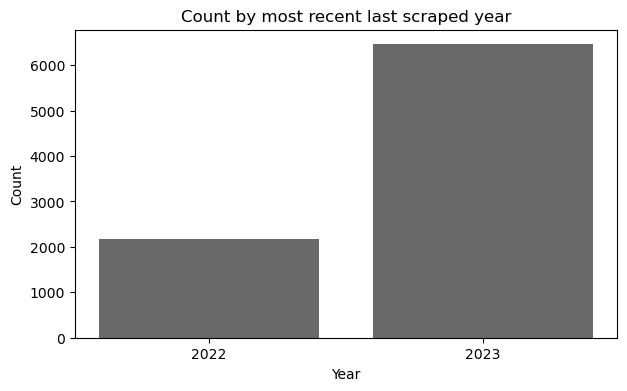

In [15]:
figure = plt.figure(figsize=(7,4))
axes = figure.add_subplot(1, 1, 1)
axes.bar(['2022', '2023'], by_year, color='DimGray')
axes.set_xlabel('Year')
axes.set_ylabel('Count')
axes.set_title('Count by most recent last scraped year')

plt.show()

Now, let's break down to the quarter level to see. Please note that our data set is in the range of the last 4 quarters. It means that it from Quarter 2 2022 to Q1 2023. Hence, we will break down to 4 quarters Q2 2022, Q3 2022, Q4 2022, Q1 2023.

In [16]:
q1_2023 = 0
q2_2022 = 0
q3_2022 = 0
q4_2022 = 0
for i in range(len(vwListings['MAX(last_scraped)'])):
    d = pd.to_datetime(vwListings['MAX(last_scraped)'][i])
    if d.year == 2023:
        q1_2023 += 1
    elif d.year == 2022:
        if d.quarter == 2:
            q2_2022 += 1
        elif d.quarter == 3:
            q3_2022 += 1
        elif d.quarter == 4:
            q4_2022 += 1        

quarter_year = [q2_2022, q3_2022, q4_2022, q1_2023]

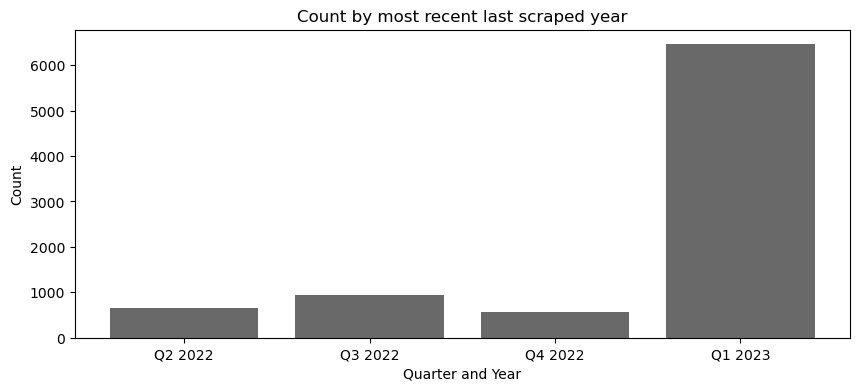

In [17]:
figure = plt.figure(figsize=(10,4))
axes = figure.add_subplot(1, 1, 1)
axes.bar(['Q2 2022', 'Q3 2022', 'Q4 2022', 'Q1 2023'], quarter_year, color='DimGray')
axes.set_xlabel('Quarter and Year')
axes.set_ylabel('Count')
axes.set_title('Count by most recent last scraped year')

plt.show()
plt.close()

The majority of the observed listings are from the 1st quarter in 2023 (over 6,000 listings). Approximately 500 listings are from the 4th quarter in 2022. Almost 1,000 listings are from the 3rd quarter in 2022. And over 500 listings were scraped in the 2nd quarter in 2022.

### Source

`source` is a categorical variable. We are not sure what it means. However, as we mentioned above, we surely know that there are some records missing data here. Let's take a look.

In [18]:
vwListings.source

0       city scrape
1       city scrape
2       city scrape
3       city scrape
4       city scrape
           ...     
8623    city scrape
8624    city scrape
8625    city scrape
8626    city scrape
8627    city scrape
Name: source, Length: 8628, dtype: object

In [19]:
vwListings.source.value_counts()

city scrape        6407
previous scrape    1566
NA                  655
Name: source, dtype: int64

In [20]:
vwListings.source.value_counts(normalize=True)

city scrape        0.742582
previous scrape    0.181502
NA                 0.075916
Name: source, dtype: float64

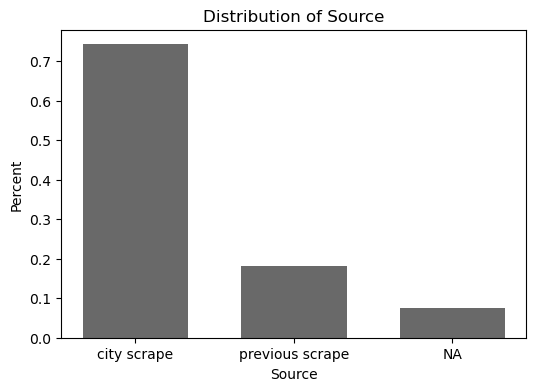

In [21]:
percent = vwListings.source.value_counts(normalize=True)
source = ['city scrape', 'previous scrape', 'NA']

figure = plt.figure(figsize=(6, 4))
axes = figure.add_subplot(1, 1, 1)
axes.bar(source, percent, width=1/1.5, align="center", color="dimgray")
axes.set_xticklabels(percent.axes[0])
axes.set_title("Distribution of Source")
axes.set_xlabel("Source")
axes.set_ylabel("Percent")

plt.show()
plt.close()

The majority of sources are city scrape (accountable over 70%) while some of them are previous scrape (approximately almost 20%). We have less than 10% number of observations that are null.

### Host since

`host_since` is another datetime variable. To generalize the idea, we will use `host_since` to compute the number of year of being an airbnb host. We hypothesize that the data of `host_since` may fit the Gaussian distribution. However, the distribution will be negatively skewed. However, if we compute the number of years of being an airbnb host, the data may fit Gaussian distribution but skewed right.

In [22]:
vwListings['host_since']

0       2008-11-22
1       2008-11-26
2       2008-12-12
3       2008-12-12
4       2008-12-27
           ...    
8623    2013-10-07
8624    2017-07-13
8625    2018-03-07
8626    2021-02-26
8627    2023-03-17
Name: host_since, Length: 8628, dtype: object

In [23]:
# convert the data to date time data type
vwListings['host_since'] = pd.to_datetime(vwListings['host_since'])

In [24]:
null_counts = 0
for i in range(len(vwListings['host_since'])):
    if pd.isna(vwListings['host_since'][i]) == True:
        null_counts += 1
print(f"There are {null_counts} null records in host_since variable.")

There are 20 null records in host_since variable.


When we were computing the number of years being an airbnb host, we found out that this variable contains 20 null records. We will exclude 20 null records for now. Then, we will compute the number of years of being an airbnb host. We will use 04-15-2023 as today date.

In [25]:
today = pd.to_datetime('2023-04-15')
starting_year = []
host_years = []
for i in range(len(vwListings['host_since'])):
    if pd.isna(vwListings['host_since'][i]) == False:
        starting_year.append(vwListings['host_since'][i].year)
        diff = int(((today - vwListings['host_since'][i]).days) / 365)
        host_years.append(diff)
    else:
        continue

In [26]:
starting_year_counter = Counter(starting_year)
host_years_counter = Counter(host_years)

In [27]:
vwListings['host_since'].value_counts()

2019-09-13    320
2020-07-29    265
2016-12-16    264
2015-07-29    198
2015-11-02    150
             ... 
2010-09-27      1
2010-09-17      1
2012-04-25      1
2012-11-28      1
2023-03-17      1
Name: host_since, Length: 2490, dtype: int64

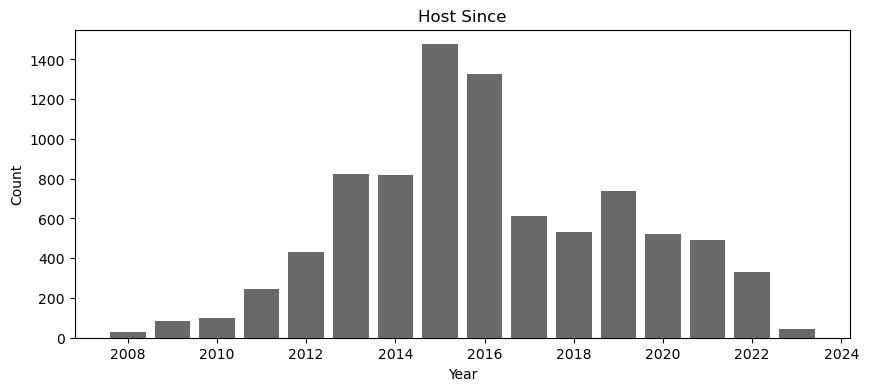

In [28]:
figure = plt.figure(figsize=(10, 4))
axes = figure.add_subplot(1, 1, 1)
axes.bar(starting_year_counter.keys(), starting_year_counter.values(), color='DimGray')
axes.set_xlabel('Year')
axes.set_ylabel('Count')
axes.set_title('Host Since')
plt.show()

As our expectation, the data of `host_since` is skewed left. There are not many hosts starting being an airbnb host in 2008. The majority of the hosts starting the airbnb in 2015 and 2016 in this data set. There are two peak points in this distribution. The first one is in 2015 and the second one is in 2019.

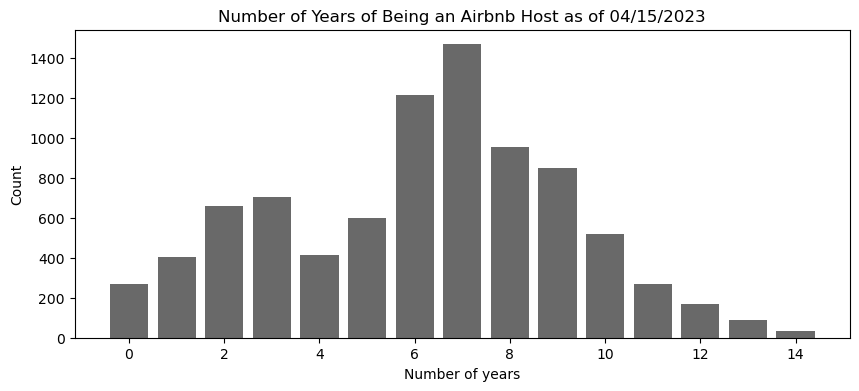

In [29]:
figure = plt.figure(figsize=(10, 4))
axes = figure.add_subplot(1, 1, 1)
axes.bar(host_years_counter.keys(), host_years_counter.values(), color='DimGray')
axes.set_xlabel('Number of years')
axes.set_ylabel('Count')
axes.set_title('Number of Years of Being an Airbnb Host as of 04/15/2023')

plt.show()
plt.close()

The majority of the hosts in the most_recent_listings view have 7 years of being an airbnb host. The other two next are 6 years and 8 years. 14 years are the longest time of being an airbnb host in this data set. And there are not many hosts having 14 years of experience. Basically, it is rare to see the hosts having at 11 years and above in this view. 

As we expected, if we use `host_since` to calculate the number of years of being an airbnb host as of 04/15/2023, the data may fit Gaussian distribution but skewed right. Similarly, there are two peak point in this distribution. Basically, these two distributions above are just opposite reflection of each other.

### Host location

`host_location` is the categorical variable. It reflects the location of the host. Let's see how many host lives locally and how many hosts lives outside of Washington DC.

In [30]:
vwListings.host_location

0        Arlington, VA
1       Washington, DC
2       Washington, DC
3       Washington, DC
4       Washington, DC
             ...      
8623    Washington, DC
8624    Washington, DC
8625                  
8626                  
8627                  
Name: host_location, Length: 8628, dtype: object

In [31]:
vwListings.host_location.value_counts(normalize=True)

Washington, DC                                     0.565484
                                                   0.164349
New York, NY                                       0.040218
Houston, Texas, United States                      0.030482
Washington, District of Columbia, United States    0.021790
                                                     ...   
West Bloomfield Township, MI                       0.000116
West Hollywood, CA                                 0.000116
Honolulu, HI                                       0.000116
Magnolia, DE                                       0.000116
Beverly Hills, CA                                  0.000116
Name: host_location, Length: 299, dtype: float64

It looks like there are 16% null records here. The top 3 areas that the host lives are Washington DC (local), New York and Houston, Texas with 56%, 4%, and 3% respectively. Some places such as Honolulu, Magnolia, DE or Beverly Hills, CA, etc. have the lowest number of hosts living there. So far, from this statistics, we can say that the majority of the hosts lives locally.

### Host response time

`host_response_time` is a categorical variable which represents the response time of the host. According to Airbnb, the response time is the average time it took the host to respond to any messages over the last 30 days. We are not sure how many unique values in this variable. However, we expect the majority of the hosts will response within an hour or two.

In [32]:
vwListings.host_response_time

0                      N/A
1       within a few hours
2           within an hour
3           within an hour
4                      N/A
               ...        
8623        within an hour
8624    within a few hours
8625                   N/A
8626        within an hour
8627                   N/A
Name: host_response_time, Length: 8628, dtype: object

In [33]:
percent = vwListings.host_response_time.value_counts(normalize=True)
percent

within an hour        0.623899
N/A                   0.170723
within a few hours    0.127376
within a day          0.065137
a few days or more    0.010547
                      0.002318
Name: host_response_time, dtype: float64

It looks like there are 4 different unique values here and 0.02% of total number of records are null. The interesting thing here is that we do not know whether "N/A" and null value are the same meaning or different. However, we will create the bar chart to reflect the difference between each value. Because this variable is ordinal variable. The order from shortest to longest is "within an hour", "within a few hours", "within a day", "a few days or more". By that order, we expect the data may fit Gamma distribution.

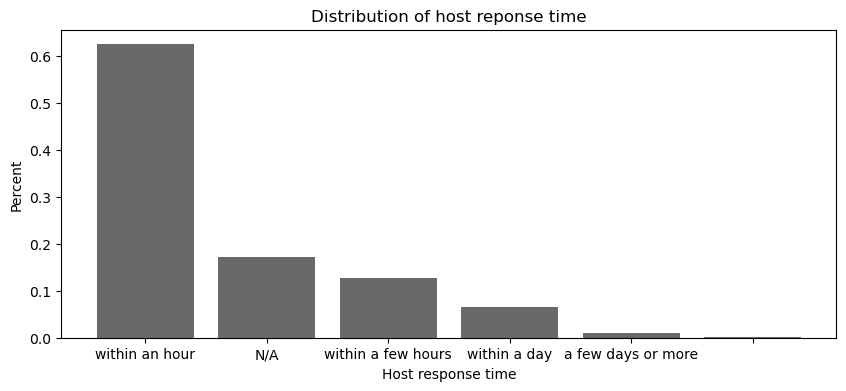

In [34]:
percent = vwListings.host_response_time.value_counts(normalize=True)
response_time = ["within an hour", "N/A", "within a few hours", "within a day", "a few days or more" , " "]

figure = plt.figure(figsize=(10, 4))
axes = figure.add_subplot(1, 1, 1)
axes.bar(response_time, percent, align="center", color="dimgray")
axes.set_xticklabels(percent.axes[0])
axes.set_title("Distribution of host reponse time")
axes.set_xlabel("Host response time")
axes.set_ylabel("Percent")

plt.show()
plt.close()

As we expected, most of the hosts responded within an hour (over 60%). Besides, N/A, some hosts responded within a few hour (around 18%). It is rare to see the hosts responded a few days or more. In other words, in this view, the majority of the hosts are pretty responsive.

### Host response rate

`host_response_rate` seems like a numeric variable. According to Airbnb, host response rate reflects the percentage of booking requests and enquiries the host has responded to within 24 hours over the past 30 days. Host response rate is most important, as it affects where the property ranks in search results and also impacts host superhost status. 

In [35]:
vwListings.host_response_rate

0        N/A
1       100%
2       100%
3       100%
4        N/A
        ... 
8623     70%
8624    100%
8625     N/A
8626     92%
8627     N/A
Name: host_response_rate, Length: 8628, dtype: object

This variable contains some N/A records. Let's see how many N/A records are there.

In [36]:
na_counts = 0
for i in range(len(vwListings.host_response_rate)):
    if vwListings['host_response_rate'][i] == 'N/A':
        na_counts += 1
    else:
        continue
        
print(f"In {len(vwListings.host_response_rate)} records, there are {na_counts} records with N/A host response rate in this view.")

In 8628 records, there are 1473 records with N/A host response rate in this view.


We will exclude 1473 N/A records for now. Excluding all N/A values, we hypothesize this variable may fit Gamma distribution if the host response rate is descending.

 

In [37]:
response_rate = []
for i in range(len(vwListings.host_response_rate)):
    if vwListings['host_response_rate'][i] != 'N/A':
        vwListings['host_response_rate'][i] = vwListings['host_response_rate'][i].replace('%', '')
        vwListings['host_response_rate'][i] = pd.to_numeric(vwListings['host_response_rate'][i])
        response_rate.append(pd.to_numeric(vwListings['host_response_rate'][i]))
    else:
        continue

In [38]:
response_rate_df = pd.DataFrame(response_rate)
response_rate_df.describe()

,0
count,7135.000000
mean,96.885774
std,11.191166
min,0.000000
25%,100.000000
50%,100.000000
75%,100.000000
max,100.000000


The mean host response rate is 96%. The minimum and the maximum host response rate are 0% and 100% respectively. Based on the statistics above, if the host response rate is descending, the data possibly fit Gamma distribution.

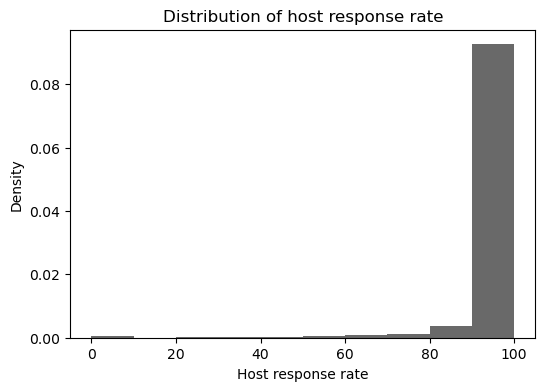

In [39]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.hist(response_rate, density = True, color="dimgray")
axes.set_title("Distribution of host response rate")
axes.set_xlabel("Host response rate")
axes.set_ylabel("Density")

plt.show()
plt.close()

Around 95% of the host response rate are 90% and above. It means that the host is pretty responsive, similar to what we explored in the `host_response_time`.

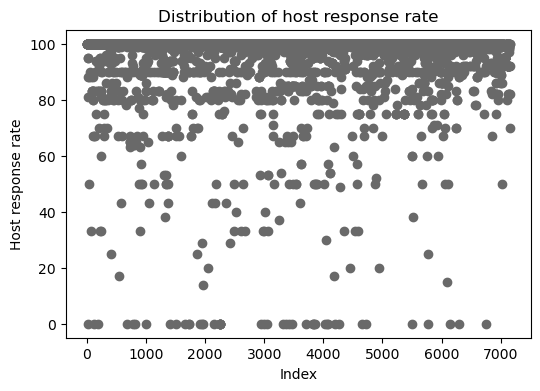

In [40]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.plot(response_rate, 'o', color="dimgray")
axes.set_title("Distribution of host response rate")
axes.set_xlabel("Index")
axes.set_ylabel("Host response rate")

plt.show()
plt.close()

This plot obviously showed that the majority of the listings have the high responsive host. The host response rate is 80% and above. However, there are some listings that the host is not responsive at all, 0%. It's kinda strange to see that there are some hosts have 0% response rate. We will check how many of them.

In [41]:
count = (vwListings['host_response_rate'] == 0).sum()

print(f"There are {count} listings having 0% host response rate.")

There are 46 listings having 0% host response rate.


We would like to see if those hosts have an available Airbnb properties.

In [42]:
count = ((vwListings['host_response_rate'] == 0) & (vwListings['has_availability'] == 't')).sum()
print(f"All {count} hosts having 0% response rate actually still have an unavailable Airbnb property.")

All 46 hosts having 0% response rate actually still have an unavailable Airbnb property.


### Host acceptance rate

`host_acceptance_rate` is the boolean variable. Host acceptance rate measures how often the host accepts or decline reservations. Guest inquiries are not included in the calculation of host acceptance rate.

In [43]:
vwListings.host_acceptance_rate

0        N/A
1       100%
2        82%
3        96%
4        62%
        ... 
8623     39%
8624     76%
8625     N/A
8626    100%
8627     N/A
Name: host_acceptance_rate, Length: 8628, dtype: object

Similar to `host_response_rate`, `host_acceptance_rate` consists of some N/A values. We will count how many N/A values in this variable.

In [44]:
na_counts = 0
for i in range(len(vwListings.host_acceptance_rate)):
    if vwListings['host_acceptance_rate'][i] == 'N/A':
        na_counts += 1
    else:
        continue
        
print(f"In {len(vwListings.host_acceptance_rate)} records, there are {na_counts} records with N/A host acceptance rate in this view.")

In 8628 records, there are 1073 records with N/A host acceptance rate in this view.


Compared to `host_response_rate`, `host_acceptance_rate` has fewer N/A values. We will temporarily exclude these N/A values for now.

In [45]:
acceptance_rate = []
for i in range(len(vwListings.host_acceptance_rate)):
    if vwListings['host_acceptance_rate'][i] != 'N/A':
        vwListings['host_acceptance_rate'][i] = vwListings['host_acceptance_rate'][i].replace('%', '')
        vwListings['host_acceptance_rate'][i] = pd.to_numeric(vwListings['host_acceptance_rate'][i])
        acceptance_rate.append(pd.to_numeric(vwListings['host_acceptance_rate'][i]))
    else:
        continue

In [46]:
acceptance_rate_df = pd.DataFrame(acceptance_rate)
acceptance_rate_df.describe()

,0
count,7535.000000
mean,88.742004
std,20.211526
min,0.000000
25%,89.000000
50%,97.000000
75%,100.000000
max,100.000000


The mean acceptance rate is 88% while the median acceptance rate is 97%. The minimum and the maximum acceptance rate are 0% and 100%. Let's see how many listings having 0% acceptance rate.

In [47]:
count = (vwListings['host_acceptance_rate'] == 0).sum()

print(f"There are {count} listings having 0% host acceptance rate.")

There are 101 listings having 0% host acceptance rate.


Let's check if 101 listings belong to the brand new hosts. Let's just assume the brand new hosts are people starting being an Airbnb host in March 2023.

In [48]:
count = 0
for i in range(len(vwListings['host_acceptance_rate'])):
    if pd.isna(vwListings['host_since'][i]) == False:
        d = pd.to_datetime(vwListings['host_since'][i])
        if ((vwListings['host_acceptance_rate'] == 0) & (d.year == 2023) & d.month == 3).all == True:
            count += 1
        else:
            continue
    else:
        continue

print(f"There are {count} listings having 0% host acceptance rate and belonging to brand new hosts.")

There are 0 listings having 0% host acceptance rate and belonging to brand new hosts.


The records with 0% host acceptance rate are hosts who have been being an Airbnb host before March 2023. We do not know why those hosts have 0% acceptance rate. This strange thing needs to be noted.

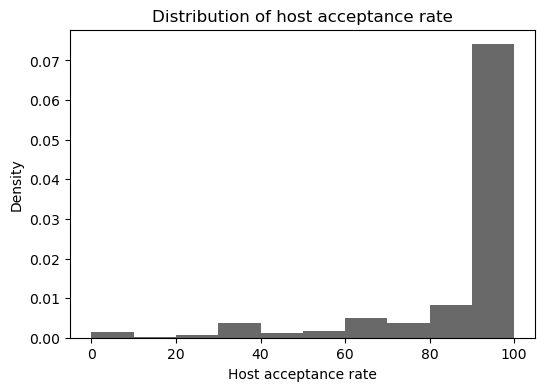

In [49]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.hist(acceptance_rate, density = True, color="dimgray")
axes.set_title("Distribution of host acceptance rate")
axes.set_xlabel("Host acceptance rate")
axes.set_ylabel("Density")

plt.show()
plt.close()

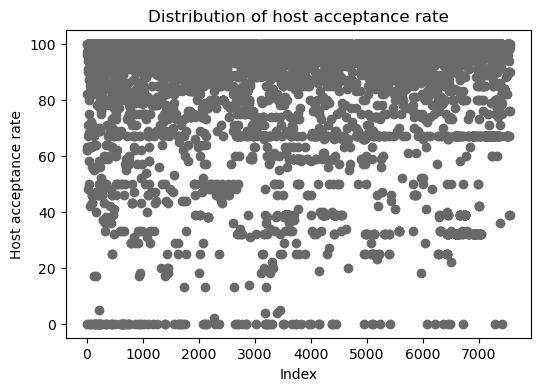

In [50]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.plot(acceptance_rate, 'o', color="dimgray")
axes.set_title("Distribution of host acceptance rate")
axes.set_xlabel("Index")
axes.set_ylabel("Host acceptance rate")

plt.show()
plt.close()

The majority of the hosts have a high acceptance rate, around 80% and above. However, we still see some hosts are pretty picky. Their acceptance rate can be as low as 5% (beside 0%).

### Host is superhost

`host_is_superhost` is the boolean variable. It indicates whether the host is superhost. According to Airbnb, to become an superhost, the host has to be qualified as follows:
1. Completed at least 10 trips or 3 reservations that total at least 100 nights
2. Maintained a 90% response rate or higher
3. Maintained a less than 1% cancellation rate, with exceptions made for those that fall under our Extenuating Circumstances policy
4. Maintained a 4.8 overall rating (A review counts towards Superhost status when either both the guest and the Host have submitted a review, or the 14-day window for reviews is over, whichever comes first).

In [51]:
count = vwListings['host_is_superhost'].value_counts(normalize=True)
count

f    0.716852
t    0.282684
     0.000464
Name: host_is_superhost, dtype: float64

It looks like this variable also contains 0.04% null values. We will ignore these null values for now.

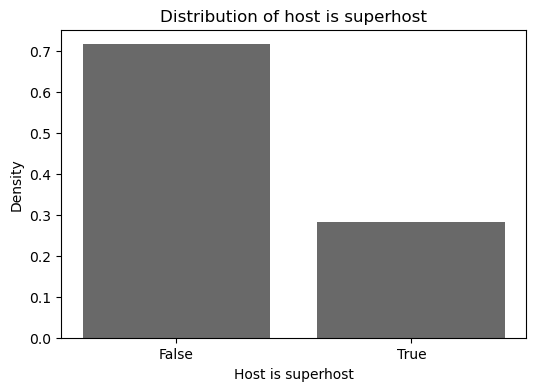

In [52]:
x = ['False', 'True']
y = [count[0], count[1]]

figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, y, color="dimgray")
axes.set_title("Distribution of host is superhost")
axes.set_xlabel("Host is superhost")
axes.set_ylabel("Density")

plt.show()
plt.close()

In this view, there are more not-a-superhost than superhost. Not-a-superhost is approximately 3 times higher than a superhost.

### Host neighbourhood

`host_neighbourhood` is the categorical value indicating the neighborhood of the host.

In [53]:
vwListings.host_neighbourhood

0                                         
1                                Anacostia
2                                Eckington
3                             Capitol Hill
4                                         
                       ...                
8623                           Glover Park
8624    Central Northeast/Mahaning Heights
8625                  Northwest Washington
8626                  Northeast Washington
8627                  Northwest Washington
Name: host_neighbourhood, Length: 8628, dtype: object

In [54]:
vwListings.host_neighbourhood.value_counts()

Northwest Washington         1189
Northeast Washington          891
                              574
Capitol Hill                  474
Cambridge                     403
                             ... 
Old Soldiers' Home              1
Edmonston/Bladensburg, MD       1
Pepper Mill Village             1
Central LA                      1
Holborn                         1
Name: host_neighbourhood, Length: 248, dtype: int64

As we can see, the majority of the neighbors is in Northwest Washington and Northeast Washington while only 1 listing in Holborn, Central LA, or Pepper Mill Village.

### Host listings count

`host_listings_count` is the numeric variable indicating the number of listings of one host.

In [55]:
vwListings.host_listings_count

0        1
1        1
2        5
3        1
4        2
        ..
8623     5
8624     9
8625     1
8626    82
8627     1
Name: host_listings_count, Length: 8628, dtype: object

In [56]:
vwListings.host_listings_count = pd.to_numeric(vwListings['host_listings_count'])
vwListings.host_listings_count.describe()

count    8608.000000
mean      240.208178
std       858.316797
min         0.000000
25%         1.000000
50%         3.000000
75%        36.000000
max      4807.000000
Name: host_listings_count, dtype: float64

The mean value of listing count is 240 which is pretty high. The minimum listing count is 0 while the maximum listing count is 4,807. The median value is 3. Based on the statistics above, the mean value is higher the median value. Therefore, we would expect to have a right skewed distribution and it is possibly a Gaussian distribution.

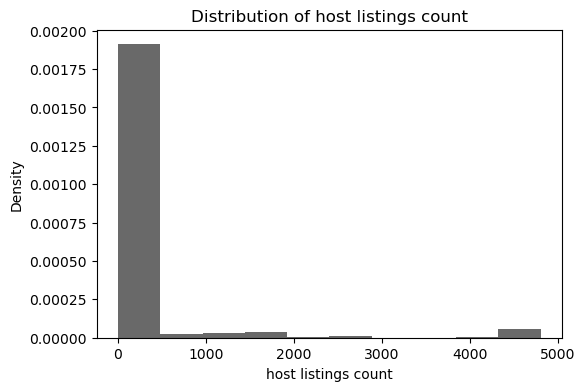

In [57]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings['host_listings_count'], density = True, color="dimgray")
axes.set_title("Distribution of host listings count")
axes.set_xlabel("host listings count")
axes.set_ylabel("Density")

plt.show()
plt.close()

The majority of the hosts have less 50 listings on the Airbnb website.

### Host total listings count

`host_total_listings_count` is the numeric variable indicating the number of total listing counts by each host.

In [58]:
vwListings.host_total_listings_count.value_counts()

1      1924
2      1116
3       649
4       502
5       381
       ... 
77        1
138       1
307       1
33        1
175       1
Name: host_total_listings_count, Length: 127, dtype: int64

In [59]:
vwListings.host_total_listings_count = pd.to_numeric(vwListings['host_total_listings_count'])
vwListings.host_total_listings_count.describe()

count    8608.000000
mean      343.113267
std      1176.505631
min         0.000000
25%         2.000000
50%         5.000000
75%        45.000000
max      8342.000000
Name: host_total_listings_count, dtype: float64

The mean value of total listing count is 343. The minimum listing count is 0 while the maximum listing count is 8,342. The median value is 5. Based on the statistics above, the mean value is higher the median value. Therefore, we would expect to have a right skewed distribution and it is possibly a Gaussian distribution.

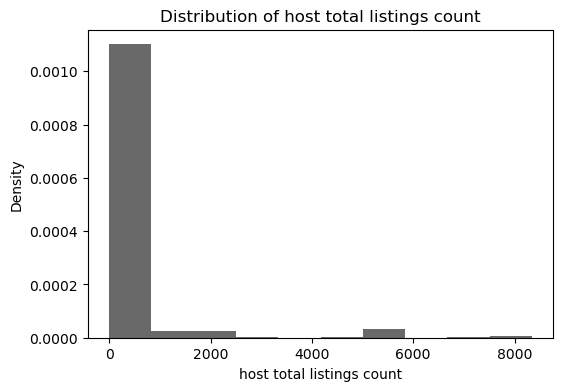

In [60]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings['host_total_listings_count'], density = True, color="dimgray")
axes.set_title("Distribution of host total listings count")
axes.set_xlabel("host total listings count")
axes.set_ylabel("Density")

plt.show()
plt.close()

The distribution of `host_listing_count` and `host_total_listing_count` are pretty similar. The majority of the hosts have less than 700 total listing counts.

### Host verifications

`host_verifications` is categorical variable. We will see what the values are in this variable.

In [61]:
vwListings.host_verifications

0                     ['email', 'phone']
1       ['email', 'phone', 'work_email']
2                     ['email', 'phone']
3                     ['email', 'phone']
4                     ['email', 'phone']
                      ...               
8623                  ['email', 'phone']
8624    ['email', 'phone', 'work_email']
8625                  ['email', 'phone']
8626                  ['email', 'phone']
8627                  ['email', 'phone']
Name: host_verifications, Length: 8628, dtype: object

In [62]:
vwListings.host_verifications.value_counts(normalize=True)

['email', 'phone']                  0.720561
['email', 'phone', 'work_email']    0.215229
['phone']                           0.058762
['phone', 'work_email']             0.003013
None                                0.002318
['email']                           0.000116
Name: host_verifications, dtype: float64

72% of the hosts used both email and phone as host verifications. 21% of the hosts used email, phone and work email to verify themselves. Only 0.1% of the hosts used only email to verify themselves. And 0.2% of the hosts do not use any methods to verify themselves. We do not think this variable have an impact on the model where the target variable is `price`.

### Host has profile pic

`host_has_profile_pic` is the boolean variable. It indicates whether the host has profile picture.

In [63]:
vwListings.host_has_profile_pic

0       t
1       t
2       t
3       t
4       t
       ..
8623    t
8624    t
8625    t
8626    t
8627    t
Name: host_has_profile_pic, Length: 8628, dtype: object

In [64]:
count = vwListings.host_has_profile_pic.value_counts(normalize=True)
count

t    0.988178
f    0.009504
     0.002318
Name: host_has_profile_pic, dtype: float64

There are 0.2% null values in this variable while there are up to 99% of the hosts have their profile picture. Only 0.9% of the hosts have no profile picture.

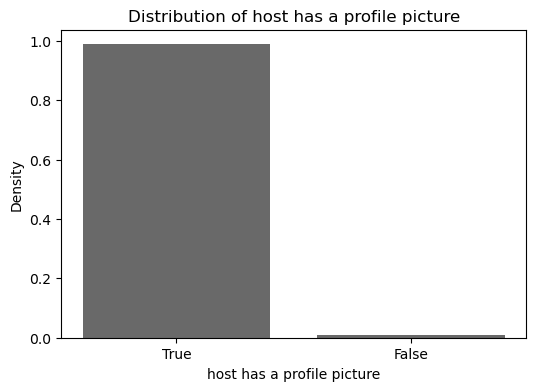

In [65]:
x = ['True', 'False']
y = [count[0], count[1]]

figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, y, color="dimgray")
axes.set_title("Distribution of host has a profile picture")
axes.set_xlabel("host has a profile picture")
axes.set_ylabel("Density")

plt.show()
plt.close()

It is so common to see the host with their a profile picture in this view.

### Host identity verified

`host_identity_verified` is another boolean variable. It indicates whether the host identity is verified by Airbnb.

In [66]:
count = vwListings.host_identity_verified.value_counts(normalize=True)
count

t    0.874478
f    0.123204
     0.002318
Name: host_identity_verified, dtype: float64

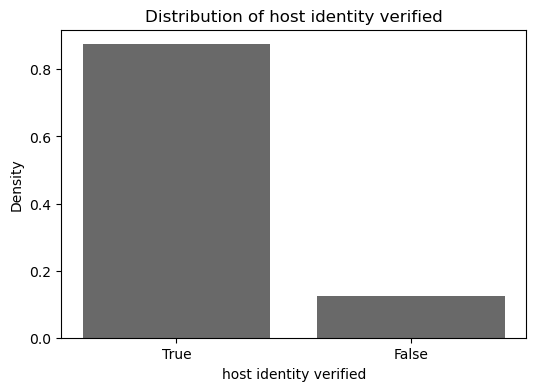

In [67]:
x = ['True', 'False']
y = [count[0], count[1]]

figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, y, color="dimgray")
axes.set_title("Distribution of host identity verified")
axes.set_xlabel("host identity verified")
axes.set_ylabel("Density")

plt.show()
plt.close()

There are more hosts with their identity verified than the hosts who have not, 87% versus 12%.

### Neighbourhood

Neighbourhood is a categorical variable which represents the neighbourhood that the Airbnb listings resides in. Domain knowledge would lead us to believe that it affects the price of an Airbnb where desirable and in-demand neighbourhoods would have higher prices and neighbourhoods with less to do and higher crime rate would have lower prices.

In [68]:
tempDF = vwListings
tempDF["neighbourhood"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['neighbourhood'], inplace=True)

In [69]:
tempDF["neighbourhood"].describe()

count                                                5551
unique                                                 31
top       Washington, District of Columbia, United States
freq                                                 5032
Name: neighbourhood, dtype: object

There are 31 unique neighborhoods in the DC dataset for Airbnb listings. The most frequent count is Washington D.C. which has 5032 listings within the neighbourhood.

In [70]:
pd.DataFrame(tempDF["neighbourhood"].value_counts())

,neighbourhood
"Washington, District of Columbia, United States",5032
"Arlington, Virginia, United States",160
"Silver Spring, Maryland, United States",93
"Takoma Park, Maryland, United States",49
"Washington, D.C., District of Columbia, United States",38
"Capitol Heights, Maryland, United States",35
"Chevy Chase, Maryland, United States",35
"Bethesda, Maryland, United States",24
"Oxon Hill, Maryland, United States",22
"Hyattsville, Maryland, United States",14


The most frequent count is Washington D.C. which has 5032 listings within the neighbourhood. The next most is Arlington Virginia with 160 listings in the neighbourhood. There is potential for noise in this column as there is a listing that just says ", United States" and another listing with a duplicate Washington, DC. Aditionally, there are some listings with Washington, United States and Virginia, United States. These values have potential to create noise.

### Neighbourhood cleansed

Neighbourhood_cleansed is a much more useful variable than neighborhood as it corresponds with the neighbourhood table in the Airbnb data. It is the neighbourhood as geoencoded using the latitude and longitude against neighbourhoods as defined by open or public digital shapefiles. While neighbourhood has duplicate neighbourhood values as well as vague value such as ", United States", neighbourhood_cleansed has specific neighbourhoods of Washington D.C. and have grouped them by proximity of one another. This would be much more useful in terms of determining a correlation of price as there is much less noise in this column. Domain knowledge would lead us to believe that it affects the price of an Airbnb where desirable and in-demand neighbourhoods would have higher prices and neighbourhoods with less to do and higher crime rate would have lower prices.

In [71]:
tempDF = vwListings
tempDF["neighbourhood_cleansed"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['neighbourhood_cleansed'], inplace=True)

In [72]:
tempDF["neighbourhood_cleansed"].describe()

count                                          5551
unique                                           39
top       Union Station, Stanton Park, Kingman Park
freq                                            622
Name: neighbourhood_cleansed, dtype: object

As it corresponds with the neighbourhood table, there are 39 unique neighbourhoods in Washington D.C. under the Airbnb listings data. The top neighbourhood is Union Station, Stanton Park, Kingman Park with 622 listings in the neighbourhood.

In [73]:
pd.DataFrame(tempDF["neighbourhood_cleansed"].value_counts())

,neighbourhood_cleansed
"Union Station, Stanton Park, Kingman Park",622
"Capitol Hill, Lincoln Park",508
"Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View",394
"Dupont Circle, Connecticut Avenue/K Street",376
"Edgewood, Bloomingdale, Truxton Circle, Eckington",365
"Shaw, Logan Circle",288
"Brightwood Park, Crestwood, Petworth",282
"Georgetown, Burleith/Hillandale",234
"Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street",212
"Howard University, Le Droit Park, Cardozo/Shaw",198


### Property type

In [74]:
pt = vwListings['property_type']

We first look at a description of <b><i>property_type</i></b>:

In [75]:
pd.DataFrame(pt.describe())

,property_type
count,5551
unique,45
top,Entire rental unit
freq,2095


There are 53 unique property types. We take a closer look at the values and their counts:

In [76]:
pd.DataFrame(pt.value_counts(normalize=True))

,property_type
Entire rental unit,0.377409
Entire home,0.110611
Entire townhouse,0.082508
Entire guest suite,0.079445
Private room in home,0.075662
Entire condo,0.070978
Private room in townhouse,0.045758
Entire serviced apartment,0.037471
Private room in rental unit,0.035669
Room in hotel,0.015132


"Entire rental unit" is by far the most common value, comprising 32.7% of the data. "Entire home" is next with 10.8%, followed by "Private room in home" at 8.7%. 

We can see some clear groupings in these variables based on their first word:

<ul>
    <li>"Entire": "Entire rental unit", "Entire home", ... , "Entire cottage"</li>
    <li>"Private": "Private room in home", "Private room in rental unit", ... , "Private room in bungalow"</li>
    <li>"Room": "Room in boutique hotel", "Room in hotel", ... , "Room in serviced apartment"</li>
    <li>"Shared": "Shared room in rental unit", "Shared room in townhouse", ... , "Shared room in bed and breakfast"</li>
    <li>Other: "Tiny home", "Camper/RV", ... , "Campsite"</li>
</ul>

### Room type

In [77]:
rt = vwListings['room_type']

We first look at a description of <b><i>room_type</i></b>:

In [78]:
pd.DataFrame(rt.describe())

,room_type
count,5551
unique,4
top,Entire home/apt
freq,4350


There are only 4 room types. We display the value counts:

In [79]:
pd.DataFrame(rt.value_counts(normalize=True))

,room_type
Entire home/apt,0.783643
Private room,0.201946
Shared room,0.011349
Hotel room,0.003063


"Entire home/apt" is by far the most common value, comprising 74.8% of the data. "Private room" is next, with 23.5% of the data. "Shared room" and "Hotel room" are pretty rare, with 1.4% and 0.2% of the data, respectively. These groups map on pretty well to the groups that were found in property_type, though the Other category has been distributed among the rest.

There does appear to be a problem, though. 1.1% of the listings have property_type = 'Room in hotel', yet only 0.3% of the listings have room_type = 'Hotel room'. This is likely due to mistakes in room_type, but we will revisit this issue in pairwise EDA.

### Accommodates

Accommodates describes the number of people that an Airbnb can accommodate. In other words this is the maximum capacity of the listing. This is a ordered numerical variable and would lead us to believe that it would affect the listing's price. The more a listing can accommodate, the higher the price of the Airbnb due to factors such as size, resources provided, and number of guests who can split the price of the Airbnb.

In [80]:
tempDF = vwListings
tempDF["accommodates"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['accommodates'], inplace=True)

In [81]:
tempDF["accommodates"].describe()

count    5551.000000
mean        3.770852
std         2.399719
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        16.000000
Name: accommodates, dtype: float64

In [82]:
tempDF["accommodates"].value_counts().sort_index()

1      468
2     1725
3      668
4     1260
5      370
6      532
7       88
8      213
9       31
10      78
11      12
12      58
13       6
14      12
15       5
16      25
Name: accommodates, dtype: int64

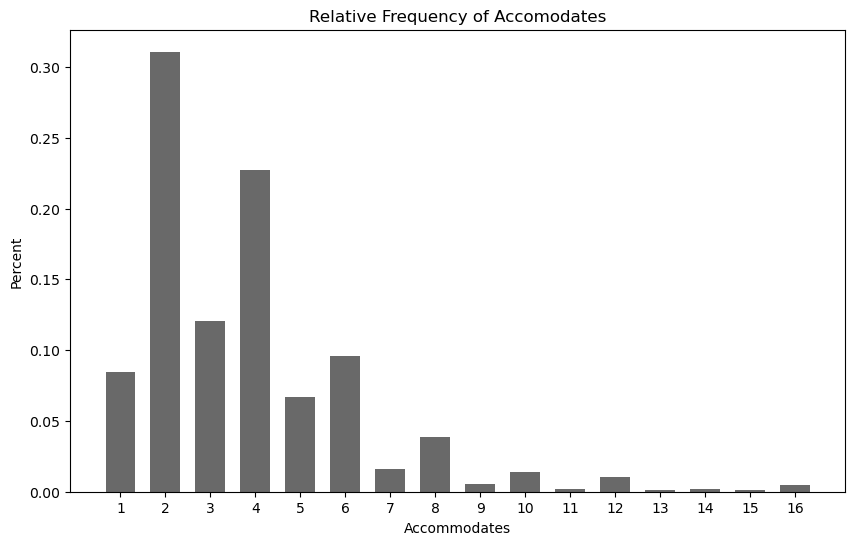

In [83]:
counts = tempDF["accommodates"].value_counts().sort_index()
proportions = tempDF["accommodates"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Accommodates")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of Accomodates")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

### Bathrooms text

Bathrooms_text corresponds to the number of bathrooms in an Airbnb listing. It is a string type variable which makes it a categorical variable. For our analysis we extracted the number of bathrooms and made it a numerical variable in the bathroom_numbers column via a regular expression. Domain knowledge would lead us to believe that more bathrooms would positively affect the price of a listing. As opposed to being less bathrooms which would lead the price to be less.

In [84]:
tempDF = vwListings
tempDF["bathrooms_text"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['bathrooms_text'], inplace=True)

In [85]:
tempDF['bathroom_numbers'] = tempDF['bathrooms_text'].str.extract('(\d+)')

In [86]:
tempDF["bathroom_numbers"].describe()

count     5548
unique      10
top          1
freq      4205
Name: bathroom_numbers, dtype: object

In [87]:
pd.DataFrame(tempDF["bathroom_numbers"].value_counts())

,bathroom_numbers
1,4205
2,968
3,241
4,64
0,52
5,12
11,2
7,2
6,1
15,1


Overall, most listings have only 1 bathroom while the next most have only 2 bathrooms. The third most listings have 1 shared bath followed by listings with 2.5 baths. There are outlier values such as 11 shared baths, 0 baths, and 15 baths in an Airbnb listing.

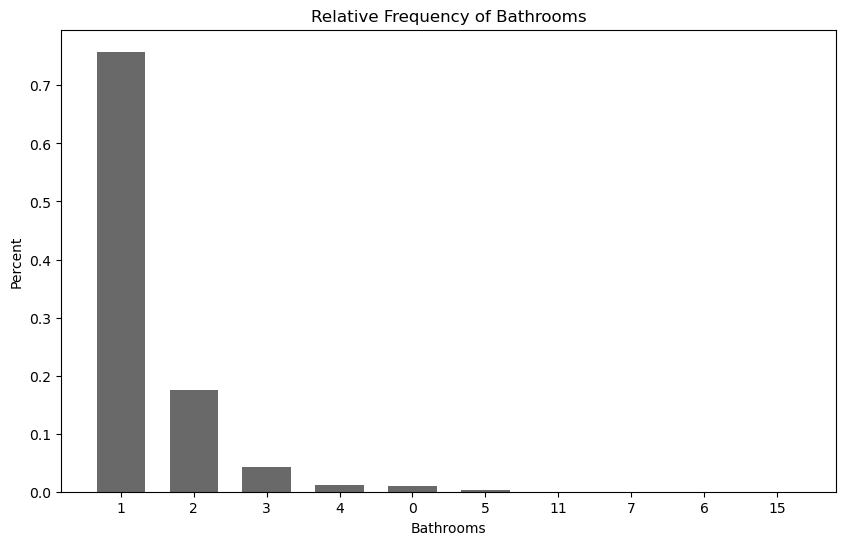

In [88]:
counts = tempDF["bathroom_numbers"].value_counts().sort_index()
proportions = tempDF["bathroom_numbers"].value_counts(normalize=True)
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Bathrooms")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of Bathrooms")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

### Bedrooms

bedrooms is a numerical variable that corresponds to the number of bedrooms in an Airbnb listing. It is a key feature of an Airbnb and based on our domain knowledge would suggest that it significant affects the price of it. With more bedrooms, the price of the Airbnb listing would increase.

In [89]:
tempDF = vwListings
tempDF["bedrooms"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['bedrooms'], inplace=True)

In [90]:
tempDF["bedrooms"].describe()

count    5097.000000
mean        1.639200
std         1.031441
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        15.000000
Name: bedrooms, dtype: float64

When we look at the descriptive statistics of number of bedrooms in an Airbnb listing, the first thing we notice is that the extreme maximum value of 15 bedrooms is much more extreme than most of the distribution of bedrooms. Each Airbnb has at least 1 bedroom but the majority of listings in the Airbnb data contain only 1 to 2 bedrooms, given that the 75% quartile is 2 bedrooms. The mean number of bedrooms is 1.65 and the median is one bedroom.

In [91]:
tempDF["bedrooms"].value_counts().sort_index()

1.0     3161
2.0     1122
3.0      479
4.0      218
5.0       84
6.0       22
7.0        7
8.0        2
9.0        1
15.0       1
Name: bedrooms, dtype: int64

Taking a look at the value counts, only one listing has 15 bedrooms while 1 listing has 9 bedrooms. A majority of listings have 1 and 2 bedrooms which correspond to the descriptive statistics. Additionally, there are a sizeable number of Airbnb listings with 3-5 bedrooms with 429, 218 and 84 listings respectively with these number of bedrooms.

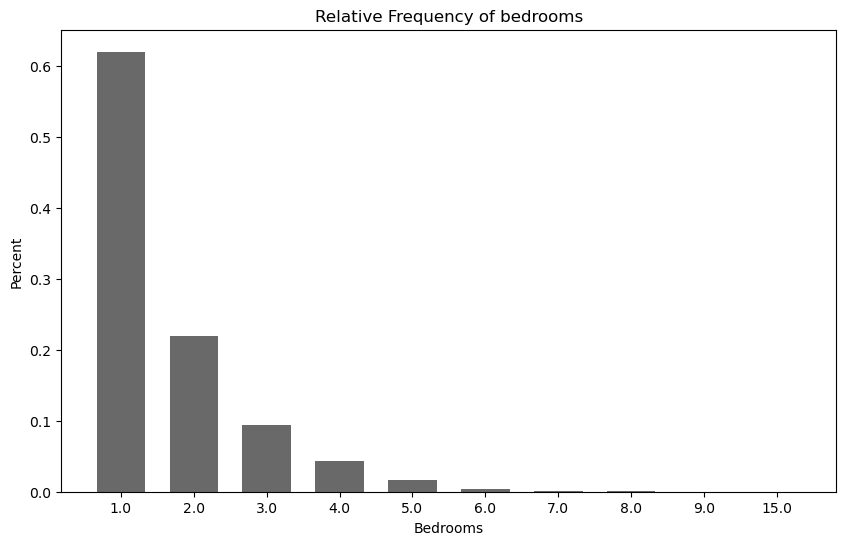

In [92]:
counts = tempDF["bedrooms"].value_counts().sort_index()
proportions = tempDF["bedrooms"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Bedrooms")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of bedrooms")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

### Beds

Beds corresponds to the number of beds in an Airbnb listing. This column is not the same as bedrooms due to the fact that a bed or futon could be classified as a bed which means there could be beds not in a bedroom. Additionally there could be more than one bed in a bedroom. Domain knowledge would lead us to believe that more beds would demand higher prices which is the same intuition as bedrooms and accommodates.

In [93]:
tempDF = vwListings
tempDF["beds"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['beds'], inplace=True)

In [94]:
tempDF["beds"].describe()

count    5051.000000
mean        2.114829
std         1.461953
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        20.000000
Name: beds, dtype: float64

In [95]:
tempDF["beds"].value_counts().sort_index()

1.0     2142
2.0     1560
3.0      708
4.0      306
5.0      138
6.0      113
7.0       31
8.0       30
9.0        8
10.0       6
11.0       1
12.0       7
20.0       1
Name: beds, dtype: int64

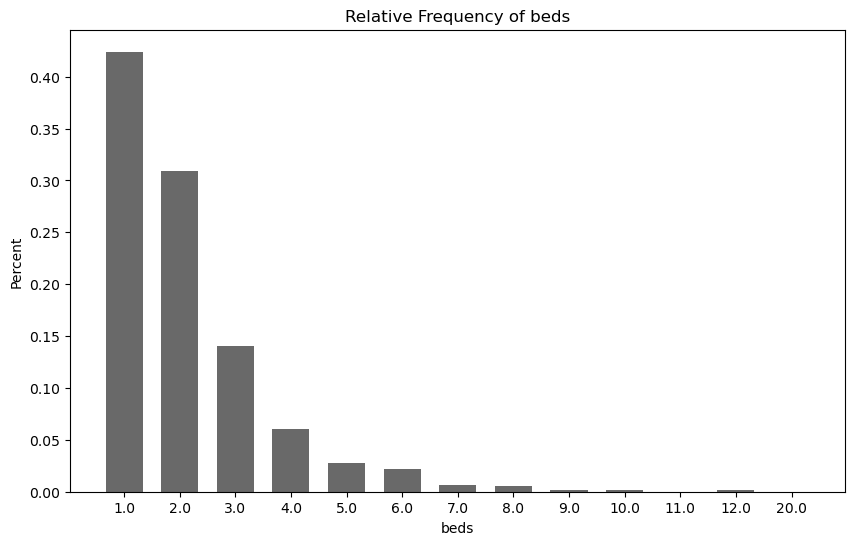

In [96]:
counts = tempDF["beds"].value_counts().sort_index()
proportions = tempDF["beds"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("beds")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of beds")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

### Amenities

Amenities is a description of the amenities provided by the listing. It is a JSON type variable and provides a list of amenities by the Airbnb. This column is potentially very noise as the list of amenities have no correlation with one another and each duplicate description could be from the same owner of the Airbnb.

In [97]:
tempDF = vwListings
tempDF["amenities"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['amenities'], inplace=True)

In [98]:
tempDF["amenities"].describe()

count                                                  5051
unique                                                 4510
top       ["Bathtub", "Coffee", "Pool", "Paid parking of...
freq                                                     90
Name: amenities, dtype: object

There are 4510 unique descriptions of amenities so essentially each listing of amenities almost has its own unique amenities description.

In [99]:
pd.DataFrame(tempDF["amenities"].value_counts())

,amenities
"[""Bathtub"", ""Coffee"", ""Pool"", ""Paid parking off premises"", ""Ethernet connection"", ""Air conditioning"", ""Baking sheet"", ""Long term stays allowed"", ""TV"", ""Carbon monoxide alarm"", ""Elevator"", ""Clothing storage"", ""Toaster"", ""Bed linens"", ""Smoke alarm"", ""Crib - available upon request"", ""Microwave"", ""Shampoo"", ""Hair dryer"", ""Pets allowed"", ""Shower gel"", ""Cooking basics"", ""Dishwasher"", ""Conditioner"", ""Outdoor furniture"", ""Extra pillows and blankets"", ""Refrigerator"", ""Cleaning products"", ""Hot water"", ""Oven"", ""Blender"", ""Body soap"", ""Hangers"", ""Dishes and silverware"", ""Freezer"", ""Heating"", ""Smart lock"", ""Washer"", ""Coffee maker"", ""Dining table"", ""Essentials"", ""Kitchen"", ""Exercise equipment"", ""Window guards"", ""Wifi"", ""Dryer"", ""Iron"", ""Wine glasses"", ""Self check-in"", ""Stove"", ""Hot water kettle"", ""Gym""]",90
"[""Air conditioning"", ""Paid parking on premises"", ""Carbon monoxide alarm"", ""Bed linens"", ""Smoke alarm"", ""Microwave"", ""Shampoo"", ""Hair dryer"", ""Pets allowed"", ""First aid kit"", ""TV with standard cable"", ""Extra pillows and blankets"", ""Dedicated workspace"", ""Hot water"", ""Hangers"", ""Heating"", ""Luggage dropoff allowed"", ""Fire extinguisher"", ""Essentials"", ""Building staff"", ""Wifi"", ""Iron"", ""Self check-in"", ""Gym""]",42
"[""Air conditioning"", ""Private entrance"", ""Carbon monoxide alarm"", ""Bed linens"", ""Smoke alarm"", ""Shampoo"", ""Hair dryer"", ""First aid kit"", ""TV with standard cable"", ""Extra pillows and blankets"", ""Hot water"", ""Hangers"", ""Heating"", ""Washer"", ""Coffee maker"", ""Luggage dropoff allowed"", ""Fire extinguisher"", ""Essentials"", ""Building staff"", ""Wifi"", ""Dryer"", ""Iron"", ""Self check-in"", ""Gym""]",21
"[""Air conditioning"", ""Long term stays allowed"", ""Carbon monoxide alarm"", ""Room-darkening shades"", ""Bed linens"", ""Smoke alarm"", ""Microwave"", ""Shampoo"", ""Hair dryer"", ""First aid kit"", ""Cooking basics"", ""Keypad"", ""Refrigerator"", ""Oven"", ""Hangers"", ""Dishes and silverware"", ""Heating"", ""Fire extinguisher"", ""Essentials"", ""Kitchen"", ""Wifi"", ""Breakfast"", ""Iron"", ""Self check-in"", ""Stove""]",19
"[""Bathtub"", ""Air conditioning"", ""Private entrance"", ""Long term stays allowed"", ""TV"", ""Carbon monoxide alarm"", ""Elevator"", ""Dryer \u2013\u00a0In unit"", ""Bed linens"", ""Smoke alarm"", ""Microwave"", ""Shampoo"", ""Hair dryer"", ""Pets allowed"", ""Dishwasher"", ""Refrigerator"", ""Hot water"", ""Oven"", ""Hangers"", ""Lockbox"", ""Heating"", ""Coffee maker"", ""Washer \u2013\u00a0In unit"", ""Essentials"", ""Kitchen"", ""Wifi"", ""Iron"", ""Self check-in"", ""Gym""]",17
...,...
"[""Single level home"", ""Air conditioning"", ""Private entrance"", ""TV"", ""Carbon monoxide alarm"", ""Smoke alarm"", ""Free street parking"", ""Microwave"", ""Shampoo"", ""Hair dryer"", ""First aid kit"", ""Cooking basics"", ""Dishwasher"", ""Extra pillows and blankets"", ""Refrigerator"", ""Hot water"", ""Oven"", ""Free parking on premises"", ""Hangers"", ""Dishes and silverware"", ""Heating"", ""Smart lock"", ""Washer"", ""Coffee maker"", ""Backyard"", ""Luggage dropoff allowed"", ""Fire extinguisher"", ""Essentials"", ""Kitchen"", ""Wifi"", ""Dryer"", ""Iron"", ""Self check-in"", ""Stove""]",1
"[""Hangers"", ""Cooking basics"", ""Essentials"", ""Breakfast"", ""Hair dryer"", ""Kitchen"", ""Bed linens"", ""Oven"", ""Washer"", ""Private entrance"", ""Iron"", ""Smart lock"", ""Coffee maker"", ""Lock on bedroom door"", ""Dishes and silverware"", ""Wifi"", ""Outdoor furniture"", ""First aid kit"", ""Dishwasher"", ""Extra pillows and blankets"", ""Smoke alarm"", ""Air conditioning"", ""Refrigerator"", ""Heating"", ""Dryer"", ""Stove"", ""Free street parking"", ""Microwave"", ""Hot water"", ""Long term stays allowed"", ""Shampoo"", ""Fire extinguisher"", ""Carbon monoxide alarm""]",1
"[""Paid parking off premises"", ""Ethernet

As we can see from our EDA, this column has a lot of noise as there are 4510 unique amenties descriptions. The top frequency is 90 where it could potentially be coming from the same Airbnb host copying their amenities description across their Airbnb listings. Overall, this column may be difficult to serve as useful for our model unless we can extract key words from each amenities JSON body. 

### Minimum nights / Maximum nights

In [100]:
min_nt = vwListings['minimum_nights']
max_nt = copy.copy(vwListings['maximum_nights'])

We print descriptive statistics for minimum_nights:

In [101]:
pd.DataFrame(min_nt.describe())

,minimum_nights
count,5051.000000
mean,19.010691
std,34.201249
min,1.000000
25%,2.000000
50%,4.000000
75%,31.000000
max,1125.000000


minimum_nights ranges from 1 to 1125, with a mean of 23.7 nights and median of 10 nights. A mean so much larger than the median indicates a highly right-skewed distribution. The 75th percentile is 31, much closer to the minimum than the maximum. We take a closer look at the high end of the distribution:

In [102]:
pd.DataFrame(min_nt.value_counts()).sort_index(ascending=False).head(15)

,minimum_nights
1125,1
600,1
365,12
360,1
200,1
185,1
184,4
183,1
181,1
180,21


There are only 6 values above 365 nights and 26 values above 200 nights. We display a density histogram of the values, zoomed in on values at or below 200 to get a better view.

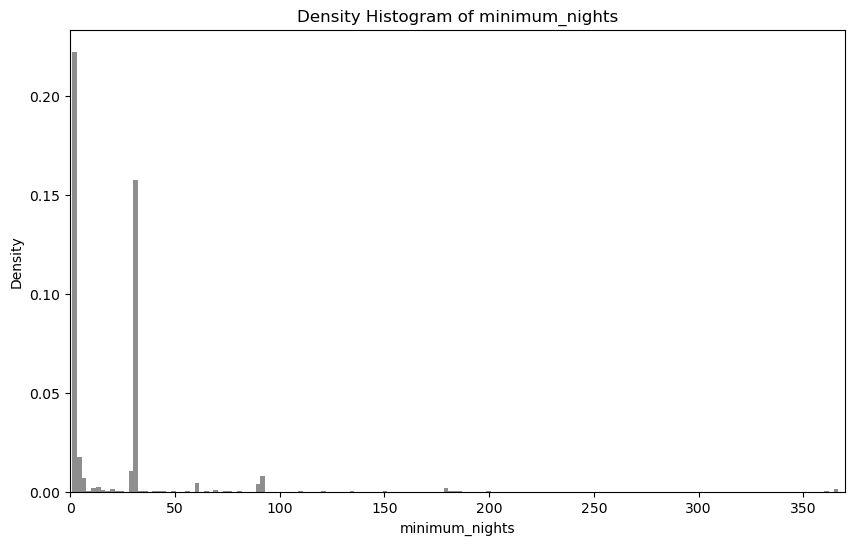

In [103]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(min_nt, color="DimGray", density=True, bins=501, alpha=0.75)
axes.set_xlabel("minimum_nights")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of minimum_nights")

axes.set_xlim(0, 370)

plt.show()
plt.close()

There are large clusters around 1 day and 31 days, with a smaller cluster around 90 and an even smaller cluster around 180. We look more closely at the most common values:

In [104]:
pd.DataFrame(min_nt.value_counts().sort_values(ascending=False)).head(20)

,minimum_nights
31,1522
2,1102
1,920
3,500
32,264
4,136
91,88
30,84
5,65
7,61


There appear to be 3 main groups:

<ul>
    <li>Short-term rentals with minimum stays of a week or less</li>
    <li>Medium-term rentals with minimum stays around a month (28-31 days)</li>
    <li>Medium-term rentals with minimum stays around 3 months (90-91 days)</li>
</ul>

There are other minor clusters around 2 weeks, 2 months, and half a year.

We next print descriptive statistics for maximum nights.

In [105]:
pd.DataFrame(max_nt.describe())

,maximum_nights
count,5.051000e+03
mean,2.600769e+03
std,1.406977e+05
min,2.000000e+00
25%,1.000000e+02
50%,3.650000e+02
75%,1.125000e+03
max,9.999999e+06


These values are much higher, ranging from a minimum of 1 to a maximum of 9,999,999. The median is 365 days, much closer to the 25th percentile of 120 than the 75th percentile of 1125. The maximum stay is completely unreasonable (about 27,000 years), so we look more closely at the high end of the distribution to see how many are like that.

In [106]:
pd.DataFrame(max_nt.value_counts()).sort_index(ascending=False).head(15)

,maximum_nights
9999999,1
10000,1
3365,1
1825,1
1125,2245
1124,24
1123,3
1120,3
1111,1
1100,2


Only 6 values are above 1125, which appears to be the most common value with 3471 points. We display a histogram of values at or below 1125 days.

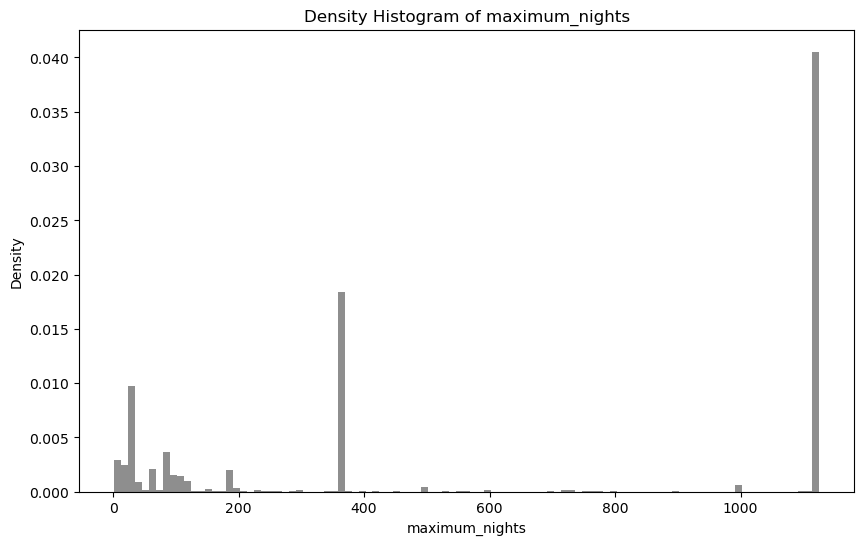

In [107]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(max_nt[max_nt < 1450], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("maximum_nights")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of maximum_nights")

plt.show()
plt.close()

There are three large clusters around 30, 365, and 1125 nights.

maximum_nights should increase with minimum_nights, so we display a scatterplot to investigate the relationship between them. We impose a maximum value of 1125 to make the plot readable.

In [108]:
max_nt[max_nt > 1125] = 1125

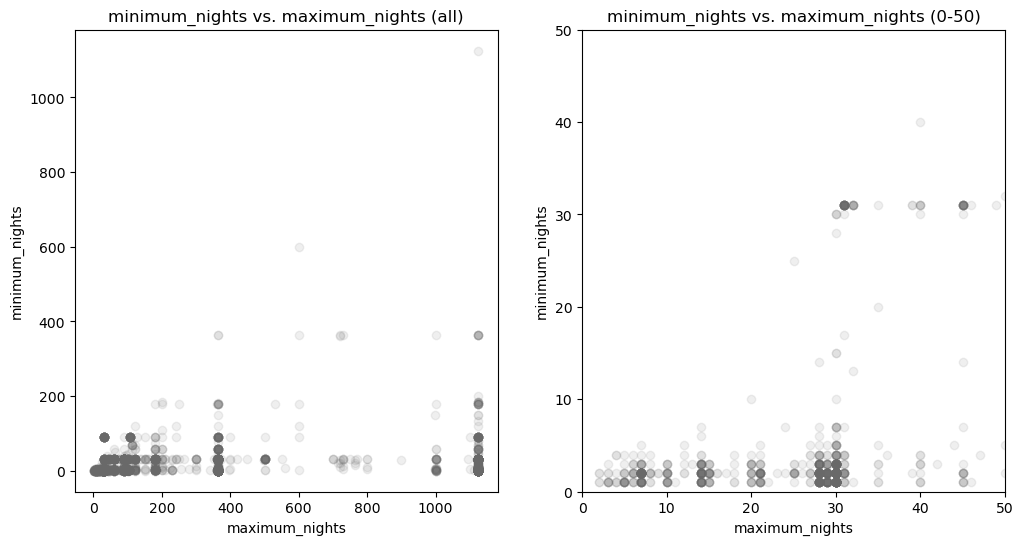

In [109]:
figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 2, 1)
axes.scatter(max_nt, min_nt, marker="o", color="dimgray", alpha=0.1)

axes.set_ylabel("minimum_nights")
axes.set_xlabel("maximum_nights")
axes.set_title("minimum_nights vs. maximum_nights (all)")

axes = figure.add_subplot(1, 2, 2)
axes.scatter(max_nt, min_nt, marker="o", color="dimgray", alpha=0.1)

axes.set_ylabel("minimum_nights")
axes.set_xlabel("maximum_nights")
axes.set_title("minimum_nights vs. maximum_nights (0-50)")
axes.set_ylim(0, 50)
axes.set_xlim(0, 50)

plt.show()
plt.close()

Many short-term rentals have very high maximum_nights around 1125. The zoomed-in view shows that ~30 days is the most common maximum_night cluster for short-term rentals.

The scatterplot does show some points that appear to have higher minimum_nights than maximum_nights, which shouldn't be possible.

In [110]:
vwListings.loc[min_nt > max_nt, ['minimum_nights', 'maximum_nights', 'host_id', 'number_of_reviews', 'price',
                          'has_availability', 'accommodates']].describe()

,minimum_nights,maximum_nights,host_id,number_of_reviews,price,accommodates
count,37.0,37.0,37.0,37.000000,37.000000,37.000000
mean,91.0,31.0,294545484.0,0.054054,75.162162,1.729730
std,0.0,0.0,0.0,0.229243,15.325203,0.450225
min,91.0,31.0,294545484.0,0.000000,51.000000,1.000000
25%,91.0,31.0,294545484.0,0.000000,65.000000,1.000000
50%,91.0,31.0,294545484.0,0.000000,75.000000,2.000000
75%,91.0,31.0,294545484.0,0.000000,85.000000,2.000000
max,91.0,31.0,294545484.0,1.000000,110.000000,2.000000


There are 90 such listings, all with minimum_nights = 91 and maximum_nights = 31 from the same host with host_id = 294545484. Further, none of them have any reviews in the last 12 months (though a small number have some reviews from earlier), but all of them do have availability at prices that don't seem ridiculous.

In [111]:
pd.DataFrame(vwListings.loc[vwListings['host_id'] == 294545484, ['host_name', 'source_name', 'room_type']].value_counts())

0
host_name source_name      room_type          
June      listings_3_2023  Private room     61
          listings_12_2022 Private room     12
          listings_9_2022  Private room      3
          listings_12_2022 Entire home/apt   1
          listings_3_2023  Entire home/apt   1

These listings are all from host_name "June" and are mostly private rooms.

### Minimum-minimum nights

Minimum_minimum_nights is a numerical variable that describes the smallest minimum_night value from the calendar table of the listing. It accounts for all 365 nights in the future. This is the minimum required nights that need to be booked in order to be able to book the listing. 

In [112]:
tempDF = vwListings
tempDF["minimum_minimum_nights"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['minimum_minimum_nights'], inplace=True)

In [113]:
tempDF["minimum_minimum_nights"].describe()

count     5051
unique      60
top         31
freq      1492
Name: minimum_minimum_nights, dtype: int64

Looking at the summary statistics, most of the airbnb listings have a minimum night requirement 1-3 nights. However there are a lot of outliers that make the distribution look skewed to the right because the max value is 1125 nights.

In [114]:
tempDF["minimum_minimum_nights"].value_counts().sort_index()

1       1155
2       1084
3        391
4         99
5         57
6         11
7         62
8          4
9          1
10        12
12         1
13         3
14        28
15         7
16         1
17         1
20         1
21         7
22         1
25         5
27         1
28        31
29         2
30        71
31      1492
32       216
33         2
35         2
40         2
42         1
45         4
48         1
50         3
55         1
56         1
60        47
65         1
70        10
75         1
77         2
80         1
87         1
89         2
90        40
91        84
110        1
120        5
135        1
150        3
180       20
181        1
183        1
184        4
185        1
200        1
360       48
365       12
600        1
730        1
1125       1
Name: minimum_minimum_nights, dtype: int64

As we see from looking at the value counts of each of the minimum nights, most listings require 1-3 nights in order to book their listing. However, there are a significant amount of listings who need at least 30 nights which means that you would have to book the listing for at least a month in order to stay. These are most likely long term stays for Airbnb.

### Maximum-minimum nights

Maximum_minimum nights is a numeric variable that describes the largest minimum_night value from the calendar. It accounts for all 365 nights in the future. This is the minimum required nights that need to be booked in order to be able to book the listing.

In [115]:
tempDF = vwListings
tempDF["maximum_minimum_nights"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['maximum_minimum_nights'], inplace=True)

In [116]:
tempDF["maximum_minimum_nights"].describe()

count     5051
unique      63
top         31
freq      1513
Name: maximum_minimum_nights, dtype: int64

Looking at the summary statistics, most of the airbnb listings have a minimum night requirement 1-5 nights. However there are a lot of outliers that make the distribution look skewed to the right because the max value is 1125 nights.

In [117]:
tempDF["maximum_minimum_nights"].value_counts().sort_index()

1       600
2       965
3       610
4       301
5       112
       ... 
365      18
366     158
600       1
730      34
1125      1
Name: maximum_minimum_nights, Length: 63, dtype: int64

As we see from looking at the value counts of each of the minimum nights, most listings require 1-3 nights in order to book their listing. There are more longer term requirements due to the maximum value that is scraped from the calendar.

### Has availability

In [118]:
ha = vwListings1['has_availability']

has_availability keeps track of whether the listing has any availability in the calendar. It is potentially a way to spot "dead" listings that could be removed from the dataset. We print value counts.

In [119]:
pd.DataFrame(ha.value_counts())

,has_availability
t,8166
f,462


There are 8166 listings with availability and 462 listings with no availability. We take a closer look at the listings with no availability.

In [235]:
pd.DataFrame(vwListings1.loc[ha == 'f', 'minimum_nights'].value_counts(normalize=True)).head(15)

,minimum_nights
31,0.883117
70,0.021645
60,0.015152
90,0.010823
30,0.010823
180,0.008658
56,0.008658
365,0.006494
3,0.004329
1,0.004329


These listings are mostly medium- or long-term rentals, but not exclusively.

### Number of reviews 

Number of review is the number of reviews that listing has. It is the integer number.

In [121]:
vwListings.number_of_reviews.describe()

count    5051.000000
mean       56.413779
std        89.335455
min         0.000000
25%         2.000000
50%        20.000000
75%        70.000000
max       898.000000
Name: number_of_reviews, dtype: float64

The variable distribution is skewed. The mean number of reviews is 45 times, and the median is 10 pounds, or about 78% lower. The 3rd quartile is 51, around 51x the 1st quartile. The minimum is "only" 0, while the maximum is 898.

In [122]:
vwListings.number_of_reviews.value_counts()

0      912
1      262
2      168
3      121
6      108
      ... 
474      1
242      1
315      1
459      1
311      1
Name: number_of_reviews, Length: 404, dtype: int64

Let's plot a histogram of the data:

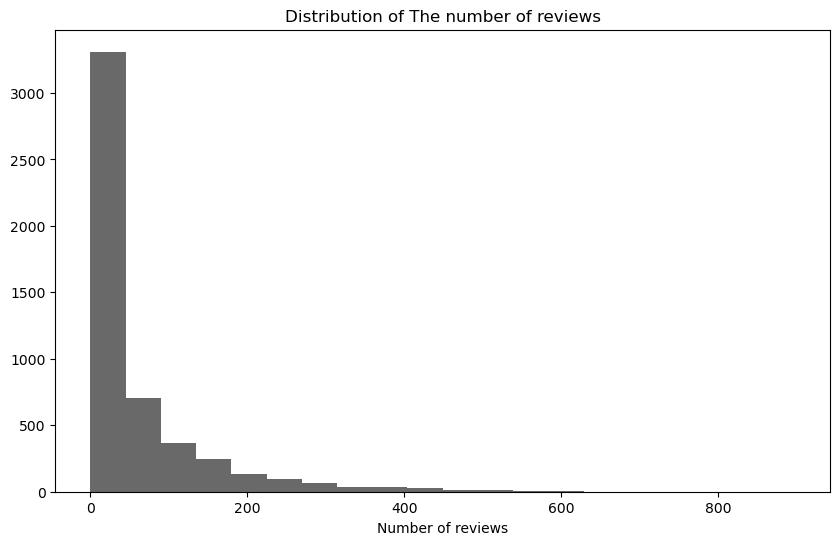

In [123]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.number_of_reviews, color="dimgray", bins = 20)
axes.set_title("Distribution of The number of reviews")
axes.set_xlabel("Number of reviews")

plt.show()
plt.close()

No surprise, the most number of reviews is not reviews. It is not normally distributed. 

### Number of reviews ltm

Number of review itm is the number of reviews that listing has in the last 12 months. It is the integer number.

In [124]:
vwListings.number_of_reviews_ltm.describe()

count    5051.000000
mean       14.792714
std        23.672184
min         0.000000
25%         0.000000
50%         4.000000
75%        22.500000
max       561.000000
Name: number_of_reviews_ltm, dtype: float64

The variable distribution is skewed. The mean number of reviews in the last 12 months is 12.4 times, and the median is 2, or about 84% lower. The 3rd quartile is 16. The minimum is "only" 0, while the maximum is 561.

In [125]:
vwListings.number_of_reviews_ltm.value_counts()

0      1659
1       360
2       231
3       160
4       137
       ... 
131       1
118       1
136       1
108       1
133       1
Name: number_of_reviews_ltm, Length: 119, dtype: int64

Let's plot a histogram of the data:

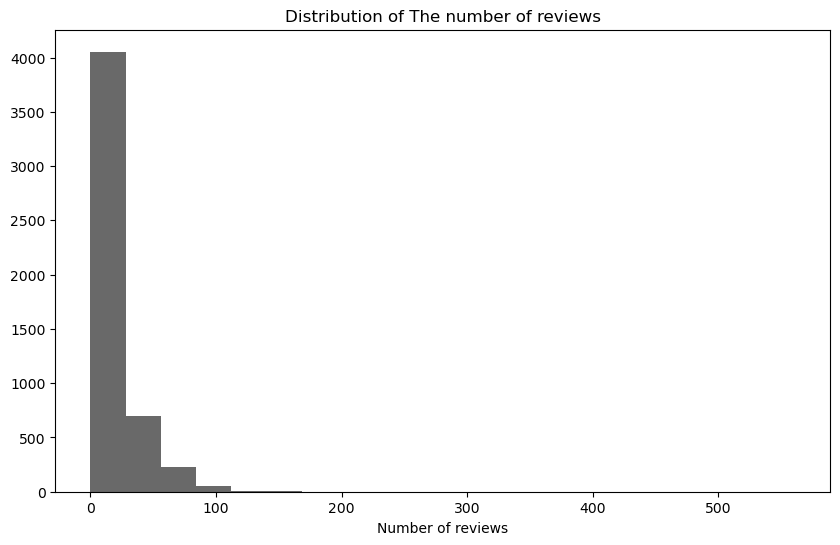

In [126]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.number_of_reviews_ltm, color="dimgray", bins = 20)
axes.set_title("Distribution of The number of reviews")
axes.set_xlabel("Number of reviews")

plt.show()
plt.close()

No surprise, the most number of reviews is not reviews. It is not normally distributed.

### Number of reviews l30d

Number of review i30d is the number of reviews that listing has in the last 30 days. It is the integer number.

In [127]:
vwListings.number_of_reviews_l30d.describe()

count    5051.000000
mean        1.056226
std         1.931707
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        31.000000
Name: number_of_reviews_l30d, dtype: float64

The variable distribution is skewed. The mean number of reviews in the last 30 days is 0.89 times, and the median is 0, or about 100% lower. The 3rd quartile is 1. The minimum is "only" 0, while the maximum is 31.

vwListings.number_of_reviews_l30d.value_counts()

Let's plot a histogram of the data:

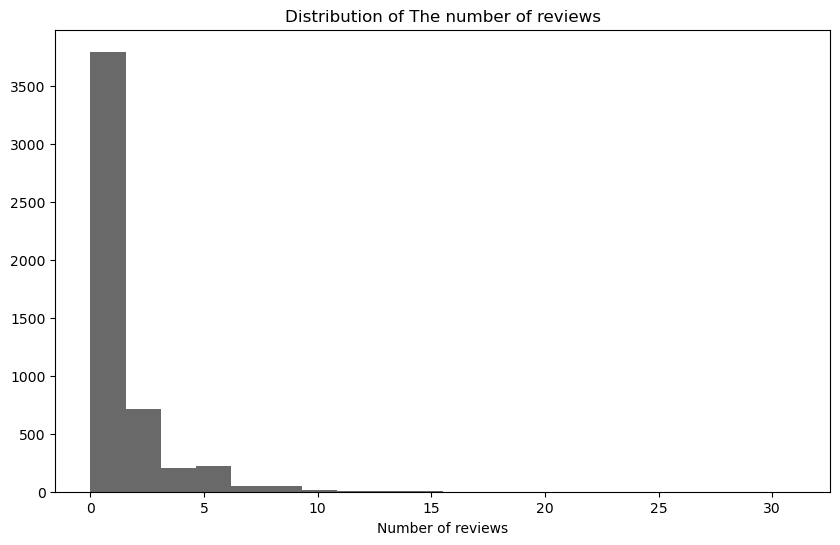

In [128]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.number_of_reviews_l30d, color="dimgray", bins = 20)
axes.set_title("Distribution of The number of reviews")
axes.set_xlabel("Number of reviews")

plt.show()
plt.close()

No surprise, the most number of reviews is not reviews. It is not normally distributed.

### First review / Last review

In [129]:
fr = copy.copy(vwListings['first_review'])
lr = copy.copy(vwListings['last_review'])

In [130]:
vwListings[['first_review','last_review']].describe(datetime_is_numeric=True)

,first_review,last_review
count,5051,5051
unique,2089,916
top,,
freq,912,912


There are 6432 first and last reviews out of 8628 total listings. This means that 2196 listings have no reviews. 

The earliest first_review is 1/20/2009 and the latest first_review is 3/18/2023 (the day before the data was most recently scraped). The earliest last_review is 5/21/2013 and the latest last_review is also 3/18/2023. A listing with their last review in 2013 is concerning, since they haven't gotten any reviews in nearly 10 years. This is another potential sign of a "dead" listing. I will look at a histogram of last_reviews.

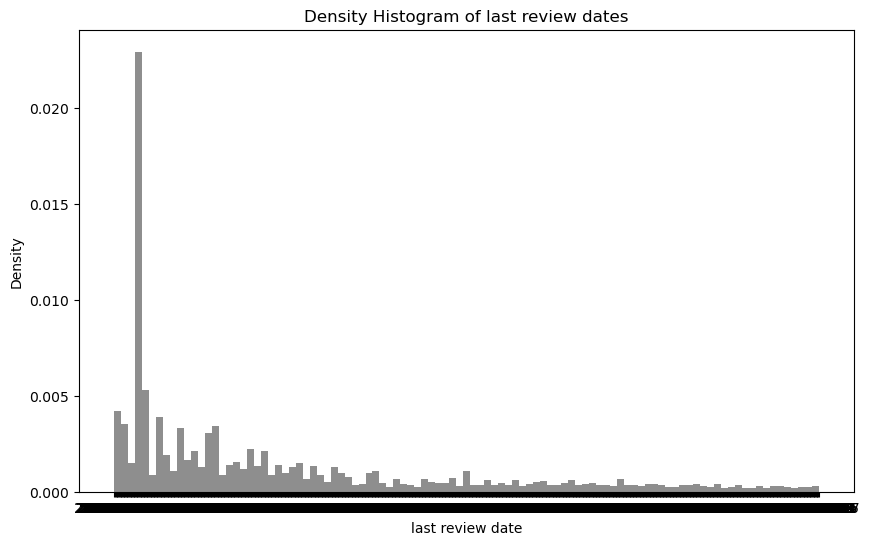

In [131]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(lr, color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("last review date")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of last review dates")

#axes.set_xlim(bins[0]-10, bins[75])
#axes.set_ylim(0, 0.001)

plt.show()
plt.close()

While most listings have a review within the past year, a surprisingly large number haven't had any reviews since 2019 or earlier. There is also a large gap in early 2020 during the beginning of the COVID pandemic, with a good number of listings having their last review in late 2019 or early 2020.

### Review scores

There are 7 types of review scores left by guests. review_scores_rating is the overall rating of the experience. review_scores_accuracy rates how accurate the information provided by the host was. review_scores_cleanliness is self-explanatory, rating how clean the rental was. review_scores_checkin rates how easy the host made the check-in process. review_scores_communication rates how well the host communicated with the guests. review_scores_location is also self-explanatory, rating the location of the rental. Finally, review_scores_value rates how well the guest felt they got their money's worth.

We replace blank review values with NaN for now.

In [132]:
vwListings[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
     'review_scores_communication','review_scores_location','review_scores_value']] = vwListings[[
    'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
     'review_scores_communication','review_scores_location','review_scores_value']].replace('', np.NaN)

We display descriptive statistics for each review score.

In [133]:
vwListings[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin']].describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin
count,4139.000000,4131.000000,4131.000000,4131.000000
mean,4.746685,4.812179,4.766175,4.867093
std,0.403607,0.319297,0.342289,0.299356
min,0.000000,1.000000,1.000000,1.000000
25%,4.680000,4.770000,4.700000,4.860000
50%,4.850000,4.900000,4.870000,4.950000
75%,4.950000,4.980000,4.970000,5.000000
max,5.000000,5.000000,5.000000,5.000000


In [134]:
vwListings[['review_scores_communication','review_scores_location','review_scores_value']].describe()

,review_scores_communication,review_scores_location,review_scores_value
count,4131.000000,4131.000000,4131.000000
mean,4.855098,4.783040,4.712033
std,0.321895,0.332858,0.364753
min,1.000000,1.000000,1.000000
25%,4.850000,4.710000,4.650000
50%,4.950000,4.890000,4.800000
75%,5.000000,4.990000,4.900000
max,5.000000,5.000000,5.000000


There are 6432 review_scores_ratings (same as the number of listings with reviews), 6406 review_scores_values, and 6407 for the rest. Some listings have review_scores_ratings but not the other scores. 

review_scores_rating has a minimum value of 0 while the others don't have any scores below 1. The scores are out of 5, which is the maximum for each. review_scores_checkin has the highest mean of 4.84, closely followed by review_scores_communication at 4.83. review_scores_value has the lowest mean at 4.68. review_scores_rating has the next-lowest at 4.7, though this might be misleading since it has 25 more values.

In [135]:
vwListings.loc[~vwListings['review_scores_rating'].isna()&vwListings['review_scores_accuracy'].isna(), 'review_scores_rating'].mean()

0.0

The listings with review_scores_ratings but not the others all have ratings of 0. This helps explain why review_scores_rating has a relatively low mean, and also probably explains why it has the largest standard deviation.

We plot a histogram of review_scores_rating, probably the most important score.

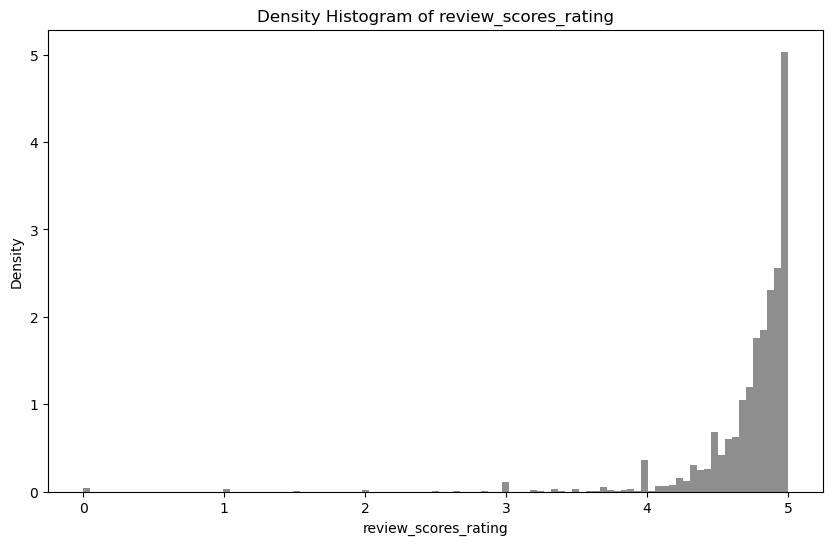

In [136]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(vwListings['review_scores_rating'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_rating")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of review_scores_rating")

plt.show()
plt.close()

A vast majority of scores are between 4 and 5, with most of those above 4.5. There are spikes at whole numbers, likely from listings with few reviews that average out there.

We also plot histograms for the other six scores to compare their distributions, seeing if any are notably different.

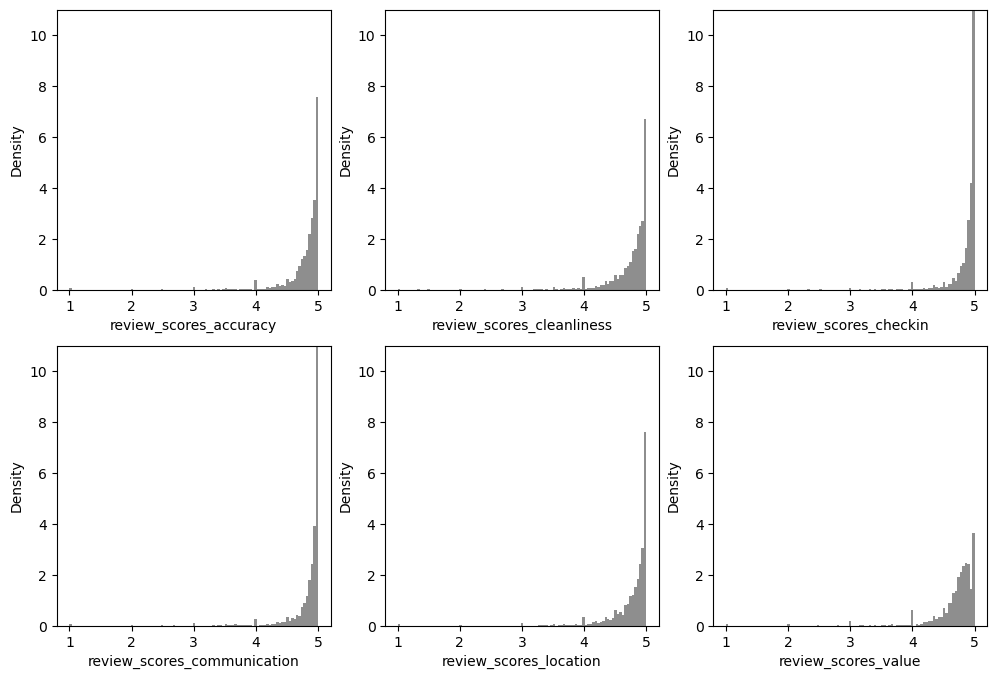

In [137]:
figure = plt.figure(figsize=(12,8))

axes = figure.add_subplot(2, 3, 1)
n, bins, patches = axes.hist(vwListings['review_scores_accuracy'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_accuracy")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 2)
n, bins, patches = axes.hist(vwListings['review_scores_cleanliness'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_cleanliness")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 3)
n, bins, patches = axes.hist(vwListings['review_scores_checkin'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_checkin")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 4)
n, bins, patches = axes.hist(vwListings['review_scores_communication'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_communication")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 5)
n, bins, patches = axes.hist(vwListings['review_scores_location'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_location")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 6)
n, bins, patches = axes.hist(vwListings['review_scores_value'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_value")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

plt.show()
plt.close()

review_scores_value has the most unique distribution. There are fewer perfect 5s and more 3s and 4s than the other review scores, and the values between 4 and 5 are less clustered near 5. review_scores_cleanliness exhibits those same characteristics to a lesser degree. review_scores_checkin and review_scores_communication are very closely clustered around 5.

### Reviews per month

A blank value in reviews_per_month indicates no reviews, so we replace blanks with 0.

In [138]:
vwListings['reviews_per_month'] = vwListings['reviews_per_month'].replace('', 0)

In [139]:
rpm = vwListings['reviews_per_month']

We print descriptive statistics.

In [140]:
pd.DataFrame(rpm.describe())

,reviews_per_month
count,5051.000000
mean,1.480505
std,2.002183
min,0.000000
25%,0.115000
50%,0.840000
75%,2.250000
max,59.650000


reviews_per_month ranges from 0 to 59.65, with a mean of 1.29 and a median of 0.51. It's unclear how a listing can get 59.65 reviews per month since that is more than 1 per day, so we look at the highest values.

In [141]:
pd.DataFrame(rpm.value_counts().sort_index(ascending=False)).head(10)

,reviews_per_month
59.65,1
31.67,1
21.34,1
21.32,1
16.27,1
14.80,1
14.03,1
13.06,1
12.96,1
12.86,1


There are two listings with more than one review per day, which shouldn't be possible. We look more closely at those listings:

In [142]:
vwListings.loc[rpm > 31, ['id','name','number_of_reviews_ltm','source_name','host_id']]

,id,name,number_of_reviews_ltm,source_name,host_id
4808,48425132,2 Queen Apt Suite | 2500 Penn Placemakr Experi...,561,listings_3_2023,389664429
7130,659366271388568374,Standard Queen Bed at Selina Union Market Wash...,517,listings_3_2023,459231442


The links to both of these listings appear dead. They should be dropped before modeling.

### Instant bookable

Instant bookable is boolean: t=true or f=false. It is whether the guest can automatically book the listing without the host requiring to accept their booking request. An indicator of a commercial listing.

In [143]:
vwListings.instant_bookable.describe()

count     5051
unique      21
top          f
freq      3506
Name: instant_bookable, dtype: object

In [144]:
vwListings.instant_bookable.value_counts()

f      3506
t      1307
1       104
2        43
3        17
6        12
5        10
4        10
83        6
17        6
13        5
9         5
227       4
156       4
23        3
15        3
21        2
30        1
14        1
37        1
7         1
Name: instant_bookable, dtype: int64

The number of "No" instant bookable is 2 times of The number of "Yes" instant bookable.

### Calculated host listings count

It is the number of listings that the host has in the current scrape, in the city/region geography.

In [145]:
vwListings.calculated_host_listings_count.describe()

count    5051.000000
mean       28.232429
std        59.860880
min         1.000000
25%         1.000000
50%         2.000000
75%        13.000000
max       235.000000
Name: calculated_host_listings_count, dtype: float64

The variable is definitely skewed. The mean is 32.4 listings and the median is 2 listings, much lower compared with mean. The 3rd quartile is 20x the 1st quartile. The minimum number of listings is "only" 1 listings and the maximum is 235 listings, so there are definitely extremes in the data. Let's count the frequency and plot a histogram of the data: 

In [146]:
vwListings.calculated_host_listings_count.value_counts()

1      2101
2       663
3       316
173     224
221     206
4       183
5       146
94       90
6        89
32       87
8        75
7        73
78       73
9        59
20       44
42       42
17       37
10       33
33       33
35       31
18       30
38       30
235      30
13       28
36       27
26       26
14       26
11       25
101      24
21       23
19       19
15       18
54       15
37       14
156      14
189      13
31       13
96        8
166       8
46        7
12        7
214       6
83        6
34        6
227       4
16        3
63        3
89        3
23        3
45        2
79        2
30        2
28        1
Name: calculated_host_listings_count, dtype: int64

The majority of the number of listings that the host has is one listing. Let's plot histogram:

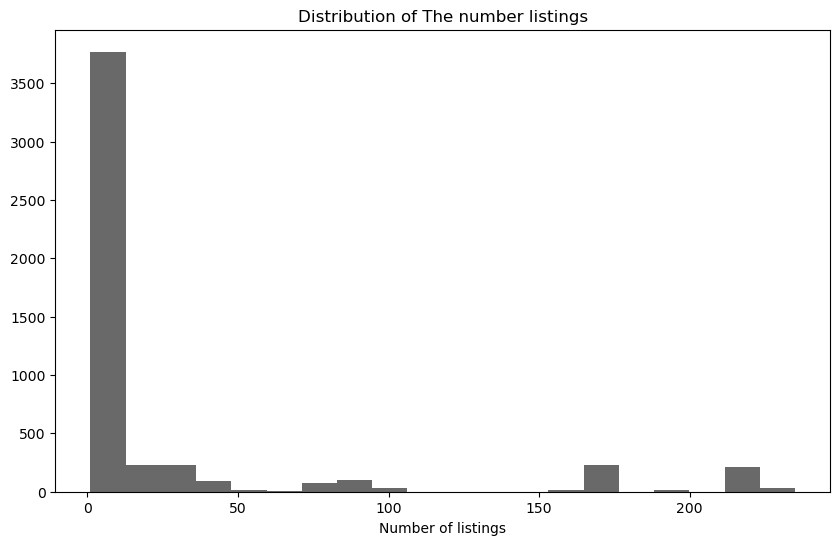

In [147]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.calculated_host_listings_count, color="dimgray", bins = 20)
axes.set_title("Distribution of The number listings")
axes.set_xlabel("Number of listings")

plt.show()
plt.close()

Interesting, there are some hosts that have more than 150 listings, but the most is still one listing.

### Calculated host listings count entire homes

It is the number of entire home/apt listings that the host has in the current scrape, in the city/region geography.

In [148]:
vwListings.calculated_host_listings_count_entire_homes.describe()

count    5051.000000
mean       23.146506
std        55.834873
min         0.000000
25%         1.000000
50%         1.000000
75%         5.000000
max       235.000000
Name: calculated_host_listings_count_entire_homes, dtype: float64

The variable is definitely skewed. The mean is 24 listings and the median is 1 listing, much lower compared with mean. The 3rd quartile is 9x the 1st quartile. The minimum number of listings is "only" 0 listing and the maximum is 235 listings, so there are definitely extremes in the data. Let's count the frequency and plot a histogram of the data:

In [149]:
vwListings.calculated_host_listings_count_entire_homes.value_counts()

1      2096
0       750
2       546
3       231
221     206
154     162
4       112
10      103
94       90
32       87
78       73
5        73
6        64
8        43
7        41
17       36
9        32
35       31
235      30
36       27
26       26
101      24
150      22
20       16
13       15
19       14
29       13
31       13
18       12
11        9
15        8
96        8
83        6
34        6
214       6
227       4
23        3
16        3
33        3
89        3
79        2
28        2
Name: calculated_host_listings_count_entire_homes, dtype: int64

The majority of the number of listings that the host has is one listing. Let's plot histogram:

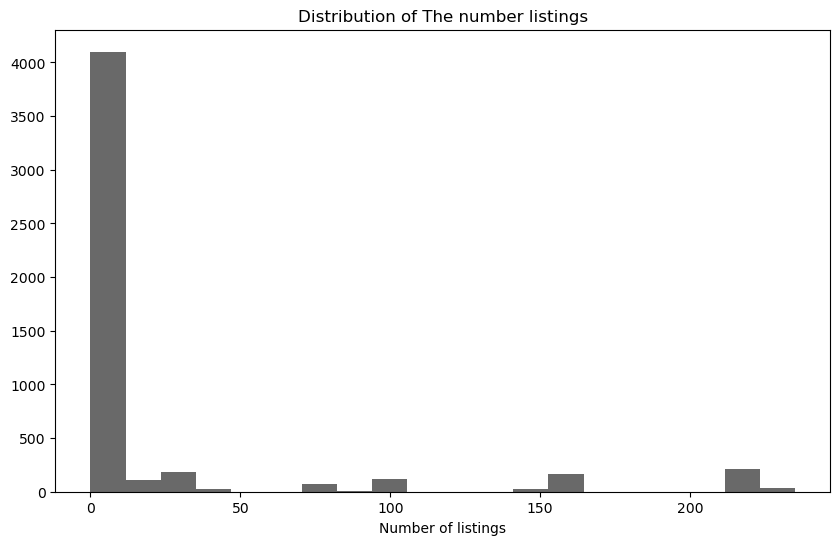

In [150]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.calculated_host_listings_count_entire_homes, color="dimgray", bins = 20)
axes.set_title("Distribution of The number listings")
axes.set_xlabel("Number of listings")

plt.show()
plt.close() 

Interesting, there are some hosts that have more than 150 listings, but the most is still 0 listings.

### Calculated host listings count private rooms

It is the number of private room listings that the host has in the current scrape, in the city/region geography.

In [151]:
vwListings.calculated_host_listings_count_private_rooms.describe()

count    5051.000000
mean        4.572758
std        20.716560
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       170.000000
Name: calculated_host_listings_count_private_rooms, dtype: float64

The variable is definitely skewed. The mean is 7.8 listings and the median is 0 listing, much lower compared with mean. The 3rd quartile is 1 listing and the 1st quartile is 0 listing. The minimum number of listings is 0 listing and the maximum is 170 listings, so there are definitely extremes in the data. Let's count the frequency and plot a histogram of the data:

In [152]:
vwListings.calculated_host_listings_count_private_rooms.value_counts()

0      3530
1       447
2       202
13      173
3       140
4       122
163      62
5        47
42       42
11       41
8        39
7        33
38       30
6        25
16       20
9        18
17       17
54       15
170      13
18        8
46        7
12        5
19        3
15        3
59        3
28        2
14        2
10        2
Name: calculated_host_listings_count_private_rooms, dtype: int64

The most number of listings that the host has is 0 listing. Let's plot histogram

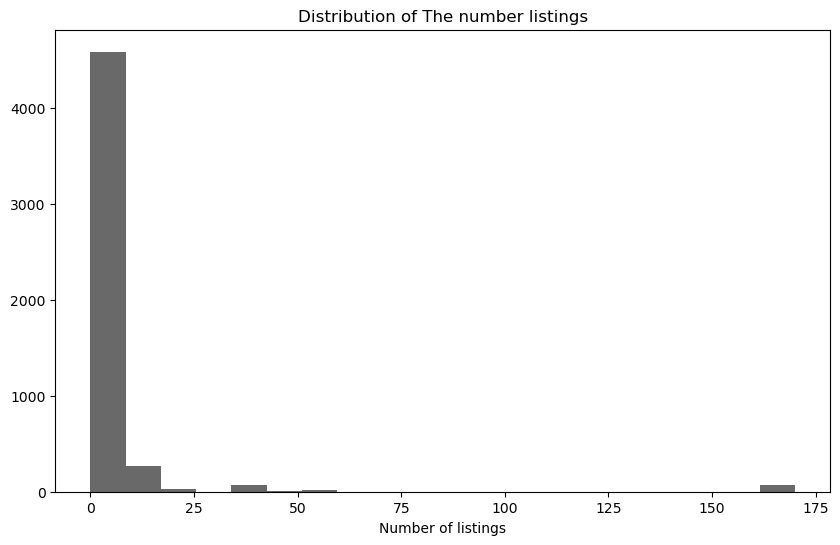

In [153]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.calculated_host_listings_count_private_rooms, color="dimgray", bins = 20)
axes.set_title("Distribution of The number listings")
axes.set_xlabel("Number of listings")

plt.show()
plt.close()

There are some hosts that have more than 150 listings, but the most is still zero.

### Calculated host listings count shared rooms 

It is the number of shared room listings that the host has in the current scrape, in the city/region geography.

In [154]:
vwListings.calculated_host_listings_count_shared_rooms.describe()

count    5051.000000
mean        0.383488
std         2.069303
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        20.000000
Name: calculated_host_listings_count_shared_rooms, dtype: float64

The mean is 0.3 listings and the median is 0 listing, lower compared with mean. The 3rd quartile is 0 listing and the 1st quartile is 0 listing. The minimum number of listings is 0 listing and the maximum is 20 listings, so there are definitely extremes in the data. Let's count the frequency and plot a histogram of the data:

In [155]:
vwListings.calculated_host_listings_count_shared_rooms.value_counts()

0     4791
5      162
16      30
20      21
1       14
2       13
13      10
4        8
17       1
8        1
Name: calculated_host_listings_count_shared_rooms, dtype: int64

The most number of listings that the host has is 0 listing. Let's plot histogram:

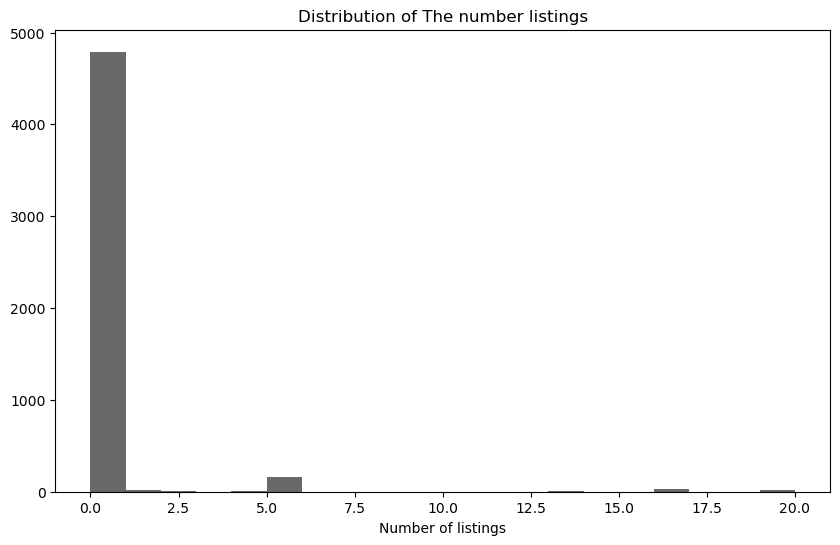

In [156]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.calculated_host_listings_count_shared_rooms, color="dimgray", bins = 20)
axes.set_title("Distribution of The number listings")
axes.set_xlabel("Number of listings")

plt.show()
plt.close()

There are some hosts that have more than 5 listings, but the most is still 0 listings.

### Latitude / Longitude

Use proximity to Washington, DC, attractions and main public transportation, determined by the GPS coordinates of an attraction as secondary data for model development. This will be our 2nd dataset.

In [157]:
#  the coordinates (latitude, longtitute of a place from google map )
smithsonian_lat = 38.8889532077163
smithsonian_long = -77.0259992316524
lincoln_memorial_lat = 38.8893771334115
lincoln_memorial_long = -77.0501761044084
capitol_lat = 38.8900557831996
capttol_long = -77.0090290467363
white_house_lat = 38.9103145107623
white_house_long = -77.0221504467353
library_of_congress_lat = 38.8888008852652
library_of_congress_long = -77.0047082755724
nationals_park_lat = 38.8731981381059
nationals_park_long = -77.0074329
national_zoo_lat = 38.9294590679026
national_zoo_long = -77.0492384835061
union_station_lat = 38.8973065709087
union_station_long = -77.00629767372
mcpherson_sq_lat = 38.9028682064423
mcpherson_sq_long = -77.0324745881233

In [158]:
# distance unit = miles
vwListings["distance_smitsonian"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(smithsonian_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(smithsonian_lat))
                                            *np.cos(np.radians(smithsonian_long-vwListings["longitude"])) )*3963*1.15077945

In [159]:
vwListings["distance_lincoln"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(lincoln_memorial_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(lincoln_memorial_lat))
                                            *np.cos(np.radians(lincoln_memorial_long-vwListings["longitude"])) )*3963*1.15077945

In [160]:
vwListings["distance_capitol"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(capitol_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(capitol_lat))
                                            *np.cos(np.radians(capttol_long-vwListings["longitude"])) )*3963*1.15077945

In [161]:
vwListings["distance_white_house"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(white_house_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(white_house_lat))
                                            *np.cos(np.radians(white_house_long-vwListings["longitude"])) )*3963*1.15077945

In [162]:
vwListings["distance_library_congress"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(library_of_congress_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(library_of_congress_lat))
                                            *np.cos(np.radians(library_of_congress_long-vwListings["longitude"])))*3963*1.15077945

In [163]:
vwListings["distance_nationals_park"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(nationals_park_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(nationals_park_lat))
                                            *np.cos(np.radians(nationals_park_long-vwListings["longitude"])) )*3963*1.15077945

In [164]:
vwListings["distance_national_zoo"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(national_zoo_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(national_zoo_lat))
                                            *np.cos(np.radians(national_zoo_long-vwListings["longitude"])) )*3963*1.15077945

In [165]:
vwListings["distance_railway"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(union_station_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(union_station_lat))
                                            *np.cos(np.radians(union_station_long-vwListings["longitude"])) )*3963*1.15077945

In [166]:
vwListings["distance_mcpherson"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(mcpherson_sq_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(mcpherson_sq_lat))
                                            *np.cos(np.radians(mcpherson_sq_long-vwListings["longitude"])) )*3963*1.15077945

### Distance to Smitsonian

The distance from hosts to Smitsonian is measured in terms of miles.

In [167]:
vwListings.distance_smitsonian.describe()

count    5051.000000
mean        3.181072
std         1.727991
min         0.491451
25%         1.938786
50%         2.579456
75%         4.008340
max         9.480365
Name: distance_smitsonian, dtype: float64

The variable is definitely skewed. The mean is 3.20 miles and the median is 2.64 miles, or about 17.5% lower. The 3rd quartile is nearly 2x the 1st quartile. The minimum distance is "only" 0.49 miles and the maximum is 9.48 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

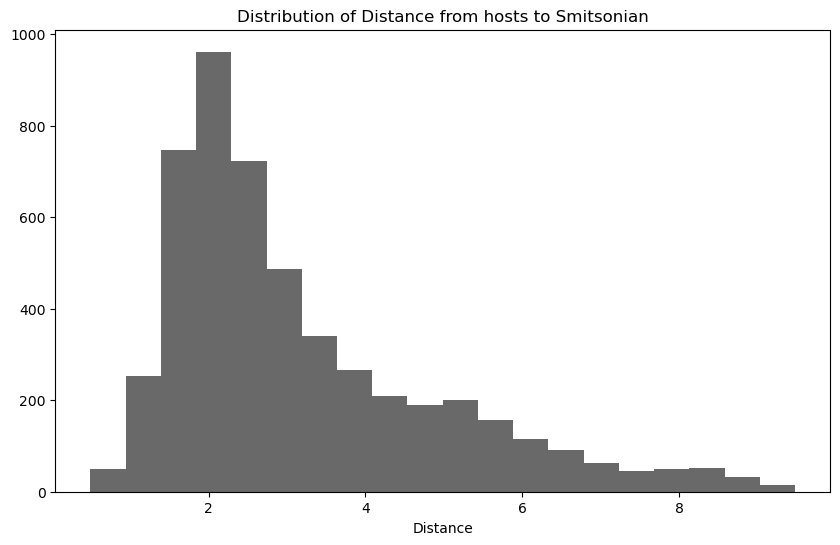

In [168]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_smitsonian, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to Smitsonian")
axes.set_xlabel("Distance")

plt.show()
plt.close()

It is seen that the distribution does not appear to be normally distributed. The distance is quite variable among hosts and depends on their location.

### Distance to Lincoln

The distance from hosts to Lincoln Memorial is measured in terms of miles.

In [169]:
vwListings.distance_lincoln.describe()

count    5051.000000
mean        3.743119
std         1.760621
min         0.568090
25%         2.503048
50%         3.349833
75%         4.526242
max         9.831802
Name: distance_lincoln, dtype: float64

The distribution of distance is slightly skewed. The mean is 3.7 miles and the median is 3.4 miles, or about 9.7% lower. The 3rd quartile is nearly 1.9x the 1st quartile. The minimum distance is "only" 0.57 miles and the maximum is 9.83 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

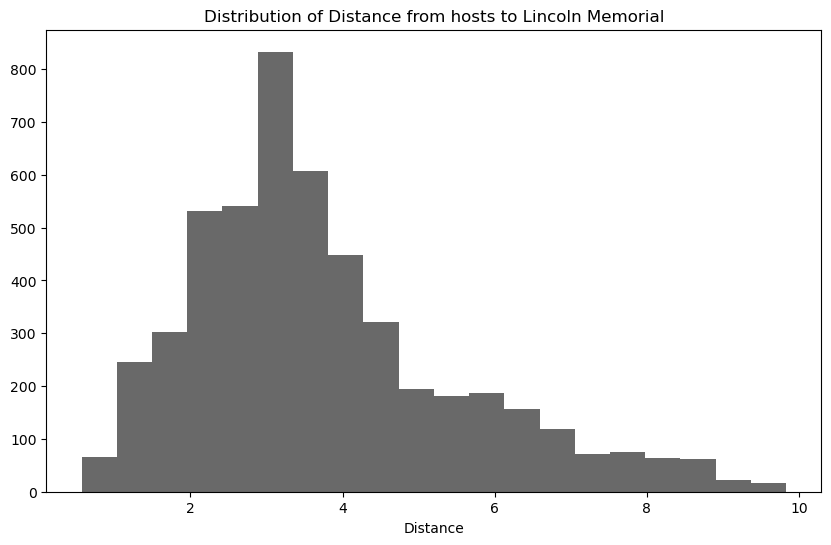

In [170]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_lincoln, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to Lincoln Memorial")
axes.set_xlabel("Distance")

plt.show()
plt.close()

The data looks only slightly skewed right. The distance from hosts to the Lincoln Memorial range is quite wide and depends on the location.

### Distance to Capitol 

The distance from hosts to the capital is measured in terms of miles.

In [171]:
vwListings.distance_capitol.describe()

count    5051.000000
mean        3.029403
std         1.844134
min         0.309378
25%         1.640830
50%         2.665941
75%         4.065983
max         9.611845
Name: distance_capitol, dtype: float64

The variable is definitely skewed. The mean is 3.08 miles and the median is 2.74 miles, or around 11% lower. The 3rd quartile is nearly 2.4x the 1st quartile. The minimum distance is "only" 0.31 miles and the maximum is 9.6 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

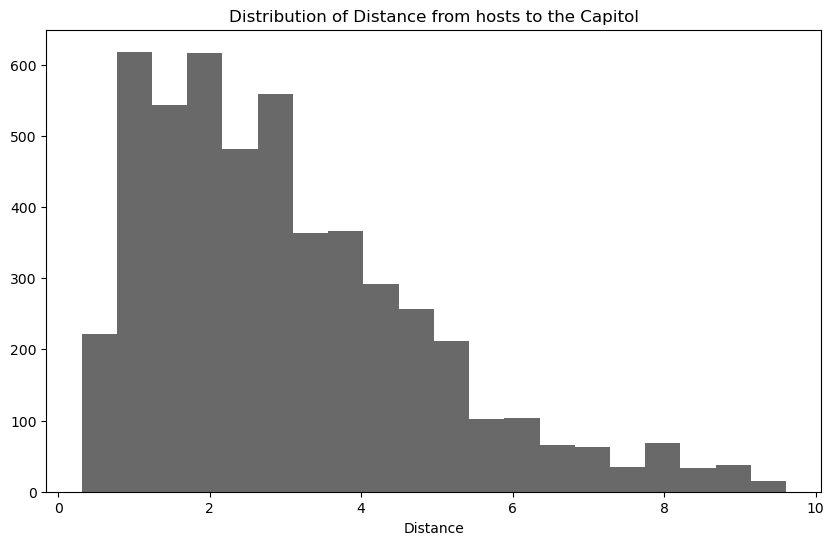

In [172]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_capitol, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to the Capitol")
axes.set_xlabel("Distance")

plt.show()
plt.close()

It is seen that the distribution does not appear to be normally distributed. The distance from hosts to the Capitol range is quite wide and depends on the location. It is noticed that there is a lot of distance around 2–3.5 miles, which is quite close to the Capitol.

### Distance to White House

The distance from hosts to the White house is measured in terms of miles.

In [173]:
vwListings.distance_white_house.describe()

count    5051.000000
mean        2.570906
std         1.728558
min         0.004724
25%         1.253446
50%         2.199972
75%         3.368155
max         8.297130
Name: distance_white_house, dtype: float64

The variable is definitely skewed. The mean is 2.60 miles and the median is 2.24 miles, or around 13.9% lower. The 3rd quartile is nearly 2.7x the 1st quartile. The minimum distance is "only" 0.004 miles and the maximum is 8.29 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

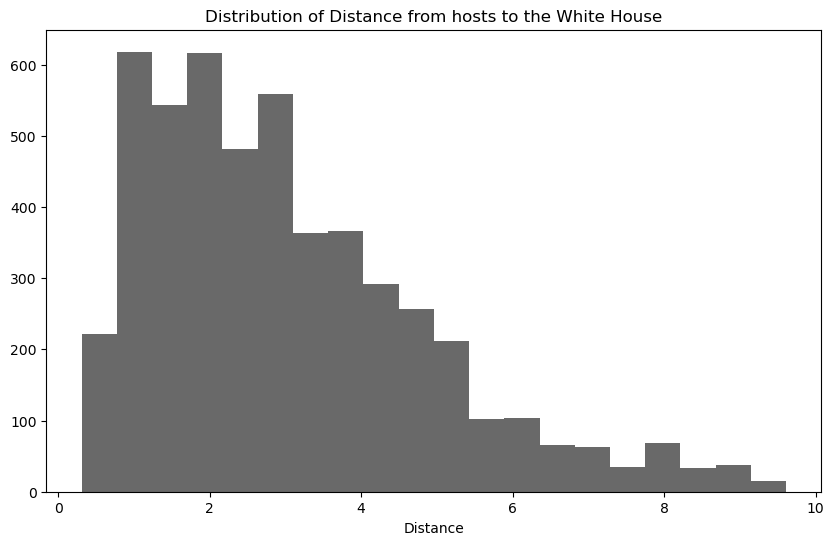

In [174]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_capitol, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to the White House")
axes.set_xlabel("Distance")

plt.show()
plt.close()

The data looks only left-skewed distribution. The distance from hosts to the White House range is quite wide and depends on the location.

### Distance to Library Congress

The distance from hosts to the Library Congress is measured in terms of miles.

In [175]:
vwListings.distance_library_congress.describe()

count    5051.000000
mean        3.098517
std         1.905029
min         0.072757
25%         1.575898
50%         2.872237
75%         4.120285
max         9.780604
Name: distance_library_congress, dtype: float64

The minimum distance is 0.07 and the maximum is 9.78 miles, so there may be a few extremes in the data, but the main concentration of data indicates that the data may be slightly skewed. The mean is 3.15 miles, and the median is nearly that at 2.94 miles. The first quartile is 1.73 miles and the third quartile is 4.15 miles, both about equidistant from the median or mean.

Let's plot the data using a histogram:

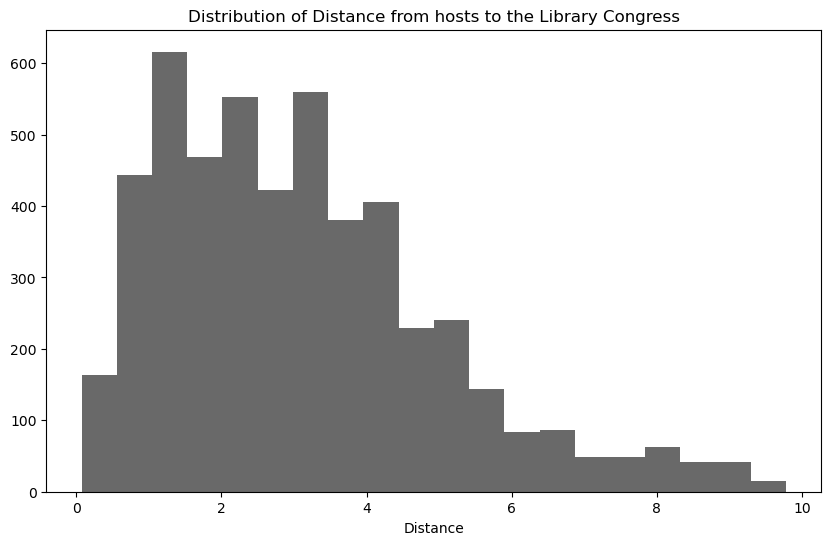

In [176]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_library_congress, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to the Library Congress")
axes.set_xlabel("Distance")

plt.show()
plt.close()

The data looks only left-skewed distribution. The distance from hosts to the Library Congress range is quite wide and depends on the location.

### Distance to Nationals Park

The distance from hosts to the Nationals Park is measured in terms of miles.

In [177]:
vwListings.distance_nationals_park.describe()

count    5051.000000
mean        3.887200
std         1.995992
min         0.065556
25%         2.464791
50%         3.598159
75%         4.935541
max        10.936207
Name: distance_nationals_park, dtype: float64

The minimum distance is 0.07 and the maximum is 10.94 miles, so there may be a few extremes in the data, but the main concentration of data indicates that the data may be normally distribution. The mean is 3.93 miles, and the median is nearly that at 3.64 miles. The first quartile is 2.66 miles and the third quartile is 4.92 miles, both about equidistant from the median or mean.

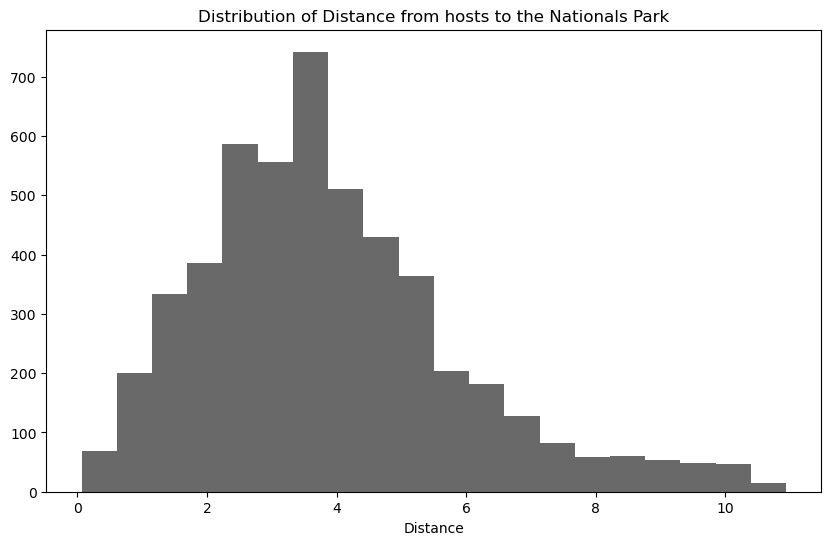

In [178]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_nationals_park, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to the Nationals Park")
axes.set_xlabel("Distance")

plt.show()
plt.close()

The distribution looks very nearly normal but slightly skewed left.

### Distance to National Zoo

The distance from hosts to the Nationals Zoo is measured in terms of miles.

In [179]:
vwListings.distance_national_zoo.describe()

count    5051.000000
mean        3.457983
std         1.936681
min         0.122430
25%         1.901342
50%         3.118129
75%         4.653178
max        10.361138
Name: distance_national_zoo, dtype: float64

The variable is definitely skewed. The mean is 3.46 miles and the median is 3.13 miles, or around 9.5% lower. The 3rd quartile is nearly 2.4x the 1st quartile. The minimum distance is "only" 0.12 miles and the maximum is 10.36 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

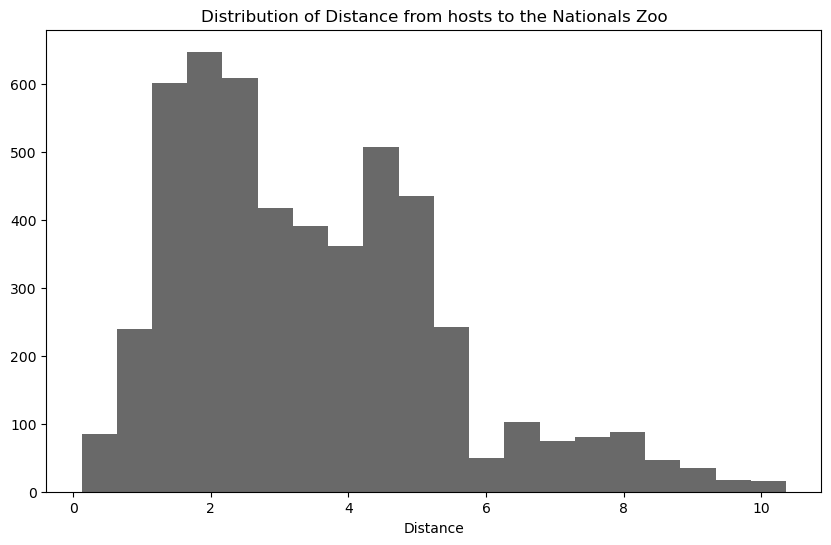

In [180]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_national_zoo, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to the Nationals Zoo")
axes.set_xlabel("Distance")

plt.show()
plt.close()

It is seen that the distribution does not appear to be normally distributed. A distance range is quite wide and depends on the location.

### Distance to Railway

The distance from hosts to the Main DC railway station (Union Station) is measured in terms of miles.

In [181]:
vwListings.distance_railway.describe()

count    5051.000000
mean        2.798317
std         1.806646
min         0.137688
25%         1.422551
50%         2.537105
75%         3.790847
max         9.103872
Name: distance_railway, dtype: float64

The variable is slightly skewed. The mean is 2.84 miles and the median is 2.57 miles, or around 9% lower. The 3rd quartile is nearly 2.6x the 1st quartile. The minimum distance is "only" 0.14 miles and the maximum is 9.10 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

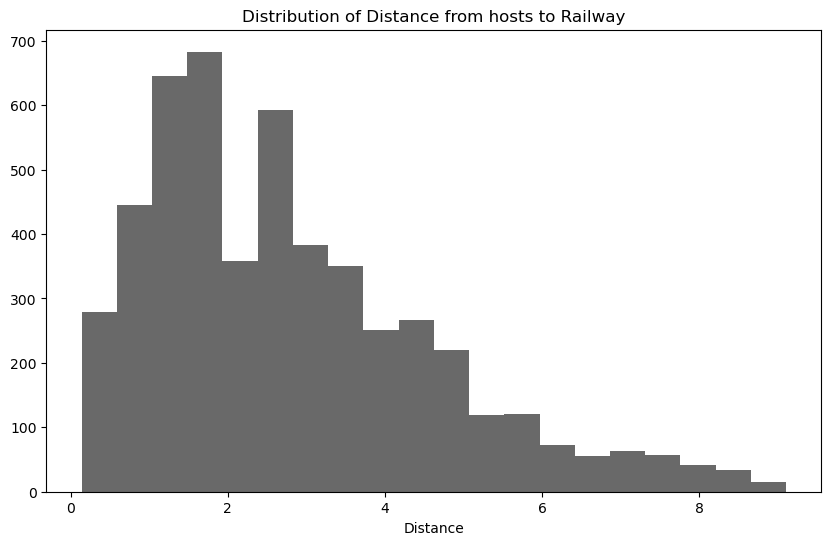

In [182]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_railway, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to Railway")
axes.set_xlabel("Distance")

plt.show()
plt.close()

The data looks only left-skewed distribution. The distance from hosts to the Main DC railway station (Union Station) range is quite wide and depends on the location.

### Distance to McPherson

The distance from hosts to Mcpherson Sq Metro Station (station is the nearest one to Downtown Washington DC) is measured in terms of miles.

In [183]:
vwListings.distance_mcpherson.describe()

count    5051.000000
mean        2.810265
std         1.757758
min         0.089814
25%         1.466579
50%         2.398454
75%         3.603792
max         8.810736
Name: distance_mcpherson, dtype: float64

The variable is slightly skewed. The mean is 2.83 miles and the median is 2.41 miles, or around 13% lower. The 3rd quartile is nearly 2.4x the 1st quartile. The minimum distance is "only" 0.09 miles and the maximum is 8.8 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

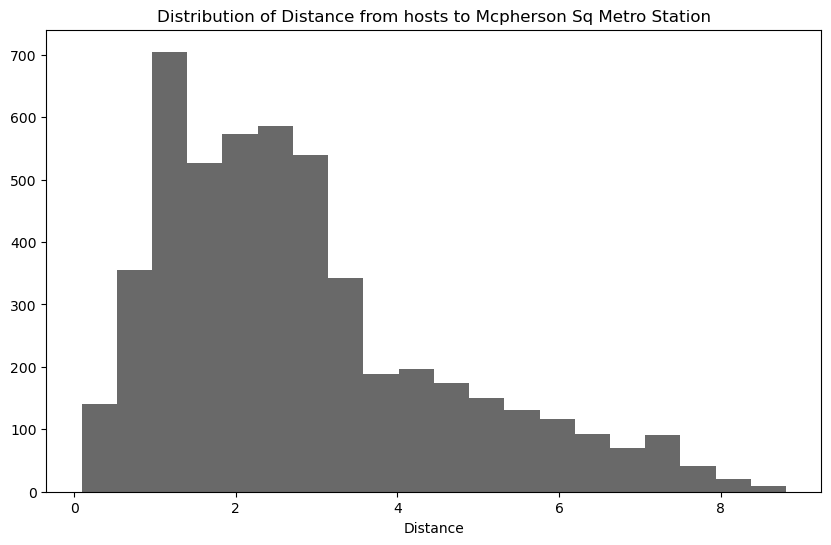

In [184]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_mcpherson, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to Mcpherson Sq Metro Station")
axes.set_xlabel("Distance")

plt.show()
plt.close()

It is seen that the distribution does not appear to be normally distributed. The distance from hosts to the Mcpherson Sq Metro Station range is quite wide and depends on the location. It is noticed that there is a lot of distance around 1–3 miles, which is quite close to the Capitol.

## Listings - pairwise EDA

Next, we will perform pairwise EDA between price and important variables.

In [185]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

### Price vs. Host response rate

In [186]:
price_response_rate = vwListings[['price', 'host_response_rate']]
price_response_rate.drop(price_response_rate.loc[price_response_rate['price']==0].index, inplace=True)
price_response_rate.drop(price_response_rate.loc[price_response_rate['host_response_rate']=='N/A'].index, inplace=True)
price_response_rate.dropna(inplace=True)
price_response_rate.host_response_rate = pd.to_numeric(price_response_rate.host_response_rate)

In [187]:
print("r   = ", stats.pearsonr(price_response_rate.price, price_response_rate.host_response_rate)[0])
print("rho = ", stats.spearmanr(price_response_rate.price, price_response_rate.host_response_rate)[0])

r   =  0.013368633185506237
rho =  -0.05567665978133375


Pearson's correlation coefficient, $r$, is only 0.0134 which indicates a weak positive relationship. Spearman's is at -0.0557 which might indicate that the weak negative monotonic relationship. Let's plot the data:

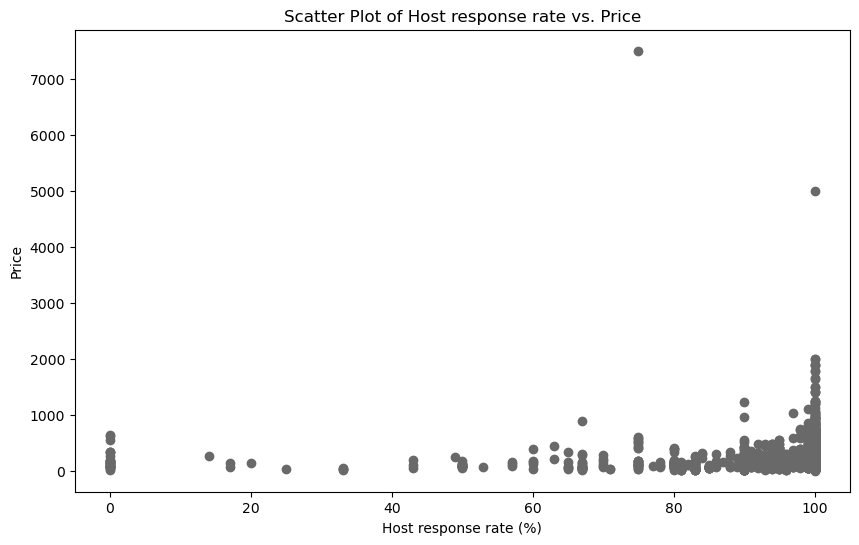

In [188]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(price_response_rate.host_response_rate, price_response_rate.price, marker="o", color="DimGray")

axes.set_ylabel("Price")
axes.set_xlabel("Host response rate (%)")
axes.set_title("Scatter Plot of Host response rate vs. Price")

plt.show()
plt.close()

The majority of the data points are located in the bottom right corner. it means that it is common to see the host response rate is between 90% to 100%. However, it does not look like there is an existing relationship between Host response rate and Price because no matter the host response rate is, the majority of the unit price is less than 1000 dollars per night. And also, we can see one outlier in this chart. That outlier has 100% in host response rate but the price up to 5000 dollars per night.

### Price vs. Host acceptance rate

In [189]:
price_acceptance_rate = vwListings[['price', 'host_acceptance_rate']]
price_acceptance_rate.drop(price_acceptance_rate.loc[price_acceptance_rate['price']==0].index, inplace=True)
price_acceptance_rate.drop(price_acceptance_rate.loc[price_acceptance_rate['host_acceptance_rate']=='N/A'].index, inplace=True)
price_acceptance_rate.dropna(inplace=True)
price_acceptance_rate.host_acceptance_rate = pd.to_numeric(price_acceptance_rate.host_acceptance_rate)

In [190]:
print("r   = ", stats.pearsonr(price_acceptance_rate.price, price_acceptance_rate.host_acceptance_rate)[0])
print("rho = ", stats.spearmanr(price_acceptance_rate.price, price_acceptance_rate.host_acceptance_rate)[0])

r   =  0.08736690755926316
rho =  0.1184553733810365


Pearson's correlation coefficient, $r$, is only 0.0087 which indicates a very weak positive relationship. Spearman's is at 0.118 which might indicate that a very weak positive monotonic relationship. Let's plot the data:

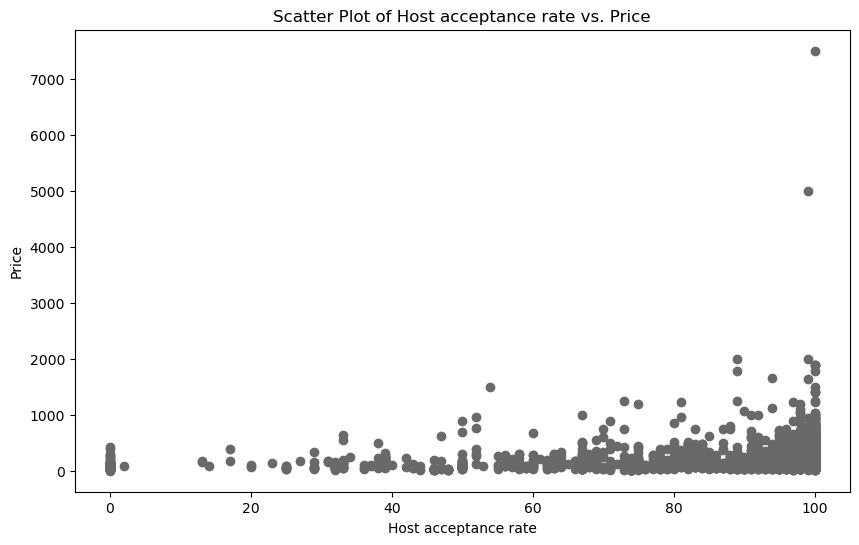

In [191]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(price_acceptance_rate.host_acceptance_rate, price_acceptance_rate.price, marker="o", color="DimGray")

axes.set_ylabel("Price")
axes.set_xlabel("Host acceptance rate")
axes.set_title("Scatter Plot of Host acceptance rate vs. Price")

plt.show()
plt.close()

Similar to Host response rate vs. Price, it is kinda obvious that there is no relationship between Host acceptance rate vs. Price. All the data points are at the bottom right corner. There is one outlier as well. Basically, all the unit price seems common to be under 1000 dollars per night no matter the host acceptance rate is.

### Price vs. Host is superhost

In [192]:
price_superhost = vwListings[['price', 'host_is_superhost']].copy()

In [193]:
price_superhost['host_is_superhost'] = price_superhost['host_is_superhost'].replace({'': 'f'})

In [194]:
describe_by_category(price_superhost, "price", "host_is_superhost", transpose=True)

host_is_superhost            f            t
count              3298.000000  1753.000000
mean                192.069133   195.274957
std                 262.142615   177.957314
min                  10.000000    22.000000
25%                  85.000000    98.000000
50%                 138.000000   145.000000
75%                 225.000000   222.000000
max                7500.000000  2000.000000


Based on the statistics above, the mean price of not-a-superhost is lower than a superhost by 10 dollars per night. However, the maximum price which is 7,500 dollars is listed under not-a-superhost. The standard deviation of non-superhost is 

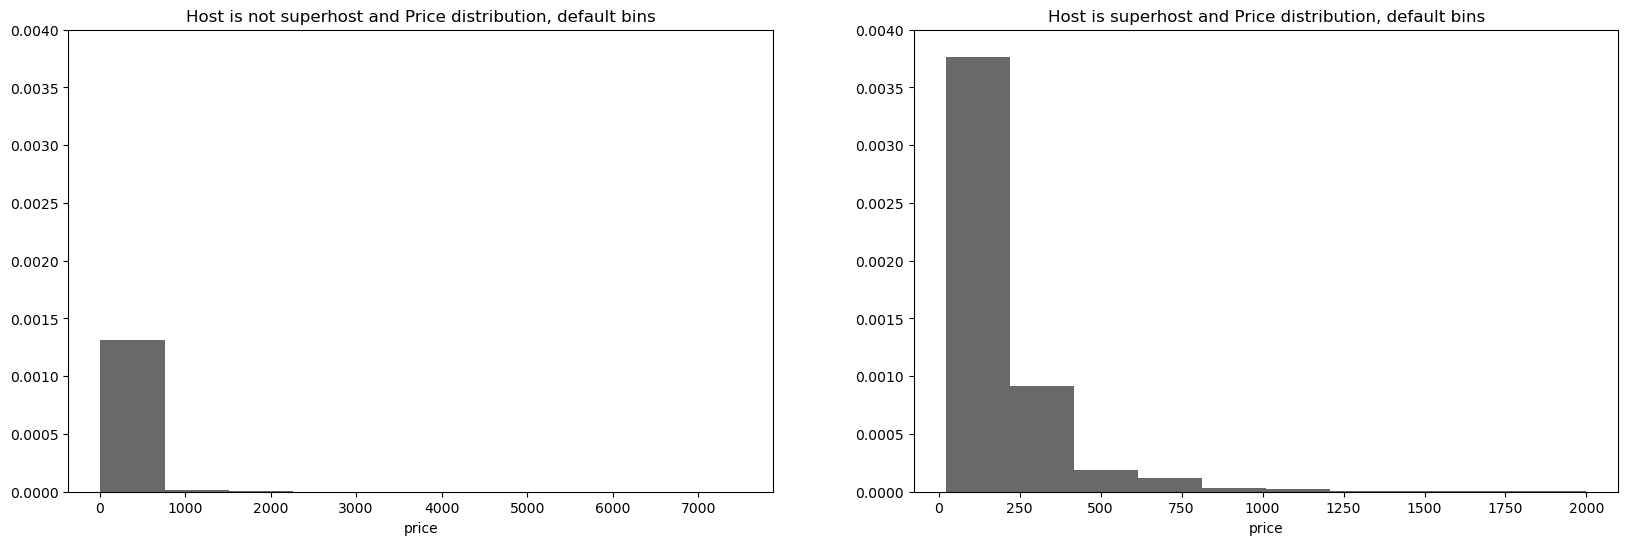

In [195]:
grouped = price_superhost.groupby("host_is_superhost")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["price"].get_group("f"), color="DimGray", density=True)
axes.set_title("Host is not superhost and Price distribution, default bins")
axes.set_xlabel("price")
axes.set_ylim((0,0.0040))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["price"].get_group("t"), color="DimGray", density=True)
axes.set_title("Host is superhost and Price distribution, default bins")
axes.set_xlabel("price")
axes.set_ylim((0,0.0040))

plt.show()
plt.close()

Based on the two distributions above, if the host is a superhost, it looks like they can charge more money per night. From 250 dollars per night as, the density/frequency on the superhost chart is higher.

### Price vs. Host has profile pic

In [196]:
price_profile = vwListings[['price', 'host_has_profile_pic']].copy()

In [197]:
price_profile['host_has_profile_pic'] = price_profile['host_has_profile_pic'].replace({'': 'f'})

In [198]:
describe_by_category(price_profile, "price", "host_has_profile_pic", transpose=True)

host_has_profile_pic           f           t
count                  35.000000  5016.00000
mean                  176.228571   193.30004
std                   168.108523   236.74860
min                    25.000000    10.00000
25%                    69.000000    90.00000
50%                   115.000000   140.00000
75%                   175.500000   225.00000
max                   638.000000  7500.00000


As we mentioned above, the are many more hosts with the profile picture than the number of hosts not having it. We can see from the statistics above, the hosts with profile picture charged more per night in terms of mean price, 193 dollars per night versus 176 dollars per night. The 1s quartile, 2nd quartile and 3rd quartile of the hosts having profile picture have higher price than the hosts without profile picture.

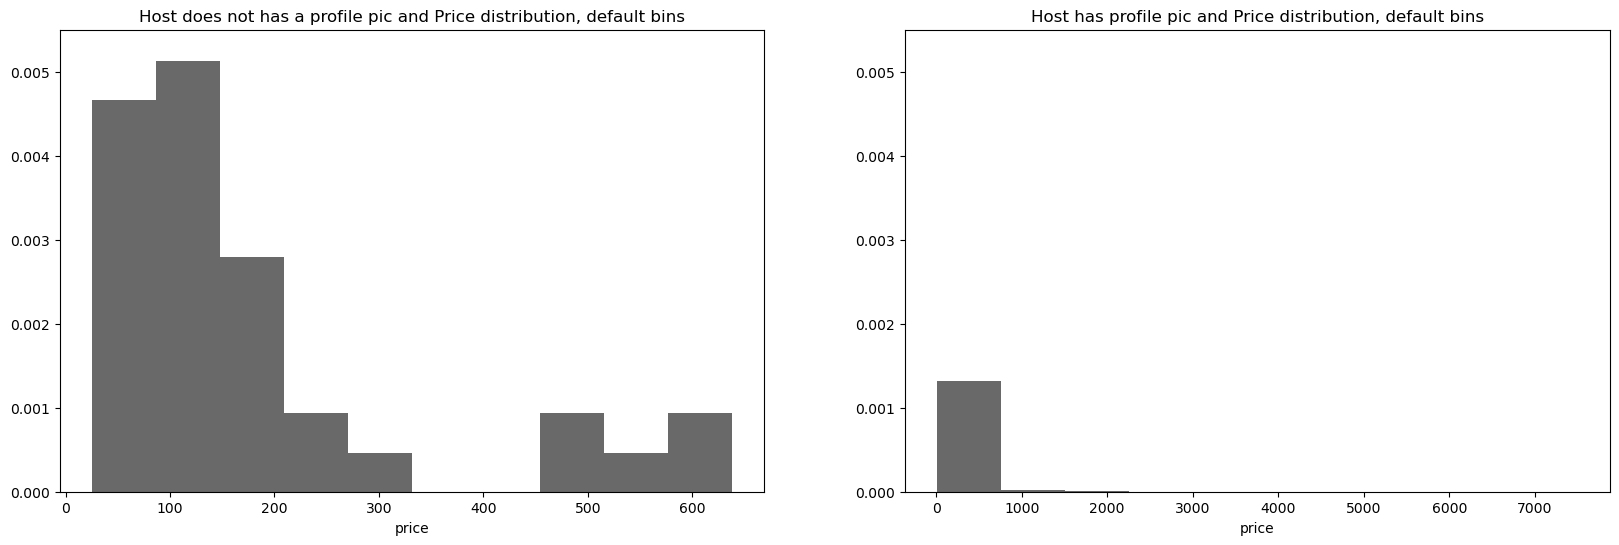

In [199]:
grouped = price_profile.groupby("host_has_profile_pic")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["price"].get_group("f"), color="DimGray", density=True)
axes.set_title("Host does not has a profile pic and Price distribution, default bins")
axes.set_xlabel("price")
axes.set_ylim((0,0.0055))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["price"].get_group("t"), color="DimGray", density=True)
axes.set_title("Host has profile pic and Price distribution, default bins")
axes.set_xlabel("price")
axes.set_ylim((0,0.0055))

plt.show()
plt.close()

Based on the two charts above, hosts with profile pictures charged more than the hosts without profile picture. The maximum price of the hosts without profile picture is around 600 dollars per night while the 600 dollars per night is a common unit price for airbnb with the hosts having profile pictures. However, we should keep in mind that the numbers of hosts without profile picture in this data set is so tiny compared to the number of hosts with profile picture. So it is still not a fair comparison.

### Price vs. Host identity verified

In [200]:
price_identity = vwListings[['price', 'host_identity_verified']].copy()

In [201]:
price_identity['host_identity_verified'] = price_identity['host_identity_verified'].replace({'': 'f'})

In [202]:
describe_by_category(price_identity, "price", "host_identity_verified", transpose=True)

host_identity_verified            f            t
count                    615.000000  4436.000000
mean                     209.837398   190.872633
std                      385.168341   207.403672
min                       10.000000    20.000000
25%                       86.000000    90.000000
50%                      135.000000   140.000000
75%                      203.000000   226.000000
max                     7500.000000  5995.000000


Althought the number of hosts with identity is verified is higher than the number of hosts without identity is verified, the mean price of the hosts without identity verified is higher. However, the price in terms of minimum price, the 1st quartile, the 2nd quartile and the 3rd quartile price of the hosts with identity verified is higher. Let's plot to see:

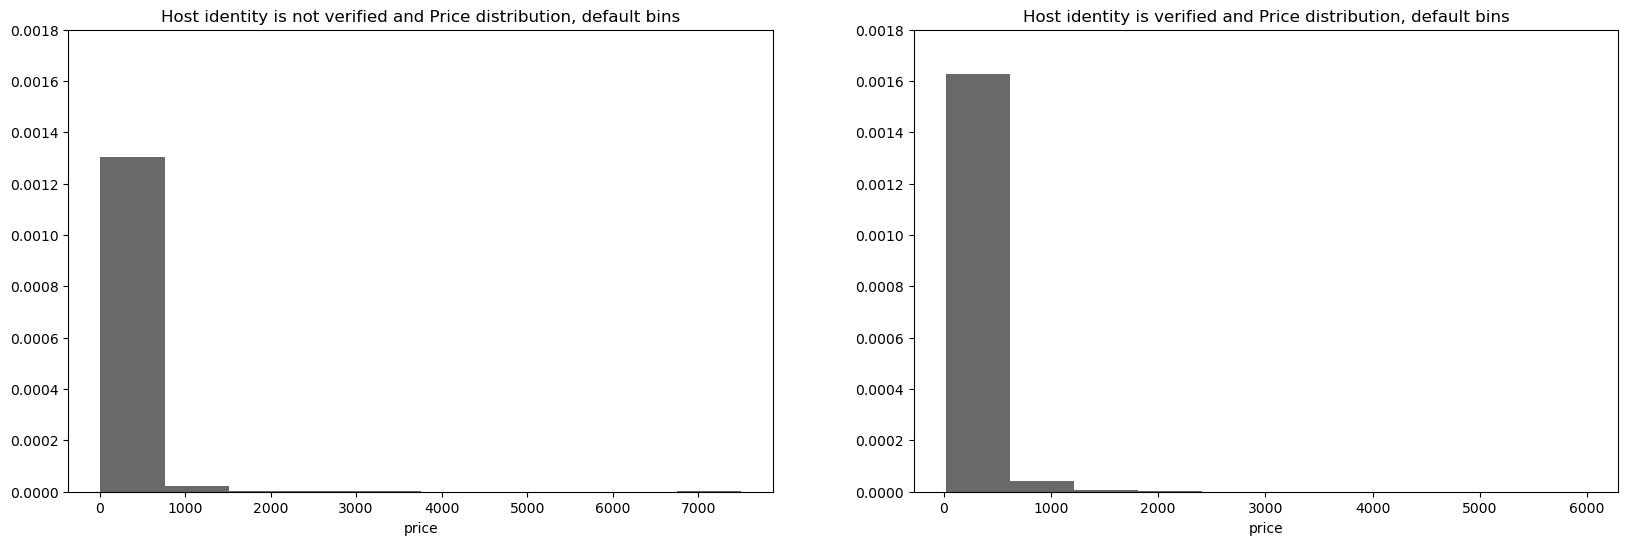

In [203]:
grouped = price_identity.groupby("host_identity_verified")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["price"].get_group("f"), color="DimGray", density=True)
axes.set_title("Host identity is not verified and Price distribution, default bins")
axes.set_xlabel("price")
axes.set_ylim((0,0.0018))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["price"].get_group("t"), color="DimGray", density=True)
axes.set_title("Host identity is verified and Price distribution, default bins")
axes.set_xlabel("price")
axes.set_ylim((0,0.0018))

plt.show()
plt.close()

The two charts are pretty similar. The only difference is that the number of hosts with identity verified is higher. Nothing is much special here.

In [204]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    r = stats.pearsonr(data[x], data[y])[0]
    print( "r   =", r, f"({classify_correlation(r)})")
    rho = stats.spearmanr(data[x], data[y])[0]
    print( "rho =", rho, f"({classify_correlation(rho)})")

In [205]:
def classify_correlation(r):
    r = abs(r)
    if r < 0.16:
        return "very weak"
    if r < 0.29:
        return "weak"
    if r < 0.49:
        return "low"
    if r < 0.69:
        return "moderate"
    if r < 0.89:
        return "strong"
    return "very strong"

### Price v. Neighbourhood cleansed

Overall, neighbourhood_cleansed should affect price and there should be noticeable differences in price based on where the listing is located. Factors that help determine this could be things to do around the area, public transportation available, safety and crime, and income levels. 

In [206]:
tempDF = vwListings
tempDF["neighbourhood_cleansed"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['neighbourhood_cleansed'], inplace=True)

In [207]:
describe_by_category(tempDF, "price", "neighbourhood_cleansed", transpose=True)

neighbourhood_cleansed  Brightwood Park, Crestwood, Petworth  \
count                                             259.000000   
mean                                              133.718147   
std                                               104.382281   
min                                                30.000000   
25%                                                66.500000   
50%                                               100.000000   
75%                                               150.000000   
max                                               626.000000   

neighbourhood_cleansed  Brookland, Brentwood, Langdon  \
count                                       78.000000   
mean                                       149.679487   
std                                         95.832171   
min                                         29.000000   
25%                                         86.750000   
50%                                        118.500000   
75%                     

Overall, there are noticeable differences in different neighbourhoods and their price. For example, the neighbourhoods with the lowest median price include "Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights", "Congress Heights, Bellevue, Washington Highlands", "Capitol View, Marshall Heights, Benning Heights". Each of these neighbourhoods have a median price listing of 80 to 89. For the neighbourhoods with the highest median price, there is a significant gap in comparison with the lower median prices. For example, "Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point" has a median listing price of 215. West End, Foggy Bottom, GWU has a median price listing of 198 which is the neighbourhood around George Washington University which is a significant factor in driving up the price of the listings in the area. The most expensive neighbourhood is Woodland/Fort Stanton, Garfield Heights, Knox Hill with a median listing price of 230.

### Property type vs. Room type

Earlier we noticed more listings with property_type = 'Room in hotel' than room_type = 'Hotel room'. We look more closely at listings whose property_type begins with 'room':

In [208]:
pd.DataFrame(vwListings.loc[vwListings['property_type'].str.split().str.get(0) == 'Room', ['room_type', 'property_type']].value_counts())

0
room_type       property_type                
Private room    Room in hotel              84
Entire home/apt Room in aparthotel         15
Private room    Room in boutique hotel     13
Hotel room      Room in hostel              9
                Room in bed and breakfast   5
                Room in boutique hotel      1

There are 117 Rooms in boutiqe hotels and 98 Rooms in hotels with room_type = 'Private room' instead of 'Hotel room'.

In [209]:
pd.DataFrame(vwListings.loc[vwListings['room_type'] == 'Hotel room', 'property_type'].value_counts())

,property_type
Room in hostel,9
Room in bed and breakfast,5
Room in boutique hotel,1


In addition to 'Room in boutique hotel' and 'Room in hotel', 'Private room in bed and breakfast' is another property_type that isn't listed as a hotel room but should be. More evidence for this can be found by comparing property_type with price.

###  Price vs. Property type

We look at descriptive statistics for the top 20 property types by count.

In [210]:
vwListings.groupby('property_type')['price'].describe().sort_values('count', ascending=False).head(20).sort_index()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Entire condo,332.0,156.801205,88.345464,39.0,99.00,134.5,181.75,750.0
Entire guest suite,365.0,115.515068,48.598409,41.0,85.00,103.0,133.00,396.0
Entire guesthouse,54.0,219.685185,233.592115,66.0,110.00,130.0,183.75,1237.0
Entire home,596.0,345.006711,513.362483,10.0,150.00,244.0,361.75,7500.0
Entire loft,21.0,166.904762,89.406322,64.0,99.00,149.0,200.00,442.0
Entire rental unit,1840.0,169.132609,106.936814,40.0,109.00,147.0,197.00,1235.0
Entire serviced apartment,202.0,313.777228,92.153154,65.0,269.00,305.0,350.00,716.0
Entire townhouse,444.0,286.180180,219.391080,45.0,159.00,225.0,349.25,2200.0
Private room in bed and breakfast,32.0,278.562500,178.062319,66.0,108.25,254.0,420.25,616.0


Unsurprisingly, shared rooms have the lowest mean price. "Entire" listings also generally have higher mean price than private rooms, which are generally low. Somewhat surprisingly, rooms in hotels (including private rooms in bed and breakfasts) have some of the highest prices. This gives us more evidence that 'Room in hotel', 'Room in boutique hotel', and 'Private room in bed and breakfast' should be grouped together with hotel rooms instead of with private rooms. 

We create a new feature room_type_mod that implements this change.

In [211]:
vwListings['room_type_mod'] = vwListings['room_type']
vwListings.loc[vwListings['property_type'].isin(['Room in hotel', 'Room in boutique hotel', 'Private room in bed and breakfast']),
        'room_type_mod'] = 'Hotel room'

### Price vs. Room type 

We look at descriptive statistics for room_type and room_type_mod.

In [212]:
vwListings.groupby('room_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,3895.0,212.432863,243.827784,10.0,111.0,158.0,250.0,7500.0
Hotel room,15.0,42.400000,42.125323,25.0,25.0,29.0,29.0,175.0
Private room,1079.0,134.243744,201.204257,20.0,51.0,71.0,109.5,2000.0
Shared room,62.0,45.967742,14.710282,25.0,35.0,45.0,53.0,88.0


In [213]:
vwListings.groupby('room_type_mod')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type_mod,,,,,,,,
Entire home/apt,3895.0,212.432863,243.827784,10.0,111.0,158.0,250.00,7500.0
Hotel room,144.0,434.381944,353.285419,25.0,202.0,416.0,533.25,1903.0
Private room,950.0,87.298947,107.067094,20.0,50.0,66.0,90.00,2000.0
Shared room,62.0,45.967742,14.710282,25.0,35.0,45.0,53.00,88.0


The changes of the previous section greatly increase the Hotel room mean price, making it the highest at 335. They also greatly decrease the Private room mean price, making it the second-lowest at 89. Entire home/apt has the second-highest mean of 202 and Shared room has the lowest mean of 54. 

For each room_type, the median is lower than the mean and closer to the 25th percentile than the 75th percentile. This indicates right-tailed distributions, which we verify by displaying price histograms for each room_type_mod.

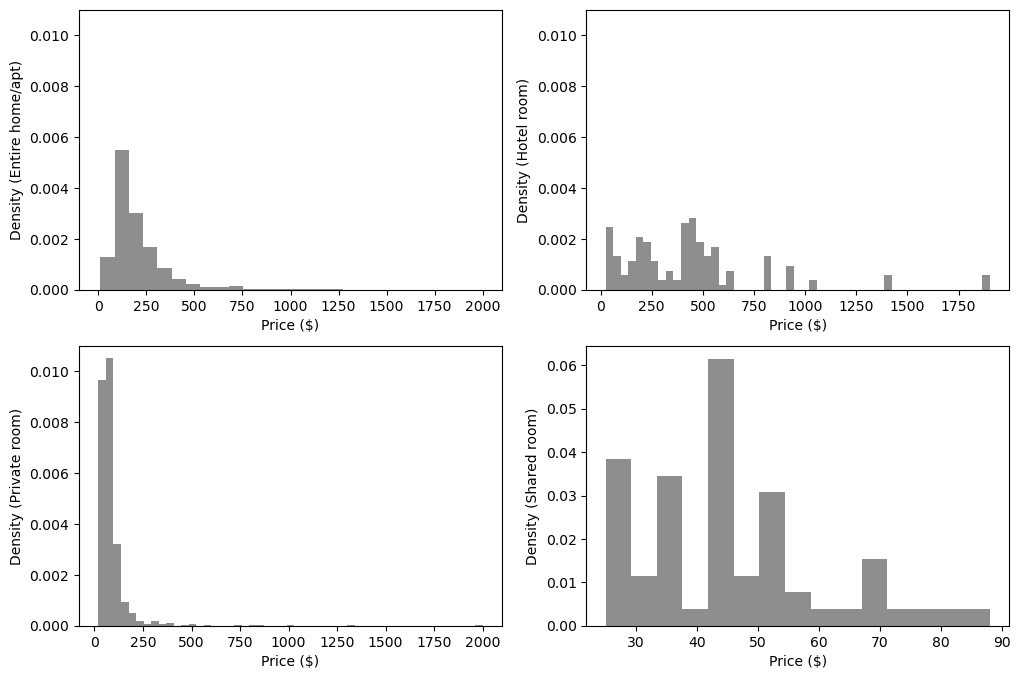

In [214]:
figure = plt.figure(figsize=(12,8))

axes = figure.add_subplot(2, 2, 1)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Entire home/apt', 'price'], 
                             color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Entire home/apt)")
axes.set_ylim(0, 0.011)
axes.set_xlim(-100, 2100)

axes = figure.add_subplot(2, 2, 2)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Hotel room','price'], 
                             color="DimGray", density=True, bins=51, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Hotel room)")
axes.set_ylim(0, 0.011)

axes = figure.add_subplot(2, 2, 3)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Private room', 'price'],
                             color="DimGray", density=True, bins=51, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Private room)")
axes.set_ylim(0, 0.011)

axes = figure.add_subplot(2, 2, 4)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Shared room','price'], 
                             color="DimGray", density=True, bins=15, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Shared room)")

plt.show()
plt.close()

Each room type has a right-skewed distribution, though the skew is more pronounced for 'Entire home/apt' and 'Private room'.

### Price vs. Accommodates

Accommodates describes the maximum capacity of the Airbnb listing. Overall, it should affect price as it would mean more guests would be staying at the listing. More resources are required to host the guests therefore increasing cost for the owner and needing to increase the price. We expect there to be a moderate to strong correlation between accommodates and price.

In [215]:
tempDF = vwListings
tempDF["accommodates"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['accommodates'], inplace=True)

In [216]:
correlation(tempDF, "price", "accommodates")

Correlation coefficients:
r   = 0.46338312740291115 (low)
rho = 0.5944485964516211 (moderate)


Pearson's correlation coefficient 𝑟, outputs as 0.46 which indicates a low positive relationship. For Spearman's coefficient, it is slightly higher at 0.59 which indicates a moderate positive relationship. We can plot the data to get a visualization of this pairwise relationship.

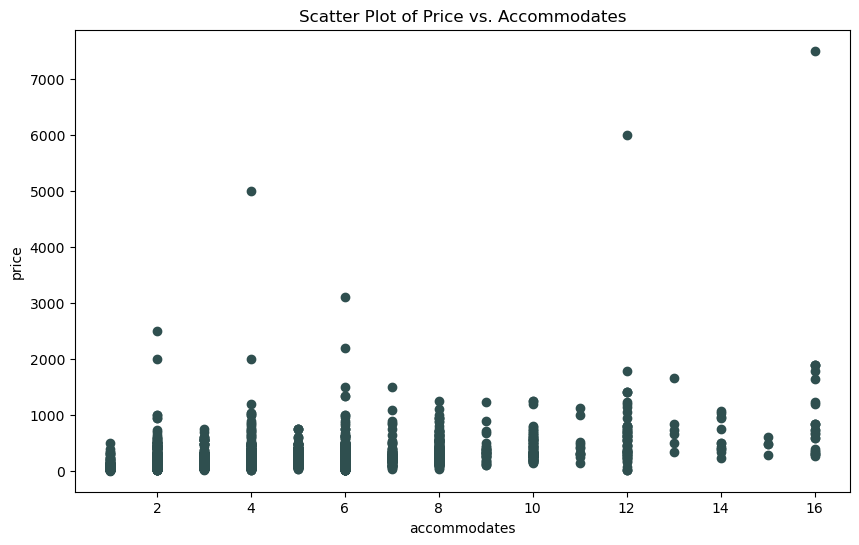

In [217]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( tempDF["accommodates"], tempDF["price"], marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("accommodates")
axes.set_title("Scatter Plot of Price vs. Accommodates")

plt.show()
plt.close()

When looking at the scatter plot visualization, there is a slight pattern as accommodates increases, then price increases. This would be reflective on the correlation coefficients that show a moderate positive relationship between accommodates and price. The scatter plot is indicative of that.

### Price vs. Bathrooms text

Overall, number of bathrooms should affect price as well as it would make a listing more desirable and could accommodate more guests for their stay. We expect there to be a moderate positive relationship between number of bathrooms and price.

In [218]:
tempDF = vwListings
tempDF["bathrooms_text"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['bathrooms_text'], inplace=True)

In [219]:
tempDF['bathroom_numbers'] = tempDF['bathrooms_text'].str.extract('(\d+)').astype(float)

In [220]:
correlation(tempDF, "price", "bathroom_numbers")

Correlation coefficients:
r   = 0.48169640125562024 (low)
rho = 0.43511337102407505 (low)


Pearson's correlation coefficient 𝑟, outputs as 0.48 which indicates a low positive relationship. For Spearman's coefficient, it is slightly higher at 0.43 which also indicates a low positive relationship. This is contrary to our belief that there is a moderate positive relationship between the two variables. We can plot the data to get a visualization of this pairwise relationship.

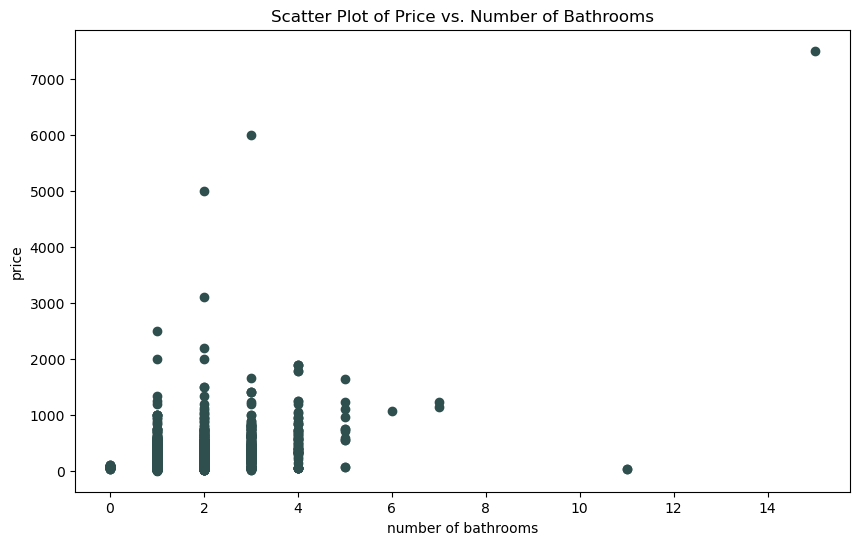

In [221]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( tempDF["bathroom_numbers"], tempDF["price"], marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("number of bathrooms")
axes.set_title("Scatter Plot of Price vs. Number of Bathrooms")

plt.show()
plt.close()

When looking at the scatter plot visualization, there is not really a pattern as number of bathrooms increases. This would be reflective on the correlation coefficients that show a low positive relationship between number of bathrooms and and price. However, there is a strong indication that a listing having no bathrooms will cap the ceiling of the airbnb listing price to under 200. As long as a listing has at least one bathroom then the price should be able to increase.

### Price vs. Bedrooms

Overall, number of bedrooms should affect price as well as it would make a listing more desirable and could accommodate more guests for their stay. We expect there to be a moderate positive relationship between number of bathrooms and price.

In [222]:
tempDF = vwListings
tempDF["bedrooms"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['bedrooms'], inplace=True)

In [223]:
correlation(tempDF, "price", "bedrooms")

Correlation coefficients:
r   = 0.4659204028738276 (low)
rho = 0.5288698821820434 (moderate)


Pearson's correlation coefficient 𝑟, outputs as 0.46 which indicates a low positive relationship. For Spearman's coefficient, it is slightly higher at 0.52 which also indicates a moderate positive relationship. This is contrary to our belief that there is a moderate positive relationship between the two variables. We can plot the data to get a visualization of this pairwise relationship.

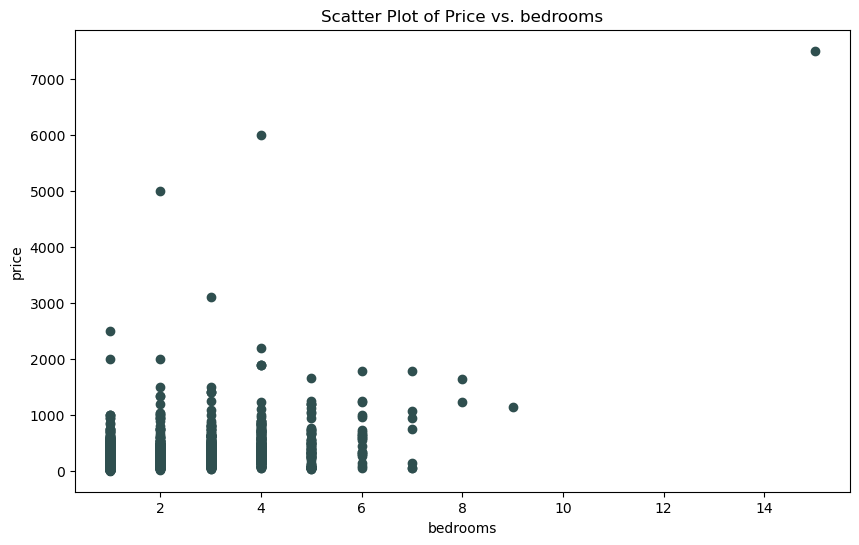

In [224]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( tempDF["bedrooms"], tempDF["price"], marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("bedrooms")
axes.set_title("Scatter Plot of Price vs. bedrooms")

plt.show()
plt.close()

When looking at the scatter plot visualization, there is not really a pattern as number of bathrooms increases. This would be reflective on the correlation coefficients that show a low positive relationship between number of bedrooms and and price.

Overall, number of beds should affect price as well as it would make a listing more desirable and could accommodate more guests for their stay. We expect there to be a moderate positive relationship between number of bathrooms and price.

### Price vs. Beds

In [225]:
tempDF = vwListings
tempDF["beds"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['beds'], inplace=True)

In [226]:
correlation(tempDF, "price", "beds")

Correlation coefficients:
r   = 0.4522341795615903 (low)
rho = 0.5298116480264583 (moderate)


Pearson's correlation coefficient 𝑟, outputs as 0.45 which indicates a low positive relationship. For Spearman's coefficient, it is slightly higher at 0.52 which also indicates a moderate positive relationship. We can plot the data to get a visualization of this pairwise relationship.

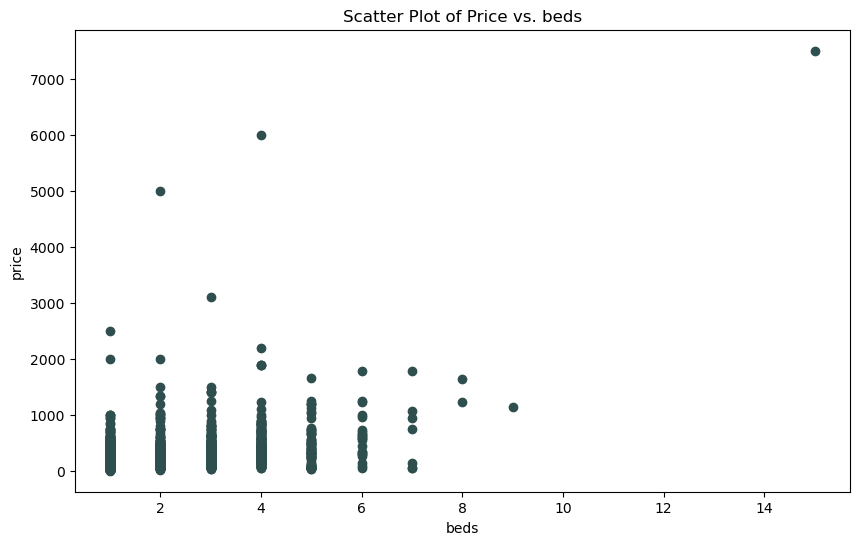

In [227]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( tempDF["bedrooms"], tempDF["price"], marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("beds")
axes.set_title("Scatter Plot of Price vs. beds")

plt.show()
plt.close()

When looking at the scatter plot visualization, there is not really a pattern as number of bathrooms increases. This would be reflective on the correlation coefficients that show a low positive to moderate relationship between number of beds and and price.

### Price vs. Minimum nights

We display a scatterplot of price vs. minimum nights, expecting the highest prices to be for short-term rentals.

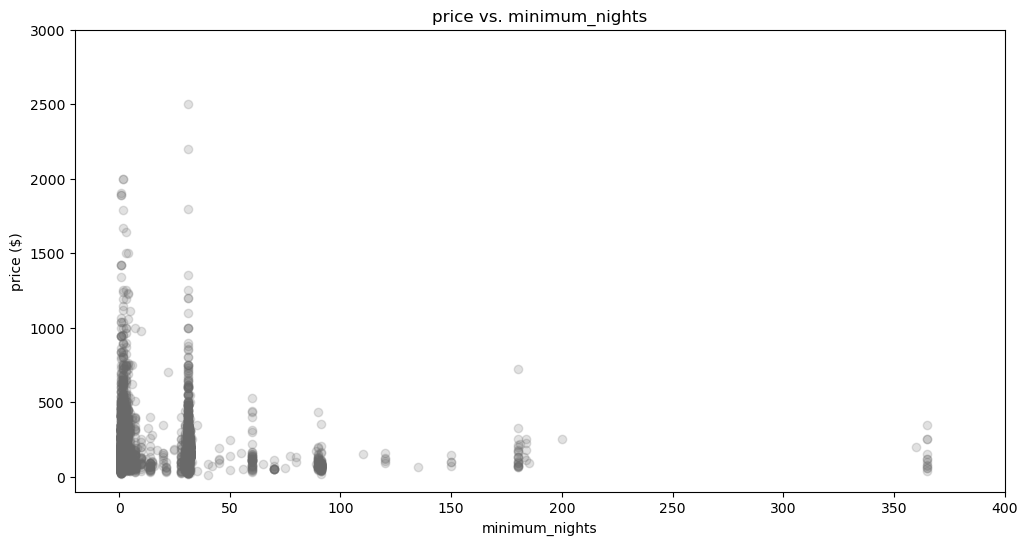

In [228]:
figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(min_nt, vwListings['price'], marker="o", color="dimgray", alpha=0.2)

axes.set_ylabel("price ($)")
axes.set_xlabel("minimum_nights")
axes.set_title("price vs. minimum_nights")

axes.set_xlim(-20, 400)
axes.set_ylim(-100, 3000)

plt.show()
plt.close()

As expected, the highest prices are generally in short-term rentals. There seems to be a negative relationship here. We calculate correlation coefficients to verify this.

In [229]:
print("r   = ", stats.pearsonr(vwListings['minimum_nights'], vwListings['price'])[0])
print("rho = ", stats.spearmanr(vwListings['minimum_nights'], vwListings['price'])[0])

r   =  -0.07700312552128755
rho =  -0.1596498024986026


Pearson's coefficient is only slightly negative at -0.077, indicating a weak negative relationship. Spearman's coefficient is lower at -0.159, indicating some non-linearity in the relationship.

### Has availability vs. Last review dates

If a listing has no availability, there are a few possibilities. It might simply be so popular that every available day for the upcoming year has been booked. It might be a dead listing that the host no longer makes available but hasn't removed from the site. Finally, it might be a brand-new listing that is still in the process of being set up by the host.

Listings that have no availability due to their popularity should clearly remain in the dataset, but the other two possibilities make good candidates to be dropped prior to modeling. To see which of these possibilities seem to hold, we look at has_availability against some other variables in the data.

A popular listing should have recent reviews. Of the 462 no-availability listings, how many even have reviews?

In [253]:
no_av = vwListings1[ha == 'f']

In [244]:
len(no_av[no_av['number_of_reviews'] > 0])

208

Only 208 have any reviews at all. To see if there are any popular no-availability listings, we display a histogram of last_review_dates for listings with no availability.

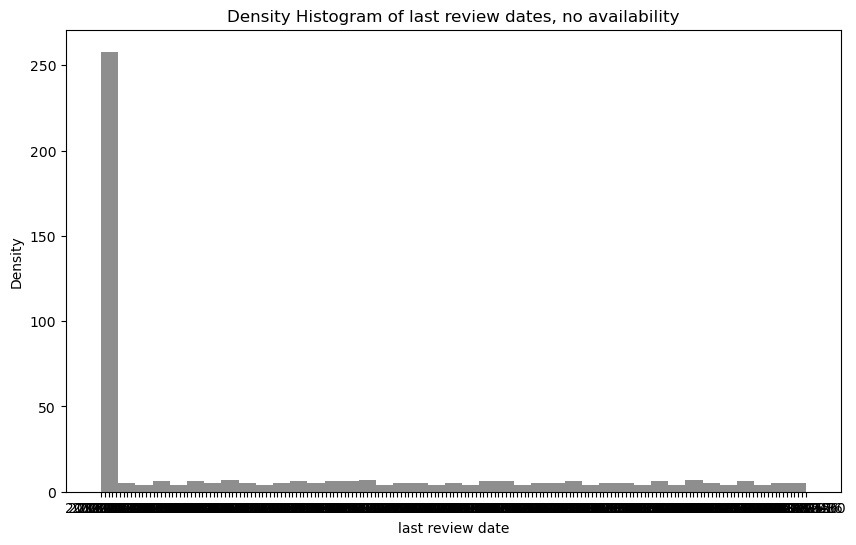

In [254]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(no_av['last_review'], color="DimGray", density=False, bins=41, alpha=0.75)
axes.set_xlabel("last review date")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of last review dates, no availability")

plt.show()
plt.close()

None of the no-availability listings got reviews in 2023, and only one of them got a review in 2022. Most got their last review before the COVID pandemic struck in early 2020. We conclude that none of these listings have no availability due to their popularity.

### Has availability vs. Host listings count

254 of 462 no-availability listings have no reviews at all, which means they might be brand-new listings. Such listings seem much more likely to also have brand-new hosts, especially if it's the host's only listing. We look at host_listings_count for no-review, no-availability listings.

In [247]:
no_r_no_av = no_av[no_av['number_of_reviews']==0]

In [248]:
pd.DataFrame(no_r_no_av['host_listings_count'].value_counts())

,host_listings_count
1,195
2,30
15,15
3,9
4,2
8,2
5,1


Of the 254 no-review, no-availability listings, 195 are a host's only listing and 30 are one of the host's two listings. 15 are all from the same host.

### Has availability vs. Host since

Most no-review, no-availability listings are their host's only listing. If these are brand-new listings, their hosts likely joined the site recently too. To investigate, we display a histogram of host_since for no-review, no-availability listings.

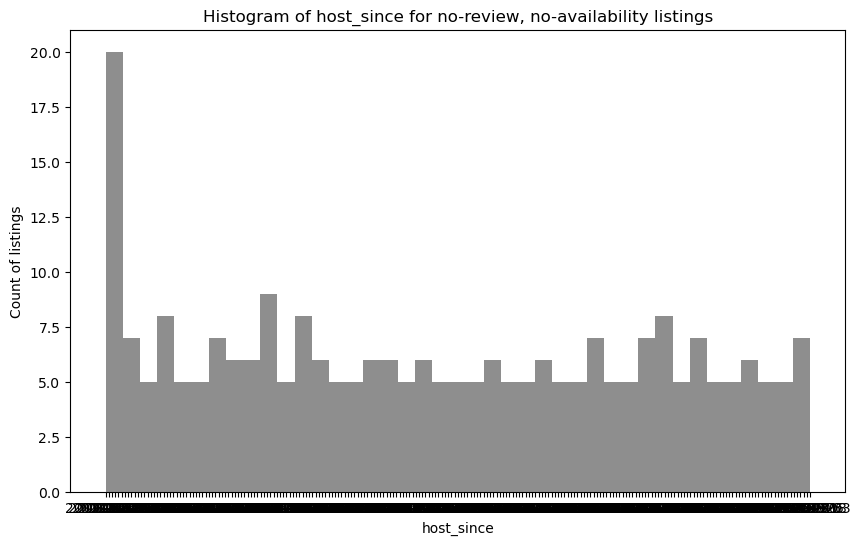

In [249]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(no_r_no_av['host_since'], color="DimGray", 
                             density=False, bins=41, alpha=0.75)
axes.set_xlabel("host_since")
axes.set_ylabel("Count of listings")
axes.set_title("Histogram of host_since for no-review, no-availability listings")

plt.show()
plt.close()

Only six of these listings have hosts who joined relatively recently (2022 or later). We take a closer look at these listings.

host_id = 488242955 had their listing on the site for a very short period of time. The other 5 seem like brand-new listings that their hosts have not finished setting up. 

In [257]:
vwListings2 = vwListings[ha == 't']

### Price vs. Number of reviews

We do not exepect the relation between price and number of review. Let's look first at correlation coefficients:

In [259]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.number_of_reviews)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.number_of_reviews)[0])

r   =  -0.07148517001096993
rho =  -0.07231723622873762


Pearson's correlation coefficient,  𝑟 , is only -0.05 which indicates a very weak negative relationship. Spearman's is at -0.04 which might indicate weak monotonic relationship. Let's plot the data:

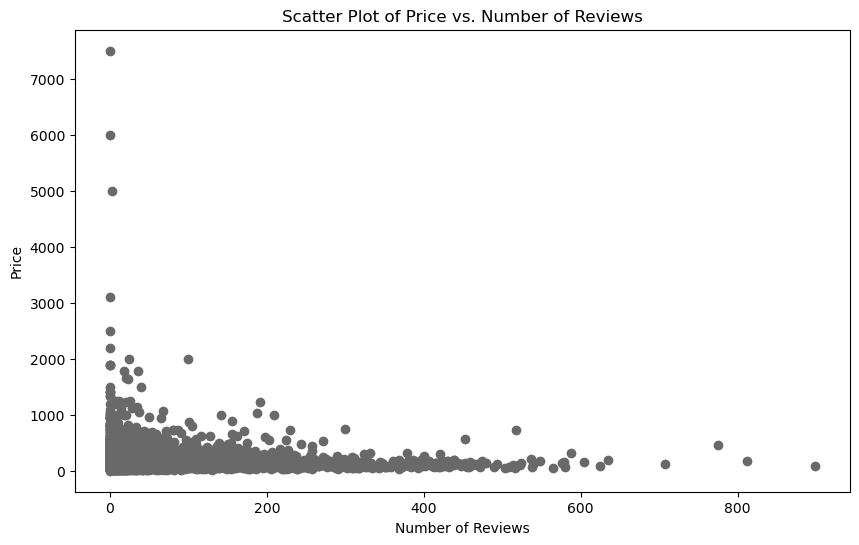

In [260]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( vwListings.number_of_reviews, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Number of Reviews")
axes.set_title("Scatter Plot of Price vs. Number of Reviews")

plt.show()
plt.close()

There appears to be no relationship between price and number of reviews as the data spreads in an unclear pattern.

### Price vs. Number of reviews ltm

We do not exepect the relation between price and number of review in the last 12 months .Let's look first at correlation coefficients:

In [261]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.number_of_reviews_ltm)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.number_of_reviews_ltm)[0])

r   =  -0.03393311425402641
rho =  0.03535877449899953


Pearson's correlation coefficient, 𝑟 , is only -0.03 which indicates a very weak negative relationship. Spearman's is at 0.03 which might indicate weak monotonic relationship. Let's plot the data:

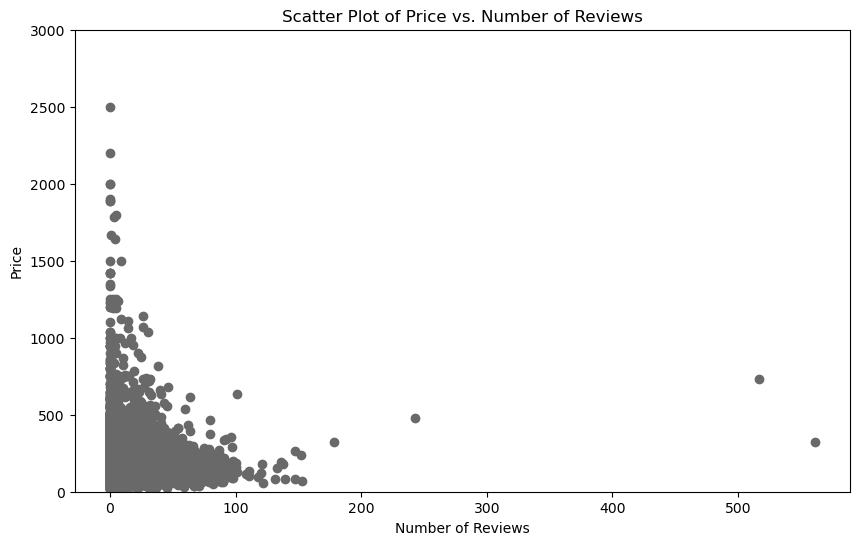

In [262]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( vwListings.number_of_reviews_ltm, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Number of Reviews")
axes.set_title("Scatter Plot of Price vs. Number of Reviews")

plt.ylim(0,3000)
plt.show()
plt.close()

There appears to be no relationship between price and number of reviews in the last 12 months as the data spreads in an unclear pattern.

### Price vs. Number of reviews l30d

We do not exepect the relation between price and number of review in the last 30 days .Let's look first at correlation coefficients:

In [263]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.number_of_reviews_l30d)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.number_of_reviews_l30d)[0])

r   =  -0.04864207254678725
rho =  0.030882757066159224


Pearson's correlation coefficient, 𝑟 , is only -0.04 which indicates a very weak negative relationship. Spearman's is at 0.04 which might indicate weak monotonic relationship. Let's plot the data:

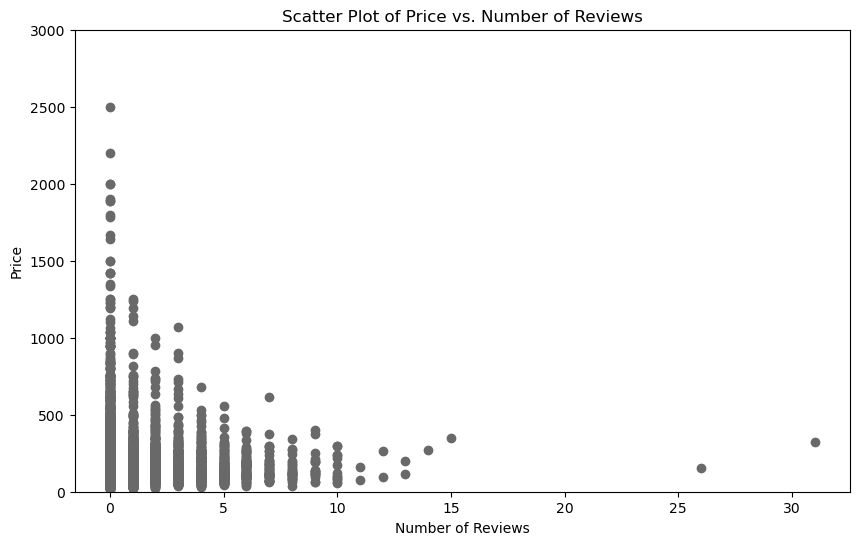

In [264]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( vwListings.number_of_reviews_l30d, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Number of Reviews")
axes.set_title("Scatter Plot of Price vs. Number of Reviews")

plt.ylim(0,3000)
plt.show()
plt.close()

There appears to be no relationship between price and number of reviews in the last 30 days as the data spreads in an unclear pattern.

### Price vs. Instant bookable

We do not exepect that there are no diferent between price of instant bookable and price of no instant bookable.Let's look first at correlation coefficients:

In [266]:
describe_by_category(vwListings, "price", "instant_bookable", transpose=True)

instant_bookable            1           2           3           4           5  \
count              104.000000   43.000000   17.000000   10.000000   10.000000   
mean               164.538462  245.023256  158.294118  233.200000   73.700000   
std                145.694515  196.733986  161.947817  146.800545   32.014059   
min                 30.000000   51.000000   34.000000   45.000000   50.000000   
25%                 91.250000  121.500000   75.000000  137.000000   50.000000   
50%                120.000000  160.000000  100.000000  154.000000   66.500000   
75%                165.250000  272.500000  171.000000  326.000000   83.000000   
max               1000.000000  763.000000  679.000000  479.000000  155.000000   

instant_bookable           6     7           9          13    14  ...  \
count              12.000000   1.0    5.000000    5.000000   1.0  ...   
mean              106.083333  50.0  119.800000  487.000000  63.0  ...   
std                62.569900   NaN   76.149196  170

Let's plot histogram:

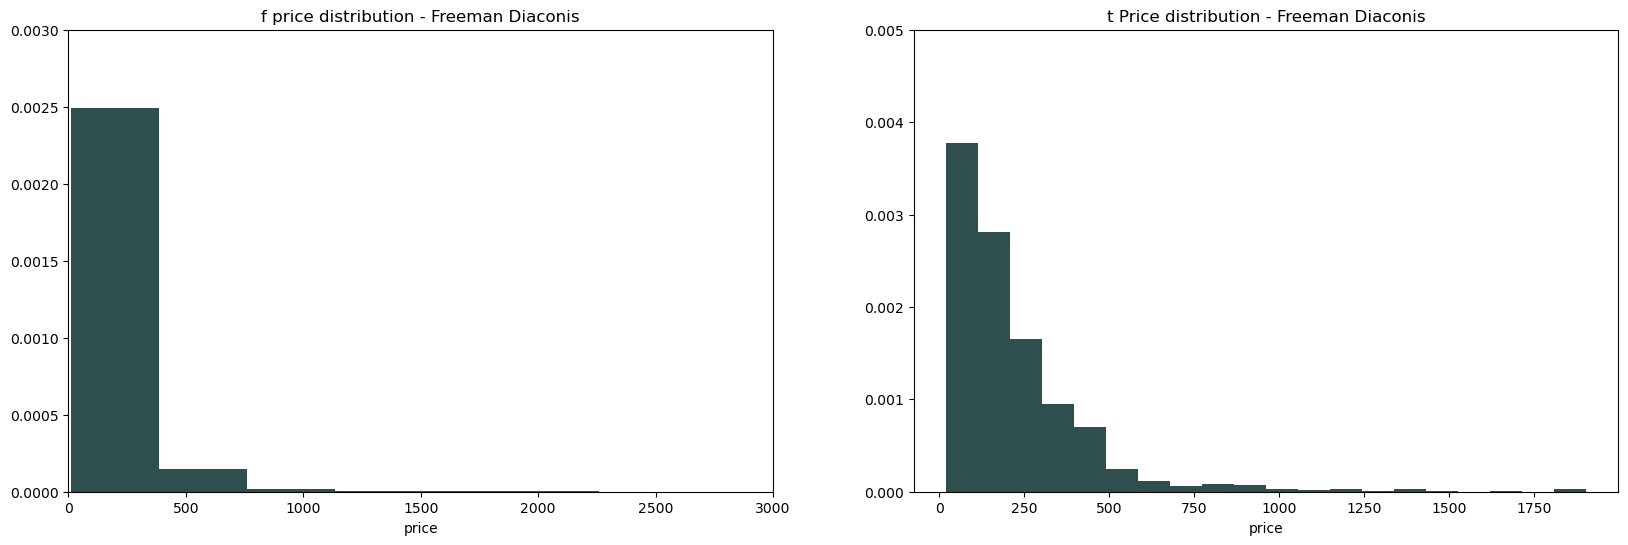

In [267]:
grouped = vwListings.groupby("instant_bookable")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["price"].get_group("f"),bins=20,color="darkslategray",density=True)
axes.set_title("f price distribution - Freeman Diaconis")
axes.set_xlabel("price")
axes.set_ylim((0,0.0030))
axes.set_xlim((0,3000))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["price"].get_group("t"),bins=20,color="darkslategray",density=True)
axes.set_title("t Price distribution - Freeman Diaconis")
axes.set_xlabel("price")
axes.set_ylim((0,0.005))

plt.show()
plt.close()

The price of "no" instant_bookable is concentrated between 0 and 500 dollars. While The price of "Yes" instant_bookable is concentrated between 0 and 250 dollars.

### Price vs. Calculated host listings count

We do not exepect the relation between price and calculated_host_listings_count .Let's look first at correlation coefficients:

In [268]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.calculated_host_listings_count)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.calculated_host_listings_count)[0])

r   =  -0.0032536559245230096
rho =  0.10369955678042328


Pearson's correlation coefficient, 𝑟 , is only -0.03 which indicates a very weak negative relationship. Spearman's is at 0.10 which might indicate weak monotonic relationship. Let's plot the data:

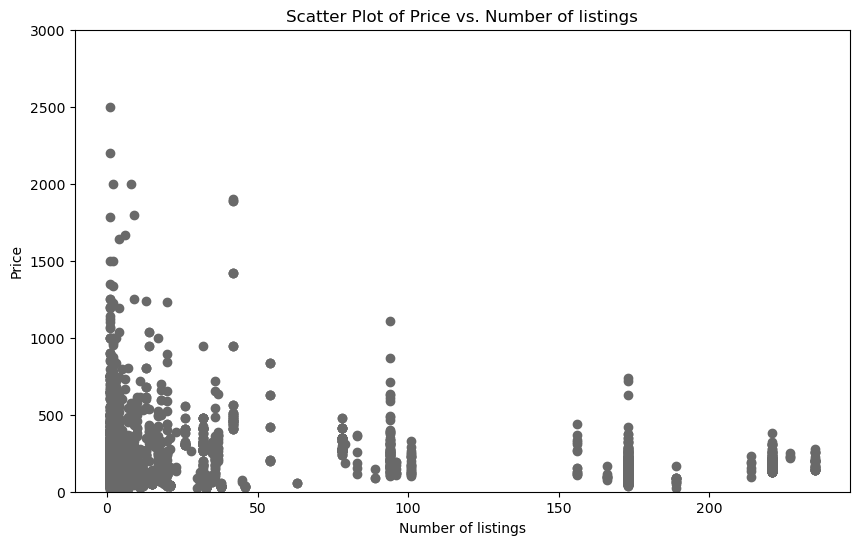

In [269]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( vwListings.calculated_host_listings_count, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Number of listings")
axes.set_title("Scatter Plot of Price vs. Number of listings")

plt.ylim(0,3000)
plt.show()
plt.close()

There appears to be no relationship between price and Host listings count as the data spreads in an unclear pattern.

### Price vs. Calculated host listings count entire homes

We do not exepect the relation between price and calculated_host_listings_count_entire_homes .Let's look first at correlation coefficients:

In [270]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.calculated_host_listings_count_entire_homes)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.calculated_host_listings_count_entire_homes)[0])

r   =  0.0121338533004353
rho =  0.35755484684502403


Pearson's correlation coefficient, 𝑟 , is only 0.01 which indicates a very weak positive relationship. Spearman's is at 0.36 which might indicate weak monotonic relationship. Let's plot the data:

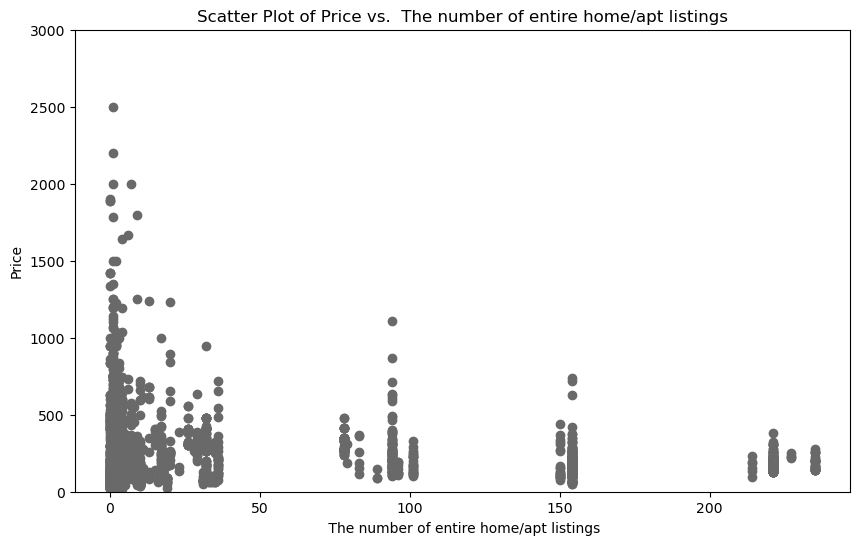

In [271]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( vwListings.calculated_host_listings_count_entire_homes, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel(" The number of entire home/apt listings")
axes.set_title("Scatter Plot of Price vs.  The number of entire home/apt listings")

plt.ylim(0,3000)
plt.show()
plt.close()

There appears to be no relationship between price and the number of entire home/apt listings as the data spreads in an unclear pattern.

### Price vs. Calculated host listings count private rooms

We do not exepect the relation between price and calculated_host_listings_count_private_rooms .Let's look first at correlation coefficients:

In [272]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.calculated_host_listings_count_private_rooms)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.calculated_host_listings_count_private_rooms)[0])

r   =  -0.032426659273794636
rho =  -0.3190249974142017


Pearson's correlation coefficient, 𝑟 , is only -0.08 which indicates a very weak negative relationship. Spearman's is at -0.33 which might indicate weak monotonic relationship. Let's plot the data:

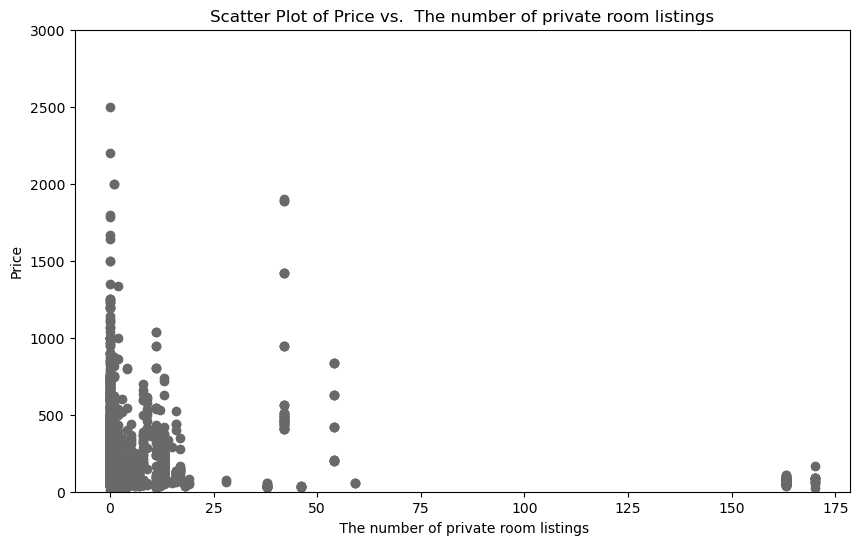

In [273]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( vwListings.calculated_host_listings_count_private_rooms, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel(" The number of private room listings")
axes.set_title("Scatter Plot of Price vs.  The number of private room listings")

plt.ylim(0,3000)
plt.show()
plt.close()

There appears to be no relationship between price and the number of private room listings as the data spreads in an unclear pattern.

### Price vs. Calculated host listings count shared rooms

We do not exepect the relation between price and calculated_host_listings_count_shared_rooms .Let's look first at correlation coefficients:

In [274]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.calculated_host_listings_count_shared_rooms)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.calculated_host_listings_count_shared_rooms)[0])

r   =  -0.06972146129565111
rho =  -0.07791587902352365


Pearson's correlation coefficient, 𝑟 , is only -0.06 which indicates a very weak negative relationship. Spearman's is at -0.07 which might indicate weak monotonic relationship. Let's plot the data:

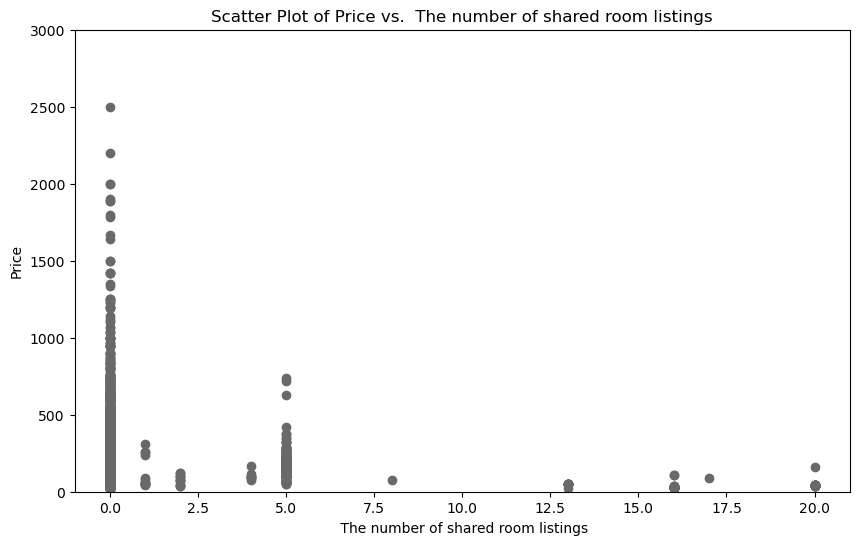

In [275]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( vwListings.calculated_host_listings_count_shared_rooms, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel(" The number of shared room listings")
axes.set_title("Scatter Plot of Price vs.  The number of shared room listings")

plt.ylim(0,3000)
plt.show()
plt.close()

There appears to be no relationship between price and the number of shared room listings as the data spreads in an unclear pattern.

### Price vs. Distance to Smitsonian

We expect that distance to attraction is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [276]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_smitsonian)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_smitsonian)[0])

r   =  -0.1572966745139866
rho =  -0.3658672602508626


Pearson's correlation coefficient, 𝑟 , is at -0.15, which indicates a weak negative relationship. Spearman's is also interesting at -0.37, which might indicate a weak monotonic relationship. Let's plot the data:

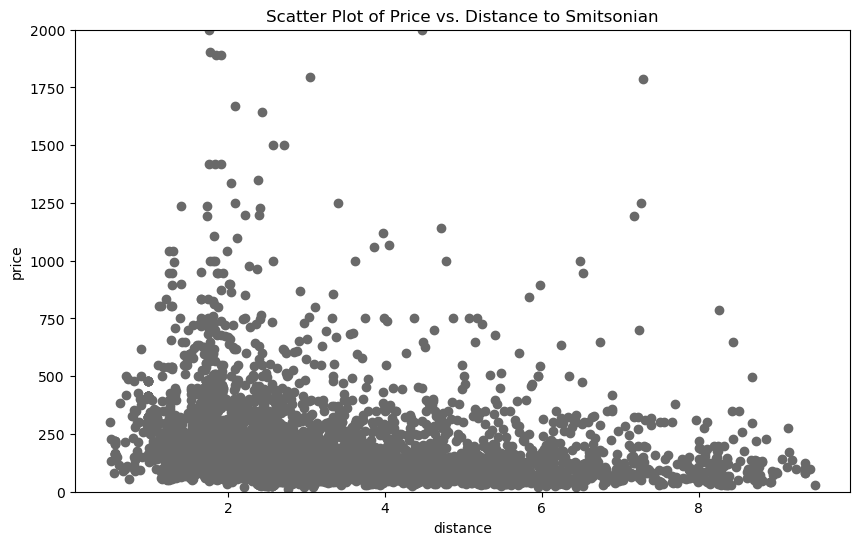

In [277]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( vwListings.distance_smitsonian, vwListings.price, marker="o", color="dimgray")

plt.ylim(0,2000)
axes.set_ylabel("price")
axes.set_xlabel("distance")
axes.set_title("Scatter Plot of Price vs. Distance to Smitsonian")

plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to Lincoln

We expect that distance to attraction is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [278]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_lincoln)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_lincoln)[0])

r   =  -0.17917047766246647
rho =  -0.35038264583935125


Pearson's correlation coefficient, 𝑟 , is at -0.17, which indicates a weak negative relationship. Spearman's is also interesting at -0.35, which might indicate a weak monotonic relationship. Let's plot the data:

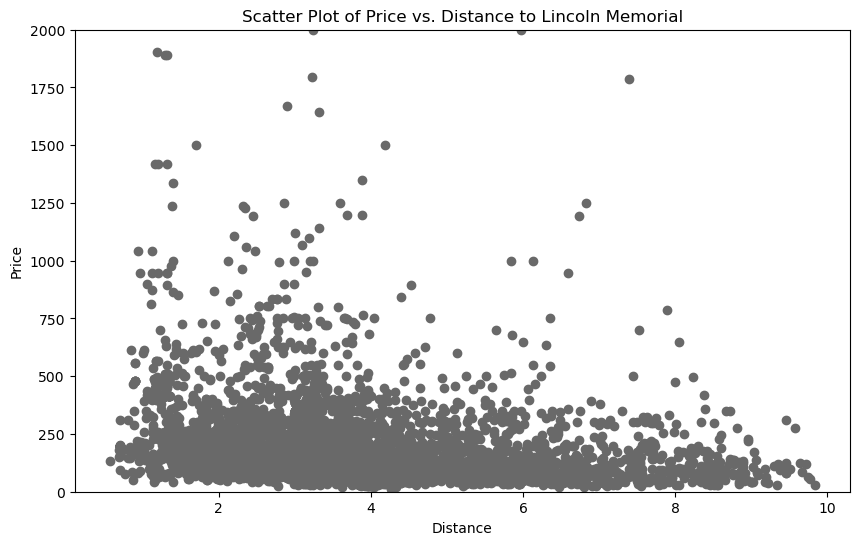

In [279]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_lincoln, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to Lincoln Memorial")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to White House

We expect that distance to attraction is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [280]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_white_house)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_white_house)[0])

r   =  -0.11399792608216662
rho =  -0.24129218132413044


Pearson's correlation coefficient, 𝑟 , is at -0.11, which indicates a weak negative relationship. Spearman's is also interesting at -0.24, which might indicate a weak monotonic relationship. Let's plot the data:

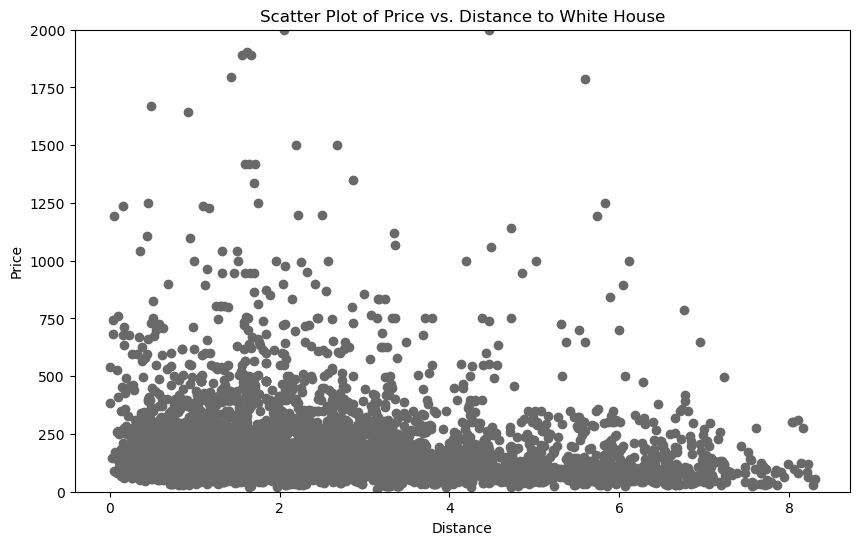

In [281]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_white_house, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to White House")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to Library Congress

We expect that distance to attraction is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [282]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_library_congress)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_library_congress)[0])

r   =  -0.1056711441347257
rho =  -0.2449947864034021


Pearson's correlation coefficient, 𝑟 , is at -0.10, which indicates a weak negative relationship. Spearman's is also interesting at -0.24, which might indicate a weak monotonic relationship. Let's plot the data:

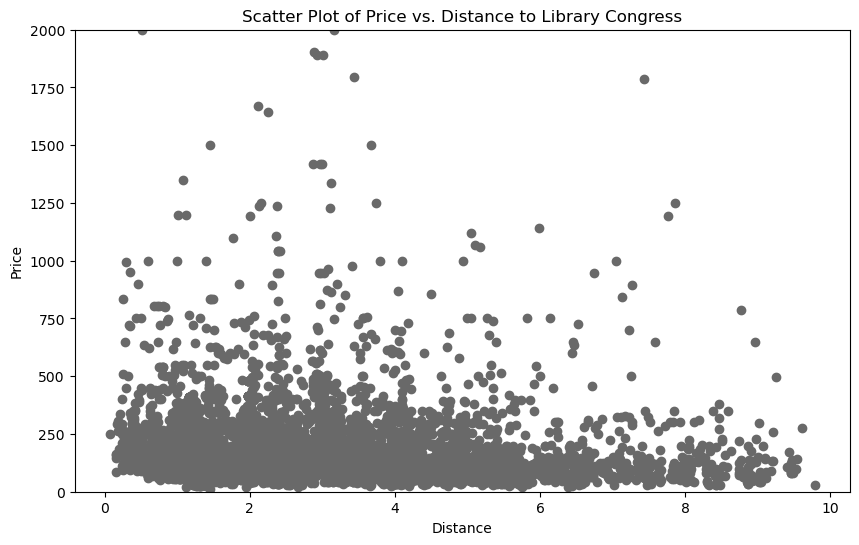

In [283]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_library_congress, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to Library Congress")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to Nationals Park

We expect that distance to attraction is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [284]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_nationals_park)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_nationals_park)[0])

r   =  -0.10450789688265524
rho =  -0.22221531592251076


Pearson's correlation coefficient, 𝑟 , is at -0.10, which indicates a weak negative relationship. Spearman's is also interesting at -0.22, which might indicate a weak monotonic relationship. Let's plot the data:

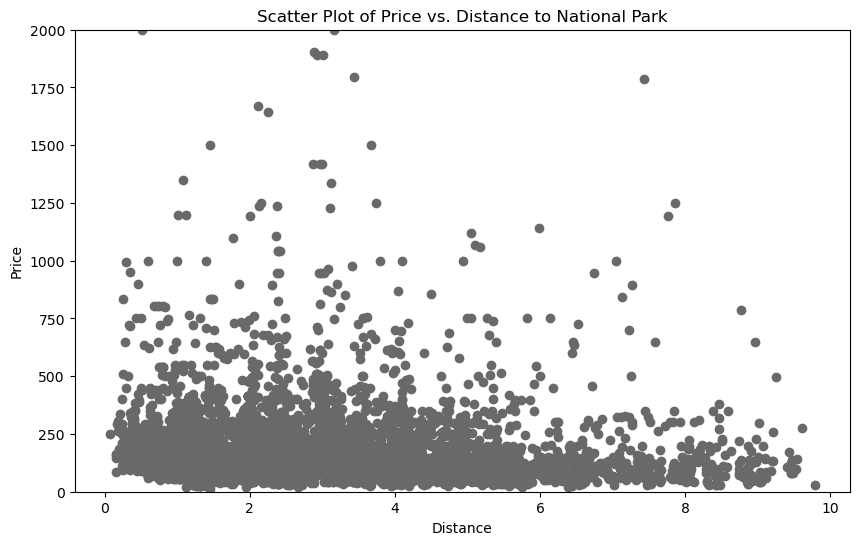

In [285]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_library_congress, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to National Park")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to Railway

We expect that distance to railway station is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [286]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_railway)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_railway)[0])

r   =  -0.10692052993221937
rho =  -0.2550517516646708


Pearson's correlation coefficient, 𝑟 , is at -0.10, which indicates a weak negative relationship. Spearman's is also interesting at -0.25, which might indicate a weak monotonic relationship. Let's plot the data:

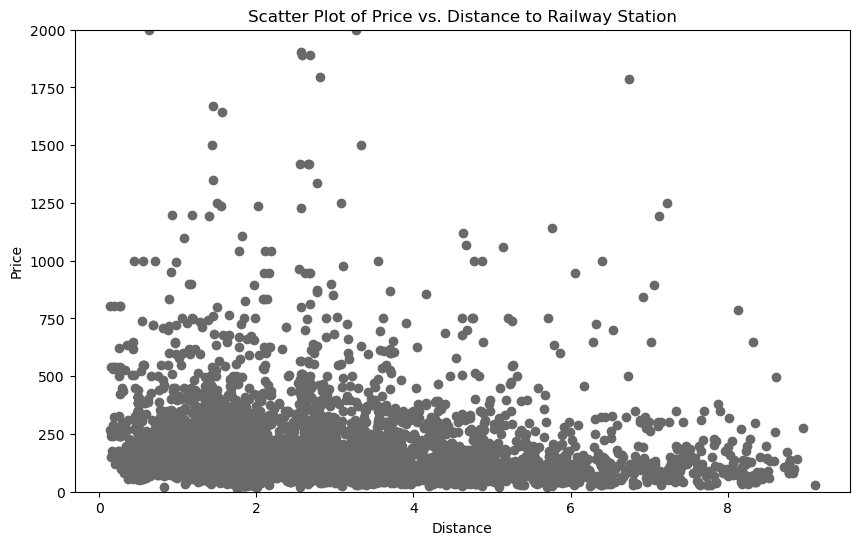

In [287]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_railway, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to Railway Station")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to McPherson

We expect that distance to Mcpherson Square station is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [289]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_mcpherson)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_mcpherson)[0])

r   =  -0.1533033065218159
rho =  -0.3151582520797061


Pearson's correlation coefficient, 𝑟 , is at -0.15, which indicates a weak negative relationship. Spearman's is also interesting at -0.31, which might indicate a weak monotonic relationship. Let's plot the data:

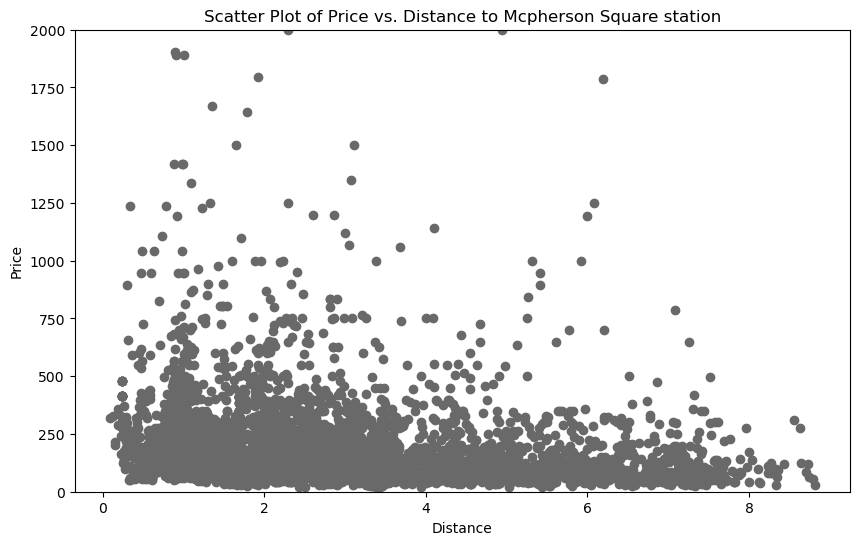

In [290]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_mcpherson, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to Mcpherson Square station")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.